**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


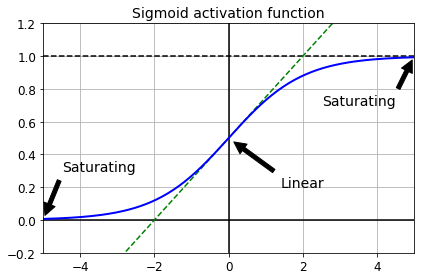

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


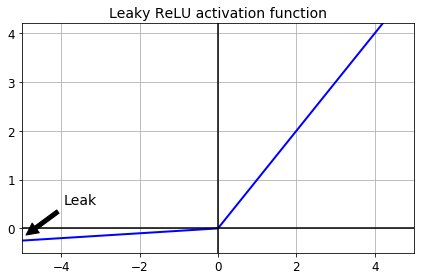

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9654
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9778
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


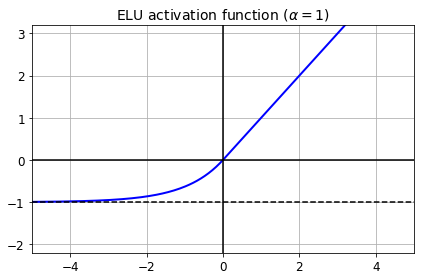

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I added paragraph about SELU in the latest release of my book). During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.

In [25]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


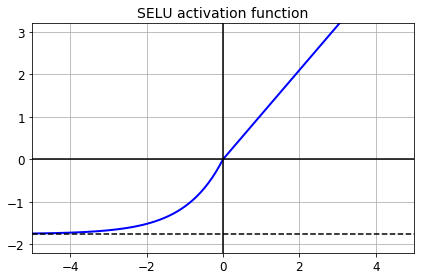

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


The `tf.nn.selu()` function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4 (or check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.923
5 Batch accuracy: 0.98 Validation accuracy: 0.9578
10 Batch accuracy: 1.0 Validation accuracy: 0.9664
15 Batch accuracy: 0.96 Validation accuracy: 0.9682
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.97


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [35]:
n_epochs = 20
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [37]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [38]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [39]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [40]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [41]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [42]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [43]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_epochs = 20
batch_size = 200

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9296
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9474
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9612


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [46]:
reset_graph()

In [47]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [48]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [49]:
from tensorflow_graph_in_jupyter import show_graph

In [50]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [51]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [52]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [53]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9658
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.965
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9682
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9668
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9726
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [56]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9712


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [58]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [59]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9126
1 Validation accuracy: 0.9374
2 Validation accuracy: 0.946
3 Validation accuracy: 0.9498
4 Validation accuracy: 0.953
5 Validation accuracy: 0.9528
6 Validation accuracy: 0.9564
7 Validation accuracy: 0.96
8 Validation accuracy: 0.9616
9 Validation accuracy: 0.9612
10 Validation accuracy: 0.9634
11 Validation accuracy: 0.9626
12 Validation accuracy: 0.9648
13 Validation accuracy: 0.9656
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.967
16 Validation accuracy: 0.968
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9678


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [61]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9024
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.943
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.9592
8 Validation accuracy: 0.9586
9 Validation accuracy: 0.9608
10 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
12 Validation accuracy: 0.964
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.966
15 Validation accuracy: 0.9662
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9678


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [62]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [63]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [64]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [65]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [67]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [68]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [69]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [70]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [71]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9298
2 Validation accuracy: 0.94
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.948
5 Validation accuracy: 0.951
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9538
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.957
10 Validation accuracy: 0.9562
11 Validation accuracy: 0.9566
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9602


In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [73]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [74]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [75]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


### Caching the Frozen Layers

In [76]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [77]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


# Faster Optimizers

## Momentum optimization

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [80]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [81]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [82]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [83]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [84]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [85]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [86]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.959
1 Validation accuracy: 0.9688
2 Validation accuracy: 0.9726
3 Validation accuracy: 0.9804
4 Validation accuracy: 0.982


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [89]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [90]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [93]:
scale = 0.001

In [94]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [95]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [96]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [98]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [99]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [100]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9264
1 Validation accuracy: 0.9446
2 Validation accuracy: 0.9488
3 Validation accuracy: 0.9556
4 Validation accuracy: 0.9612
5 Validation accuracy: 0.9598
6 Validation accuracy: 0.9616
7 Validation accuracy: 0.9674
8 Validation accuracy: 0.967
9 Validation accuracy: 0.9706
10 Validation accuracy: 0.9674
11 Validation accuracy: 0.9678
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.97
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9702
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9716
18 Validation accuracy: 0.9734
19 Validation accuracy: 0.972


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [102]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [103]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [104]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [105]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [106]:
n_epochs = 20
batch_size = 50

In [107]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9568
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.972
3 Validation accuracy: 0.9768
4 Validation accuracy: 0.9784
5 Validation accuracy: 0.9786
6 Validation accuracy: 0.9816
7 Validation accuracy: 0.9808
8 Validation accuracy: 0.981
9 Validation accuracy: 0.983
10 Validation accuracy: 0.9822
11 Validation accuracy: 0.9854
12 Validation accuracy: 0.9822
13 Validation accuracy: 0.9842
14 Validation accuracy: 0.984
15 Validation accuracy: 0.9852
16 Validation accuracy: 0.984
17 Validation accuracy: 0.9844
18 Validation accuracy: 0.9844
19 Validation accuracy: 0.9844


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [108]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [109]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [110]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [111]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [112]:
n_epochs = 20
batch_size = 50

In [113]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9698
2 Validation accuracy: 0.9726
3 Validation accuracy: 0.9744
4 Validation accuracy: 0.9762
5 Validation accuracy: 0.9772
6 Validation accuracy: 0.979
7 Validation accuracy: 0.9816
8 Validation accuracy: 0.9814
9 Validation accuracy: 0.9812
10 Validation accuracy: 0.9818
11 Validation accuracy: 0.9816
12 Validation accuracy: 0.9802
13 Validation accuracy: 0.9822
14 Validation accuracy: 0.982
15 Validation accuracy: 0.9812
16 Validation accuracy: 0.9824
17 Validation accuracy: 0.9836
18 Validation accuracy: 0.9824
19 Validation accuracy: 0.9826


# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [114]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [115]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [116]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [117]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [118]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.116407	Best loss: 0.116407	Accuracy: 97.58%
1	Validation loss: 0.180534	Best loss: 0.116407	Accuracy: 97.11%
2	Validation loss: 0.227535	Best loss: 0.116407	Accuracy: 93.86%
3	Validation loss: 0.107346	Best loss: 0.107346	Accuracy: 97.54%
4	Validation loss: 0.302668	Best loss: 0.107346	Accuracy: 95.35%
5	Validation loss: 1.631054	Best loss: 0.107346	Accuracy: 22.01%
6	Validation loss: 1.635262	Best loss: 0.107346	Accuracy: 18.73%
7	Validation loss: 1.671200	Best loss: 0.107346	Accuracy: 22.01%
8	Validation loss: 1.695277	Best loss: 0.107346	Accuracy: 19.27%
9	Validation loss: 1.744607	Best loss: 0.107346	Accuracy: 20.91%
10	Validation loss: 1.629857	Best loss: 0.107346	Accuracy: 22.01%
11	Validation loss: 1.810803	Best loss: 0.107346	Accuracy: 22.01%
12	Validation loss: 1.675703	Best loss: 0.107346	Accuracy: 18.73%
13	Validation loss: 1.633233	Best loss: 0.107346	Accuracy: 20.91%
14	Validation loss: 1.652905	Best loss: 0.107346	Accuracy: 20.91%
15	Validation loss: 

This test accuracy is not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [120]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.116407	Best loss: 0.116407	Accuracy: 97.58%
1	Validation loss: 0.180534	Best loss: 0.116407	Accuracy: 97.11%
2	Validation loss: 0.227535	Best loss: 0.116407	Accuracy: 93.86%
3	Validation loss: 0.107346	Best loss: 0.107346	Accuracy: 97.54%
4	Validation loss: 0.302668	Best loss: 0.107346	Accuracy: 95.35%
5	Validation loss: 1.631054	Best loss: 0.107346	Accuracy: 22.01%
6	Validation loss: 1.635262	Best loss: 0.107346	Accuracy: 18.73%
7	Validation loss: 1.671200	Best loss: 0.107346	Accuracy: 22.01%
8	Validation loss: 1.695277	Best loss: 0.107346	Accuracy: 19.27%
9	Validation loss: 1.744607	Best loss: 0.107346	Accuracy: 20.91%
10	Validation loss: 1.629857	Best loss: 0.107346	Accuracy: 22.01%
11	Validation loss: 1.810803	Best loss: 0.107346	Accuracy: 22.01%
12	Validation loss: 1.675703	Best loss: 0.107346	Accuracy: 18.73%
13	Validation loss: 1.633233	Best loss: 0.107346	Accuracy: 20.91%
14	Validation loss: 1.652905	Best loss: 0.107346	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [121]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9725627553998832

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [122]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x1243639d8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.143224	Best loss: 0.143224	Accuracy: 95.82%
1	Validation loss: 0.143304	Best loss: 0.143224	Accuracy: 96.60%
2	Validation loss: 0.106488	Best loss: 0.106488	Accuracy: 96.95%
3	Validation loss: 0.307107	Best loss: 0.106488	Accuracy: 92.34%
4	Validation loss: 0.157948	Best loss: 0.106488	Accuracy: 95.50%
5	Validation loss: 0.131002	Best loss: 0.106488	Accuracy: 96.40%
6	Validation loss: 0.931847	Best loss: 0.106488	Accuracy: 58.29%
7	Validation loss: 0.872748	Best loss: 0.106488	Accuracy: 57.97%
8	Validation loss: 0.699336	Best loss: 0.106488	Accuracy: 58.29%
9	Validation loss: 0.853343	Best loss: 0.106488	Accuracy: 57.27%
10	Validation loss: 0.738493	Best loss: 0.106488	Accuracy: 59.19%
11	Validation loss: 0.670431	Best loss: 0.106488	Accuracy: 59.23%
12	Validation loss: 0.717334	Best loss: 0.106488	Accuracy: 59.11%
13	Validation loss: 0.718714	Best loss: 0.106488	Accuracy: 56.57%
14	Validation loss: 0.679313	Best loss: 0.106488	Accuracy: 59.07%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


0	Validation loss: 0.137274	Best loss: 0.137274	Accuracy: 96.33%
1	Validation loss: 0.145733	Best loss: 0.137274	Accuracy: 95.97%
2	Validation loss: 0.171077	Best loss: 0.137274	Accuracy: 95.90%
3	Validation loss: 0.139310	Best loss: 0.137274	Accuracy: 96.79%
4	Validation loss: 0.365713	Best loss: 0.137274	Accuracy: 92.73%
5	Validation loss: 0.514753	Best loss: 0.137274	Accuracy: 83.46%
6	Validation loss: 0.856815	Best loss: 0.137274	Accuracy: 57.08%
7	Validation loss: 0.897573	Best loss: 0.137274	Accuracy: 66.03%
8	Validation loss: 1.534284	Best loss: 0.137274	Accuracy: 37.02%
9	Validation loss: 0.974006	Best loss: 0.137274	Accuracy: 67.01%
10	Validation loss: 0.862646	Best loss: 0.137274	Accuracy: 71.85%
11	Validation loss: 0.817344	Best loss: 0.137274	Accuracy: 73.34%
12	Validation loss: 0.723583	Best loss: 0.137274	Accuracy: 79.75%
13	Validation loss: 0.646904	Best loss: 0.137274	Accuracy: 86.28%
14	Validation loss: 0.669650	Best loss: 0.137274	Accuracy: 87.57%
15	Validation loss: 

32	Validation loss: 0.082805	Best loss: 0.054832	Accuracy: 98.63%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x124366d08>, total=   3.6s
[CV] n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.101571	Best loss: 0.101571	Accuracy: 96.79%
1	Validation loss: 0.077615	Best loss: 0.077615	Accuracy: 97.97%
2	Validation loss: 0.060394	Best loss: 0.060394	Accuracy: 98.05%
3	Validation loss: 0.069809	Best loss: 0.060394	Accuracy: 97.97%
4	Validation loss: 0.047249	Best loss: 0.047249	Accuracy: 98.59%
5	Validation loss: 0.063866	Best loss: 0.047249	Accuracy: 97.81%
6	Validation loss: 0.054860	Best loss: 0.047249	Accuracy: 98.24%
7	Validation loss: 0.070164	Best loss: 0.047249	Accuracy: 98.40%
8	Validation loss: 0.050729	Best loss: 0.047249	Accuracy: 98.63%
9	Validation loss: 0.052778	Best loss: 0.047249	Accuracy: 98.67%
10	Validation loss: 0.051625	Best loss: 0.047249	Accuracy

12	Validation loss: 46.072357	Best loss: 0.946387	Accuracy: 93.86%
13	Validation loss: 70.133774	Best loss: 0.946387	Accuracy: 91.63%
14	Validation loss: 53.063385	Best loss: 0.946387	Accuracy: 91.99%
15	Validation loss: 47.811386	Best loss: 0.946387	Accuracy: 92.34%
16	Validation loss: 25.837633	Best loss: 0.946387	Accuracy: 93.82%
17	Validation loss: 27.841801	Best loss: 0.946387	Accuracy: 95.07%
18	Validation loss: 211.868423	Best loss: 0.946387	Accuracy: 84.95%
19	Validation loss: 22290.859375	Best loss: 0.946387	Accuracy: 51.49%
20	Validation loss: 936.696655	Best loss: 0.946387	Accuracy: 82.02%
21	Validation loss: 693.945862	Best loss: 0.946387	Accuracy: 78.42%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.05, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=  14.3s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28> 
0	Validation loss: 178

22	Validation loss: 0.064385	Best loss: 0.040555	Accuracy: 99.18%
23	Validation loss: 0.095468	Best loss: 0.040555	Accuracy: 99.02%
24	Validation loss: 0.055795	Best loss: 0.040555	Accuracy: 98.83%
25	Validation loss: 0.058368	Best loss: 0.040555	Accuracy: 99.02%
26	Validation loss: 0.067411	Best loss: 0.040555	Accuracy: 98.98%
27	Validation loss: 0.066987	Best loss: 0.040555	Accuracy: 98.71%
28	Validation loss: 0.064438	Best loss: 0.040555	Accuracy: 98.63%
29	Validation loss: 0.072174	Best loss: 0.040555	Accuracy: 99.02%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=   8.2s
[CV] n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80> 
0	Validation loss: 0.099178	Best loss: 0.099178	Accuracy: 97.15%
1	Validation loss: 0.068436	Best loss: 0.068436	Accuracy: 98.05%
2	Validation loss: 0.058424	Best lo

1	Validation loss: 0.062750	Best loss: 0.062750	Accuracy: 98.01%
2	Validation loss: 0.058109	Best loss: 0.058109	Accuracy: 98.12%
3	Validation loss: 0.068417	Best loss: 0.058109	Accuracy: 98.05%
4	Validation loss: 0.055424	Best loss: 0.055424	Accuracy: 98.12%
5	Validation loss: 0.051893	Best loss: 0.051893	Accuracy: 98.24%
6	Validation loss: 0.046882	Best loss: 0.046882	Accuracy: 98.51%
7	Validation loss: 0.042989	Best loss: 0.042989	Accuracy: 98.75%
8	Validation loss: 0.043665	Best loss: 0.042989	Accuracy: 98.67%
9	Validation loss: 0.047032	Best loss: 0.042989	Accuracy: 98.48%
10	Validation loss: 0.063107	Best loss: 0.042989	Accuracy: 98.63%
11	Validation loss: 0.049539	Best loss: 0.042989	Accuracy: 98.51%
12	Validation loss: 0.053372	Best loss: 0.042989	Accuracy: 98.91%
13	Validation loss: 0.058846	Best loss: 0.042989	Accuracy: 98.75%
14	Validation loss: 0.044186	Best loss: 0.042989	Accuracy: 98.79%
15	Validation loss: 0.043688	Best loss: 0.042989	Accuracy: 98.91%
16	Validation loss:

11	Validation loss: 0.059304	Best loss: 0.048410	Accuracy: 98.48%
12	Validation loss: 0.063566	Best loss: 0.048410	Accuracy: 98.55%
13	Validation loss: 0.057075	Best loss: 0.048410	Accuracy: 98.44%
14	Validation loss: 0.052350	Best loss: 0.048410	Accuracy: 98.87%
15	Validation loss: 0.059708	Best loss: 0.048410	Accuracy: 98.67%
16	Validation loss: 0.063762	Best loss: 0.048410	Accuracy: 98.55%
17	Validation loss: 0.054331	Best loss: 0.048410	Accuracy: 98.71%
18	Validation loss: 0.073180	Best loss: 0.048410	Accuracy: 98.75%
19	Validation loss: 0.077151	Best loss: 0.048410	Accuracy: 98.48%
20	Validation loss: 0.062613	Best loss: 0.048410	Accuracy: 98.48%
21	Validation loss: 0.057950	Best loss: 0.048410	Accuracy: 98.91%
22	Validation loss: 0.062222	Best loss: 0.048410	Accuracy: 98.79%
23	Validation loss: 0.037418	Best loss: 0.037418	Accuracy: 99.06%
24	Validation loss: 0.050106	Best loss: 0.037418	Accuracy: 98.98%
25	Validation loss: 0.044183	Best loss: 0.037418	Accuracy: 98.91%
26	Validat

30	Validation loss: 1.609285	Best loss: 1.609285	Accuracy: 22.01%
31	Validation loss: 1.634894	Best loss: 1.609285	Accuracy: 18.73%
32	Validation loss: 1.614006	Best loss: 1.609285	Accuracy: 19.08%
33	Validation loss: 1.619314	Best loss: 1.609285	Accuracy: 19.08%
34	Validation loss: 1.611677	Best loss: 1.609285	Accuracy: 22.01%
35	Validation loss: 1.638075	Best loss: 1.609285	Accuracy: 20.91%
36	Validation loss: 1.621402	Best loss: 1.609285	Accuracy: 22.01%
37	Validation loss: 1.617570	Best loss: 1.609285	Accuracy: 22.01%
38	Validation loss: 1.620770	Best loss: 1.609285	Accuracy: 20.91%
39	Validation loss: 1.627340	Best loss: 1.609285	Accuracy: 19.27%
40	Validation loss: 1.607887	Best loss: 1.607887	Accuracy: 22.01%
41	Validation loss: 1.634036	Best loss: 1.607887	Accuracy: 22.01%
42	Validation loss: 1.618335	Best loss: 1.607887	Accuracy: 20.91%
43	Validation loss: 1.618744	Best loss: 1.607887	Accuracy: 22.01%
44	Validation loss: 1.621666	Best loss: 1.607887	Accuracy: 19.08%
45	Validat

32	Validation loss: 0.086318	Best loss: 0.067610	Accuracy: 98.05%
33	Validation loss: 0.087818	Best loss: 0.067610	Accuracy: 98.12%
34	Validation loss: 0.107289	Best loss: 0.067610	Accuracy: 97.89%
35	Validation loss: 0.133042	Best loss: 0.067610	Accuracy: 98.36%
36	Validation loss: 0.078993	Best loss: 0.067610	Accuracy: 98.16%
37	Validation loss: 0.080012	Best loss: 0.067610	Accuracy: 98.44%
38	Validation loss: 0.086776	Best loss: 0.067610	Accuracy: 98.48%
39	Validation loss: 0.128176	Best loss: 0.067610	Accuracy: 97.62%
40	Validation loss: 0.200972	Best loss: 0.067610	Accuracy: 98.01%
41	Validation loss: 0.109124	Best loss: 0.067610	Accuracy: 98.20%
42	Validation loss: 0.089580	Best loss: 0.067610	Accuracy: 98.36%
43	Validation loss: 0.084378	Best loss: 0.067610	Accuracy: 98.28%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x124366d08>, total=  12.4s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function rel

14	Validation loss: 0.756348	Best loss: 0.107859	Accuracy: 72.05%
15	Validation loss: 0.742958	Best loss: 0.107859	Accuracy: 74.20%
16	Validation loss: 0.753458	Best loss: 0.107859	Accuracy: 70.64%
17	Validation loss: 0.634644	Best loss: 0.107859	Accuracy: 74.71%
18	Validation loss: 1.051074	Best loss: 0.107859	Accuracy: 71.31%
19	Validation loss: 0.469943	Best loss: 0.107859	Accuracy: 81.59%
20	Validation loss: 0.430562	Best loss: 0.107859	Accuracy: 84.48%
21	Validation loss: 0.383880	Best loss: 0.107859	Accuracy: 85.22%
22	Validation loss: 0.498660	Best loss: 0.107859	Accuracy: 82.41%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=   7.6s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80> 
0	Validation loss: 0.164369	Best loss: 0.164369	Accuracy: 95.43%
1	Validation loss: 0.129233	Best los

16	Validation loss: 0.098948	Best loss: 0.068409	Accuracy: 98.44%
17	Validation loss: 0.105253	Best loss: 0.068409	Accuracy: 98.44%
18	Validation loss: 0.101155	Best loss: 0.068409	Accuracy: 98.55%
19	Validation loss: 0.169691	Best loss: 0.068409	Accuracy: 98.05%
20	Validation loss: 0.106316	Best loss: 0.068409	Accuracy: 98.16%
21	Validation loss: 0.176682	Best loss: 0.068409	Accuracy: 98.36%
22	Validation loss: 0.102204	Best loss: 0.068409	Accuracy: 98.51%
23	Validation loss: 0.130347	Best loss: 0.068409	Accuracy: 98.01%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28>, total=  12.1s
[CV] n_neurons=120, learning_rate=0.02, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28> 
0	Validation loss: 13.252987	Best loss: 13.252987	Accuracy: 90.23%
1	Validation loss: 30.856510	Best loss: 13.252987	Accuracy: 88.62%
2	Validation loss: 477.997498	Best

0	Validation loss: 1.328480	Best loss: 1.328480	Accuracy: 43.71%
1	Validation loss: 0.614470	Best loss: 0.614470	Accuracy: 79.79%
2	Validation loss: 0.393559	Best loss: 0.393559	Accuracy: 84.52%
3	Validation loss: 0.274669	Best loss: 0.274669	Accuracy: 90.81%
4	Validation loss: 0.269803	Best loss: 0.269803	Accuracy: 91.16%
5	Validation loss: 0.293372	Best loss: 0.269803	Accuracy: 90.42%
6	Validation loss: 0.235249	Best loss: 0.235249	Accuracy: 92.69%
7	Validation loss: 0.199580	Best loss: 0.199580	Accuracy: 93.98%
8	Validation loss: 0.204801	Best loss: 0.199580	Accuracy: 93.71%
9	Validation loss: 0.210236	Best loss: 0.199580	Accuracy: 93.67%
10	Validation loss: 0.200994	Best loss: 0.199580	Accuracy: 93.75%
11	Validation loss: 0.168679	Best loss: 0.168679	Accuracy: 95.00%
12	Validation loss: 0.148922	Best loss: 0.148922	Accuracy: 95.50%
13	Validation loss: 0.197888	Best loss: 0.148922	Accuracy: 94.21%
14	Validation loss: 0.145279	Best loss: 0.145279	Accuracy: 96.21%
15	Validation loss: 

4	Validation loss: 192.132751	Best loss: 0.512231	Accuracy: 66.93%
5	Validation loss: 567.799866	Best loss: 0.512231	Accuracy: 58.87%
6	Validation loss: 150.234589	Best loss: 0.512231	Accuracy: 71.15%
7	Validation loss: 145.653458	Best loss: 0.512231	Accuracy: 68.41%
8	Validation loss: 81.165398	Best loss: 0.512231	Accuracy: 79.87%
9	Validation loss: 145.883987	Best loss: 0.512231	Accuracy: 61.49%
10	Validation loss: 228.557877	Best loss: 0.512231	Accuracy: 37.06%
11	Validation loss: 26.550442	Best loss: 0.512231	Accuracy: 83.85%
12	Validation loss: 26.499146	Best loss: 0.512231	Accuracy: 81.86%
13	Validation loss: 115940.617188	Best loss: 0.512231	Accuracy: 20.52%
14	Validation loss: 3679.880371	Best loss: 0.512231	Accuracy: 52.46%
15	Validation loss: 6176.601074	Best loss: 0.512231	Accuracy: 44.57%
16	Validation loss: 25691.734375	Best loss: 0.512231	Accuracy: 47.89%
17	Validation loss: 3168.093750	Best loss: 0.512231	Accuracy: 65.91%
18	Validation loss: 7767.674805	Best loss: 0.5122

26	Validation loss: 6659.347168	Best loss: 0.663534	Accuracy: 94.61%
27	Validation loss: 7886.392578	Best loss: 0.663534	Accuracy: 93.28%
28	Validation loss: 11588.251953	Best loss: 0.663534	Accuracy: 93.47%
29	Validation loss: 8104.395020	Best loss: 0.663534	Accuracy: 92.49%
30	Validation loss: 11553.480469	Best loss: 0.663534	Accuracy: 94.57%
31	Validation loss: 8503.565430	Best loss: 0.663534	Accuracy: 94.21%
32	Validation loss: 9673.297852	Best loss: 0.663534	Accuracy: 94.25%
33	Validation loss: 18215.628906	Best loss: 0.663534	Accuracy: 91.05%
34	Validation loss: 10773.076172	Best loss: 0.663534	Accuracy: 93.24%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28>, total=  13.0s
[CV] n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28> 
0	Validation loss: 23.194595	Best loss: 23.194595	Accuracy: 79.48%
1	Val

0	Validation loss: 1.852486	Best loss: 1.852486	Accuracy: 18.73%
1	Validation loss: 2.186056	Best loss: 1.852486	Accuracy: 22.01%
2	Validation loss: 2.193672	Best loss: 1.852486	Accuracy: 19.08%
3	Validation loss: 2.144101	Best loss: 1.852486	Accuracy: 19.27%
4	Validation loss: 3.100767	Best loss: 1.852486	Accuracy: 20.91%
5	Validation loss: 2.464265	Best loss: 1.852486	Accuracy: 20.91%
6	Validation loss: 2.003222	Best loss: 1.852486	Accuracy: 22.01%
7	Validation loss: 1.763754	Best loss: 1.763754	Accuracy: 22.01%
8	Validation loss: 1.700600	Best loss: 1.700600	Accuracy: 19.27%
9	Validation loss: 2.334469	Best loss: 1.700600	Accuracy: 22.01%
10	Validation loss: 1.853945	Best loss: 1.700600	Accuracy: 18.73%
11	Validation loss: 1.842178	Best loss: 1.700600	Accuracy: 19.27%
12	Validation loss: 2.091015	Best loss: 1.700600	Accuracy: 20.91%
13	Validation loss: 3.280345	Best loss: 1.700600	Accuracy: 19.08%
14	Validation loss: 2.147487	Best loss: 1.700600	Accuracy: 19.08%
15	Validation loss: 

26	Validation loss: 0.065968	Best loss: 0.051927	Accuracy: 98.87%
27	Validation loss: 0.099620	Best loss: 0.051927	Accuracy: 98.51%
28	Validation loss: 0.057779	Best loss: 0.051927	Accuracy: 99.02%
29	Validation loss: 0.064403	Best loss: 0.051927	Accuracy: 98.91%
30	Validation loss: 0.078111	Best loss: 0.051927	Accuracy: 98.83%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x1243639d8>, total=   6.5s
[CV] n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.208889	Best loss: 0.208889	Accuracy: 94.68%
1	Validation loss: 0.196880	Best loss: 0.196880	Accuracy: 94.33%
2	Validation loss: 0.846685	Best loss: 0.196880	Accuracy: 85.11%
3	Validation loss: 0.381405	Best loss: 0.196880	Accuracy: 90.03%
4	Validation loss: 0.196067	Best loss: 0.196067	Accuracy: 94.14%
5	Validation loss: 0.248567	Best loss: 0.196067	Accuracy: 93.98%
6	Validation loss: 0.354902	Best loss: 0.196067	Accurac

8	Validation loss: 1.699082	Best loss: 0.113022	Accuracy: 94.45%
9	Validation loss: 1.285351	Best loss: 0.113022	Accuracy: 95.23%
10	Validation loss: 1.741202	Best loss: 0.113022	Accuracy: 94.41%
11	Validation loss: 1.041083	Best loss: 0.113022	Accuracy: 95.97%
12	Validation loss: 1.227441	Best loss: 0.113022	Accuracy: 94.84%
13	Validation loss: 1.381479	Best loss: 0.113022	Accuracy: 94.88%
14	Validation loss: 1.357859	Best loss: 0.113022	Accuracy: 92.10%
15	Validation loss: 1.712307	Best loss: 0.113022	Accuracy: 93.39%
16	Validation loss: 0.776625	Best loss: 0.113022	Accuracy: 95.27%
17	Validation loss: 11.476986	Best loss: 0.113022	Accuracy: 93.51%
18	Validation loss: 18.676138	Best loss: 0.113022	Accuracy: 73.57%
19	Validation loss: 6.512959	Best loss: 0.113022	Accuracy: 86.94%
20	Validation loss: 1.691948	Best loss: 0.113022	Accuracy: 93.75%
21	Validation loss: 2.830635	Best loss: 0.113022	Accuracy: 94.88%
22	Validation loss: 1.017452	Best loss: 0.113022	Accuracy: 96.05%
Early stop

23	Validation loss: 0.818115	Best loss: 0.127609	Accuracy: 74.90%
24	Validation loss: 0.540981	Best loss: 0.127609	Accuracy: 77.72%
25	Validation loss: 0.538322	Best loss: 0.127609	Accuracy: 80.81%
26	Validation loss: 0.746314	Best loss: 0.127609	Accuracy: 76.43%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x1243639d8>, total=  34.5s
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28> 
0	Validation loss: 152.370255	Best loss: 152.370255	Accuracy: 30.06%
1	Validation loss: 1631.797363	Best loss: 152.370255	Accuracy: 38.27%
2	Validation loss: 42.100266	Best loss: 42.100266	Accuracy: 80.30%
3	Validation loss: 8.333238	Best loss: 8.333238	Accuracy: 88.78%
4	Validation loss: 2.811370	Best loss: 2.811370	Accuracy: 93.47%
5	Validation loss: 3.195494	Best loss: 2.811370	Accuracy: 92.77%
6	Validation loss: 1.822216	Best loss: 1.822216	Accuracy: 94.02%
7	Val

15	Validation loss: 2.580812	Best loss: 0.683541	Accuracy: 92.77%
16	Validation loss: 0.650325	Best loss: 0.650325	Accuracy: 92.14%
17	Validation loss: 0.309950	Best loss: 0.309950	Accuracy: 96.72%
18	Validation loss: 1.297456	Best loss: 0.309950	Accuracy: 80.57%
19	Validation loss: 0.506580	Best loss: 0.309950	Accuracy: 96.05%
20	Validation loss: 0.362785	Best loss: 0.309950	Accuracy: 96.87%
21	Validation loss: 0.290221	Best loss: 0.290221	Accuracy: 96.33%
22	Validation loss: 0.358446	Best loss: 0.290221	Accuracy: 95.04%
23	Validation loss: 0.228791	Best loss: 0.228791	Accuracy: 96.60%
24	Validation loss: 0.329328	Best loss: 0.228791	Accuracy: 96.13%
25	Validation loss: 0.206457	Best loss: 0.206457	Accuracy: 97.26%
26	Validation loss: 0.241002	Best loss: 0.206457	Accuracy: 95.54%
27	Validation loss: 0.262814	Best loss: 0.206457	Accuracy: 96.40%
28	Validation loss: 0.260296	Best loss: 0.206457	Accuracy: 96.40%
29	Validation loss: 0.327665	Best loss: 0.206457	Accuracy: 95.27%
30	Validat

24	Validation loss: 0.917948	Best loss: 0.131057	Accuracy: 58.37%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function relu at 0x124366d08>, total=   5.0s
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.566326	Best loss: 0.566326	Accuracy: 74.59%
1	Validation loss: 0.544273	Best loss: 0.544273	Accuracy: 78.81%
2	Validation loss: 0.528807	Best loss: 0.528807	Accuracy: 76.08%
3	Validation loss: 0.509245	Best loss: 0.509245	Accuracy: 80.92%
4	Validation loss: 0.547789	Best loss: 0.509245	Accuracy: 79.09%
5	Validation loss: 0.502002	Best loss: 0.502002	Accuracy: 80.30%
6	Validation loss: 0.485137	Best loss: 0.485137	Accuracy: 81.24%
7	Validation loss: 0.506554	Best loss: 0.485137	Accuracy: 73.30%
8	Validation loss: 0.451554	Best loss: 0.451554	Accuracy: 83.62%
9	Validation loss: 0.468964	Best loss: 0.451554	Accuracy: 83.54%
10	Validation loss: 0.423287	Best loss: 0.423287	Accuracy

9	Validation loss: 0.099865	Best loss: 0.093930	Accuracy: 96.87%
10	Validation loss: 0.118037	Best loss: 0.093930	Accuracy: 96.60%
11	Validation loss: 0.086666	Best loss: 0.086666	Accuracy: 97.65%
12	Validation loss: 0.082490	Best loss: 0.082490	Accuracy: 97.69%
13	Validation loss: 0.087297	Best loss: 0.082490	Accuracy: 97.62%
14	Validation loss: 0.095151	Best loss: 0.082490	Accuracy: 97.19%
15	Validation loss: 0.099684	Best loss: 0.082490	Accuracy: 97.42%
16	Validation loss: 0.120457	Best loss: 0.082490	Accuracy: 97.19%
17	Validation loss: 0.084895	Best loss: 0.082490	Accuracy: 97.54%
18	Validation loss: 0.096523	Best loss: 0.082490	Accuracy: 97.62%
19	Validation loss: 0.100872	Best loss: 0.082490	Accuracy: 97.69%
20	Validation loss: 0.102067	Best loss: 0.082490	Accuracy: 97.34%
21	Validation loss: 0.102798	Best loss: 0.082490	Accuracy: 97.69%
22	Validation loss: 0.085588	Best loss: 0.082490	Accuracy: 97.65%
23	Validation loss: 0.099083	Best loss: 0.082490	Accuracy: 97.54%
24	Validati

0	Validation loss: 0.122131	Best loss: 0.122131	Accuracy: 96.21%
1	Validation loss: 0.113646	Best loss: 0.113646	Accuracy: 97.54%
2	Validation loss: 1.522864	Best loss: 0.113646	Accuracy: 35.46%
3	Validation loss: 0.748457	Best loss: 0.113646	Accuracy: 73.22%
4	Validation loss: 0.196577	Best loss: 0.113646	Accuracy: 95.31%
5	Validation loss: 0.127123	Best loss: 0.113646	Accuracy: 97.19%
6	Validation loss: 0.115110	Best loss: 0.113646	Accuracy: 97.54%
7	Validation loss: 0.168400	Best loss: 0.113646	Accuracy: 97.42%
8	Validation loss: 0.170906	Best loss: 0.113646	Accuracy: 97.30%
9	Validation loss: 0.107348	Best loss: 0.107348	Accuracy: 98.12%
10	Validation loss: 1.222679	Best loss: 0.107348	Accuracy: 39.87%
11	Validation loss: 1.213918	Best loss: 0.107348	Accuracy: 37.45%
12	Validation loss: 1.192050	Best loss: 0.107348	Accuracy: 39.25%
13	Validation loss: 1.228508	Best loss: 0.107348	Accuracy: 37.06%
14	Validation loss: 1.191023	Best loss: 0.107348	Accuracy: 37.45%
15	Validation loss: 

16	Validation loss: 0.115891	Best loss: 0.075232	Accuracy: 97.85%
17	Validation loss: 0.119827	Best loss: 0.075232	Accuracy: 98.24%
18	Validation loss: 0.123248	Best loss: 0.075232	Accuracy: 98.05%
19	Validation loss: 0.141931	Best loss: 0.075232	Accuracy: 98.12%
20	Validation loss: 0.080278	Best loss: 0.075232	Accuracy: 98.20%
21	Validation loss: 0.139633	Best loss: 0.075232	Accuracy: 97.93%
22	Validation loss: 0.122557	Best loss: 0.075232	Accuracy: 98.36%
23	Validation loss: 0.131697	Best loss: 0.075232	Accuracy: 98.24%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28>, total=   6.9s
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, activation=<function elu at 0x1243639d8> 
0	Validation loss: 2.105370	Best loss: 2.105370	Accuracy: 19.27%
1	Validation loss: 1.792641	Best loss: 1.792641	Accuracy: 22.01%
2	Validation loss: 2.225835	Best loss: 1.792641	Accuracy: 19.27%
3	Validation 

11	Validation loss: 1.635774	Best loss: 0.176038	Accuracy: 19.27%
12	Validation loss: 1.627792	Best loss: 0.176038	Accuracy: 20.91%
13	Validation loss: 1.634672	Best loss: 0.176038	Accuracy: 18.73%
14	Validation loss: 1.726843	Best loss: 0.176038	Accuracy: 22.01%
15	Validation loss: 1.705196	Best loss: 0.176038	Accuracy: 18.73%
16	Validation loss: 1.644885	Best loss: 0.176038	Accuracy: 19.27%
17	Validation loss: 1.678849	Best loss: 0.176038	Accuracy: 20.91%
18	Validation loss: 1.704342	Best loss: 0.176038	Accuracy: 22.01%
19	Validation loss: 1.663776	Best loss: 0.176038	Accuracy: 22.01%
20	Validation loss: 1.802348	Best loss: 0.176038	Accuracy: 19.27%
21	Validation loss: 1.845189	Best loss: 0.176038	Accuracy: 22.01%
22	Validation loss: 1.716254	Best loss: 0.176038	Accuracy: 19.27%
23	Validation loss: 1.712694	Best loss: 0.176038	Accuracy: 22.01%
24	Validation loss: 1.877658	Best loss: 0.176038	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activ

16	Validation loss: 0.864558	Best loss: 0.202064	Accuracy: 69.43%
17	Validation loss: 0.694817	Best loss: 0.202064	Accuracy: 74.04%
18	Validation loss: 0.837045	Best loss: 0.202064	Accuracy: 68.30%
19	Validation loss: 1.054492	Best loss: 0.202064	Accuracy: 67.90%
20	Validation loss: 0.654476	Best loss: 0.202064	Accuracy: 77.72%
21	Validation loss: 0.747184	Best loss: 0.202064	Accuracy: 73.61%
22	Validation loss: 0.630725	Best loss: 0.202064	Accuracy: 77.76%
23	Validation loss: 0.589785	Best loss: 0.202064	Accuracy: 79.91%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=   3.8s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.258340	Best loss: 0.258340	Accuracy: 92.92%
1	Validation loss: 0.115569	Best loss: 0.115569	Accuracy: 96.13%
2	Validation loss: 0.093406	Best loss: 0.093406	Accuracy: 96.83%
3	Validation

1	Validation loss: 0.082136	Best loss: 0.082136	Accuracy: 97.97%
2	Validation loss: 0.064446	Best loss: 0.064446	Accuracy: 98.12%
3	Validation loss: 0.057286	Best loss: 0.057286	Accuracy: 98.40%
4	Validation loss: 0.051642	Best loss: 0.051642	Accuracy: 98.63%
5	Validation loss: 0.066847	Best loss: 0.051642	Accuracy: 98.24%
6	Validation loss: 0.057508	Best loss: 0.051642	Accuracy: 98.24%
7	Validation loss: 0.059458	Best loss: 0.051642	Accuracy: 98.36%
8	Validation loss: 0.063016	Best loss: 0.051642	Accuracy: 98.32%
9	Validation loss: 0.054459	Best loss: 0.051642	Accuracy: 98.67%
10	Validation loss: 0.080018	Best loss: 0.051642	Accuracy: 98.12%
11	Validation loss: 0.054092	Best loss: 0.051642	Accuracy: 98.63%
12	Validation loss: 0.048308	Best loss: 0.048308	Accuracy: 98.75%
13	Validation loss: 0.071646	Best loss: 0.048308	Accuracy: 98.44%
14	Validation loss: 0.073093	Best loss: 0.048308	Accuracy: 98.40%
15	Validation loss: 0.079270	Best loss: 0.048308	Accuracy: 98.16%
16	Validation loss:

25	Validation loss: 0.073361	Best loss: 0.055629	Accuracy: 98.63%
26	Validation loss: 0.106151	Best loss: 0.055629	Accuracy: 98.32%
27	Validation loss: 0.107551	Best loss: 0.055629	Accuracy: 98.51%
28	Validation loss: 0.092952	Best loss: 0.055629	Accuracy: 98.28%
29	Validation loss: 0.116296	Best loss: 0.055629	Accuracy: 98.44%
30	Validation loss: 0.098278	Best loss: 0.055629	Accuracy: 98.40%
31	Validation loss: 0.102469	Best loss: 0.055629	Accuracy: 98.36%
32	Validation loss: 0.075887	Best loss: 0.055629	Accuracy: 98.44%
33	Validation loss: 0.084920	Best loss: 0.055629	Accuracy: 98.44%
34	Validation loss: 0.080884	Best loss: 0.055629	Accuracy: 98.59%
35	Validation loss: 0.106208	Best loss: 0.055629	Accuracy: 98.40%
36	Validation loss: 0.067980	Best loss: 0.055629	Accuracy: 98.79%
37	Validation loss: 0.076105	Best loss: 0.055629	Accuracy: 98.36%
38	Validation loss: 0.068911	Best loss: 0.055629	Accuracy: 98.32%
39	Validation loss: 0.119129	Best loss: 0.055629	Accuracy: 98.08%
40	Validat

28	Validation loss: 0.120292	Best loss: 0.074648	Accuracy: 98.24%
29	Validation loss: 0.119189	Best loss: 0.074648	Accuracy: 98.20%
30	Validation loss: 0.111200	Best loss: 0.074648	Accuracy: 98.08%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28>, total=   5.0s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28> 
0	Validation loss: 0.095463	Best loss: 0.095463	Accuracy: 96.95%
1	Validation loss: 0.081282	Best loss: 0.081282	Accuracy: 97.85%
2	Validation loss: 0.065540	Best loss: 0.065540	Accuracy: 98.16%
3	Validation loss: 35.319805	Best loss: 0.065540	Accuracy: 62.98%
4	Validation loss: 0.253817	Best loss: 0.065540	Accuracy: 95.15%
5	Validation loss: 0.237956	Best loss: 0.065540	Accuracy: 93.71%
6	Validation loss: 0.200224	Best loss: 0.065540	Accuracy: 94.72%
7	Validation loss: 0.174394	Best loss: 0.

0	Validation loss: 0.323620	Best loss: 0.323620	Accuracy: 93.94%
1	Validation loss: 0.176954	Best loss: 0.176954	Accuracy: 95.66%
2	Validation loss: 3.314410	Best loss: 0.176954	Accuracy: 90.58%
3	Validation loss: 0.742840	Best loss: 0.176954	Accuracy: 96.87%
4	Validation loss: 1.440363	Best loss: 0.176954	Accuracy: 91.48%
5	Validation loss: 6.551682	Best loss: 0.176954	Accuracy: 94.68%
6	Validation loss: 2.762953	Best loss: 0.176954	Accuracy: 96.52%
7	Validation loss: 5.702206	Best loss: 0.176954	Accuracy: 93.67%
8	Validation loss: 58.675472	Best loss: 0.176954	Accuracy: 93.78%
9	Validation loss: 6.158517	Best loss: 0.176954	Accuracy: 95.50%
10	Validation loss: 44.793148	Best loss: 0.176954	Accuracy: 94.80%
11	Validation loss: 4.485351	Best loss: 0.176954	Accuracy: 97.62%
12	Validation loss: 24.461506	Best loss: 0.176954	Accuracy: 95.43%
13	Validation loss: 42.499947	Best loss: 0.176954	Accuracy: 96.25%
14	Validation loss: 59.395153	Best loss: 0.176954	Accuracy: 96.05%
15	Validation l

9	Validation loss: 2.542268	Best loss: 2.542268	Accuracy: 97.58%
10	Validation loss: 11.163155	Best loss: 2.542268	Accuracy: 95.23%
11	Validation loss: 3.392864	Best loss: 2.542268	Accuracy: 97.19%
12	Validation loss: 7.271116	Best loss: 2.542268	Accuracy: 96.76%
13	Validation loss: 5.287818	Best loss: 2.542268	Accuracy: 95.31%
14	Validation loss: 2.231087	Best loss: 2.231087	Accuracy: 97.34%
15	Validation loss: 2.203002	Best loss: 2.203002	Accuracy: 96.60%
16	Validation loss: 1.644449	Best loss: 1.644449	Accuracy: 97.30%
17	Validation loss: 5.987047	Best loss: 1.644449	Accuracy: 90.77%
18	Validation loss: 3.255816	Best loss: 1.644449	Accuracy: 97.03%
19	Validation loss: 4.721100	Best loss: 1.644449	Accuracy: 95.82%
20	Validation loss: 4.220914	Best loss: 1.644449	Accuracy: 97.22%
21	Validation loss: 15581531.000000	Best loss: 1.644449	Accuracy: 53.87%
22	Validation loss: 785354.625000	Best loss: 1.644449	Accuracy: 80.06%
23	Validation loss: 460766.312500	Best loss: 1.644449	Accuracy: 

0	Validation loss: 0.105742	Best loss: 0.105742	Accuracy: 96.99%
1	Validation loss: 0.116264	Best loss: 0.105742	Accuracy: 96.68%
2	Validation loss: 0.110830	Best loss: 0.105742	Accuracy: 97.30%
3	Validation loss: 0.103399	Best loss: 0.103399	Accuracy: 97.26%
4	Validation loss: 0.123369	Best loss: 0.103399	Accuracy: 96.76%
5	Validation loss: 0.106893	Best loss: 0.103399	Accuracy: 96.99%
6	Validation loss: 0.114585	Best loss: 0.103399	Accuracy: 96.91%
7	Validation loss: 0.111959	Best loss: 0.103399	Accuracy: 97.42%
8	Validation loss: 0.111728	Best loss: 0.103399	Accuracy: 97.19%
9	Validation loss: 0.110477	Best loss: 0.103399	Accuracy: 97.26%
10	Validation loss: 0.119861	Best loss: 0.103399	Accuracy: 97.22%
11	Validation loss: 0.126853	Best loss: 0.103399	Accuracy: 97.22%
12	Validation loss: 0.118163	Best loss: 0.103399	Accuracy: 97.19%
13	Validation loss: 0.129422	Best loss: 0.103399	Accuracy: 97.07%
14	Validation loss: 0.109360	Best loss: 0.103399	Accuracy: 96.99%
15	Validation loss: 

17	Validation loss: 1.570035	Best loss: 0.261187	Accuracy: 21.81%
18	Validation loss: 1.580881	Best loss: 0.261187	Accuracy: 21.27%
19	Validation loss: 1.585420	Best loss: 0.261187	Accuracy: 23.46%
20	Validation loss: 1.577258	Best loss: 0.261187	Accuracy: 23.46%
21	Validation loss: 1.586756	Best loss: 0.261187	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x124366d08>, total=  28.7s
[CV] n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.179073	Best loss: 0.179073	Accuracy: 94.72%
1	Validation loss: 0.231466	Best loss: 0.179073	Accuracy: 93.00%
2	Validation loss: 0.152511	Best loss: 0.152511	Accuracy: 96.36%
3	Validation loss: 0.508296	Best loss: 0.152511	Accuracy: 80.73%
4	Validation loss: 0.577914	Best loss: 0.152511	Accuracy: 84.44%
5	Validation loss: 0.474993	Best loss: 0.152511	Accuracy: 75.88%
6	Validation loss: 0.727341	Best loss: 0.152511	Accurac

0	Validation loss: 0.081258	Best loss: 0.081258	Accuracy: 97.89%
1	Validation loss: 0.067638	Best loss: 0.067638	Accuracy: 98.36%
2	Validation loss: 0.113702	Best loss: 0.067638	Accuracy: 97.46%
3	Validation loss: 0.070572	Best loss: 0.067638	Accuracy: 98.48%
4	Validation loss: 0.091244	Best loss: 0.067638	Accuracy: 98.24%
5	Validation loss: 0.084833	Best loss: 0.067638	Accuracy: 98.40%
6	Validation loss: 0.078447	Best loss: 0.067638	Accuracy: 98.48%
7	Validation loss: 0.143845	Best loss: 0.067638	Accuracy: 97.46%
8	Validation loss: 0.112540	Best loss: 0.067638	Accuracy: 97.81%
9	Validation loss: 0.054460	Best loss: 0.054460	Accuracy: 98.63%
10	Validation loss: 0.135176	Best loss: 0.054460	Accuracy: 98.40%
11	Validation loss: 0.135728	Best loss: 0.054460	Accuracy: 97.54%
12	Validation loss: 0.151691	Best loss: 0.054460	Accuracy: 96.83%
13	Validation loss: 0.168533	Best loss: 0.054460	Accuracy: 98.05%
14	Validation loss: 0.069865	Best loss: 0.054460	Accuracy: 98.20%
15	Validation loss: 

2	Validation loss: 1.316685	Best loss: 1.316685	Accuracy: 94.02%
3	Validation loss: 1.056424	Best loss: 1.056424	Accuracy: 93.59%
4	Validation loss: 1.124339	Best loss: 1.056424	Accuracy: 93.59%
5	Validation loss: 0.793123	Best loss: 0.793123	Accuracy: 94.80%
6	Validation loss: 1.723117	Best loss: 0.793123	Accuracy: 93.82%
7	Validation loss: 0.758391	Best loss: 0.758391	Accuracy: 95.04%
8	Validation loss: 0.729438	Best loss: 0.729438	Accuracy: 94.57%
9	Validation loss: 0.490089	Best loss: 0.490089	Accuracy: 96.36%
10	Validation loss: 0.425908	Best loss: 0.425908	Accuracy: 97.03%
11	Validation loss: 0.399491	Best loss: 0.399491	Accuracy: 97.03%
12	Validation loss: 0.428112	Best loss: 0.399491	Accuracy: 96.40%
13	Validation loss: 0.378064	Best loss: 0.378064	Accuracy: 96.60%
14	Validation loss: 0.371523	Best loss: 0.371523	Accuracy: 95.47%
15	Validation loss: 0.528916	Best loss: 0.371523	Accuracy: 94.88%
16	Validation loss: 0.332896	Best loss: 0.332896	Accuracy: 97.19%
17	Validation loss

51	Validation loss: 0.450994	Best loss: 0.346143	Accuracy: 96.99%
52	Validation loss: 0.613125	Best loss: 0.346143	Accuracy: 97.19%
53	Validation loss: 0.505352	Best loss: 0.346143	Accuracy: 97.42%
54	Validation loss: 0.544522	Best loss: 0.346143	Accuracy: 96.48%
55	Validation loss: 0.558400	Best loss: 0.346143	Accuracy: 97.46%
56	Validation loss: 0.684337	Best loss: 0.346143	Accuracy: 97.26%
57	Validation loss: 1.173833	Best loss: 0.346143	Accuracy: 97.50%
58	Validation loss: 0.808644	Best loss: 0.346143	Accuracy: 95.11%
59	Validation loss: 0.579853	Best loss: 0.346143	Accuracy: 97.15%
60	Validation loss: 0.451219	Best loss: 0.346143	Accuracy: 96.95%
61	Validation loss: 0.504243	Best loss: 0.346143	Accuracy: 97.73%
62	Validation loss: 0.854212	Best loss: 0.346143	Accuracy: 97.85%
63	Validation loss: 0.444477	Best loss: 0.346143	Accuracy: 97.81%
64	Validation loss: 0.509757	Best loss: 0.346143	Accuracy: 97.65%
65	Validation loss: 0.385785	Best loss: 0.346143	Accuracy: 97.38%
Early stop

26	Validation loss: 0.076213	Best loss: 0.037052	Accuracy: 98.87%
27	Validation loss: 0.179080	Best loss: 0.037052	Accuracy: 95.78%
28	Validation loss: 6.170707	Best loss: 0.037052	Accuracy: 94.64%
29	Validation loss: 1.052260	Best loss: 0.037052	Accuracy: 97.19%
30	Validation loss: 0.416062	Best loss: 0.037052	Accuracy: 97.62%
31	Validation loss: 0.382061	Best loss: 0.037052	Accuracy: 96.40%
32	Validation loss: 0.279429	Best loss: 0.037052	Accuracy: 97.30%
33	Validation loss: 0.256048	Best loss: 0.037052	Accuracy: 97.69%
34	Validation loss: 0.236565	Best loss: 0.037052	Accuracy: 97.50%
35	Validation loss: 0.204096	Best loss: 0.037052	Accuracy: 97.69%
36	Validation loss: 0.228857	Best loss: 0.037052	Accuracy: 97.81%
37	Validation loss: 0.216513	Best loss: 0.037052	Accuracy: 97.62%
38	Validation loss: 0.193183	Best loss: 0.037052	Accuracy: 97.93%
39	Validation loss: 0.194565	Best loss: 0.037052	Accuracy: 97.89%
40	Validation loss: 0.176766	Best loss: 0.037052	Accuracy: 98.05%
41	Validat

0	Validation loss: 1.827315	Best loss: 1.827315	Accuracy: 18.73%
1	Validation loss: 1.652240	Best loss: 1.652240	Accuracy: 19.08%
2	Validation loss: 1.791734	Best loss: 1.652240	Accuracy: 19.08%
3	Validation loss: 1.838193	Best loss: 1.652240	Accuracy: 19.27%
4	Validation loss: 1.800224	Best loss: 1.652240	Accuracy: 19.08%
5	Validation loss: 1.669686	Best loss: 1.652240	Accuracy: 18.73%
6	Validation loss: 1.851125	Best loss: 1.652240	Accuracy: 19.08%
7	Validation loss: 1.649280	Best loss: 1.649280	Accuracy: 19.27%
8	Validation loss: 1.899554	Best loss: 1.649280	Accuracy: 20.91%
9	Validation loss: 1.914810	Best loss: 1.649280	Accuracy: 19.27%
10	Validation loss: 1.686125	Best loss: 1.649280	Accuracy: 22.01%
11	Validation loss: 1.647475	Best loss: 1.647475	Accuracy: 20.91%
12	Validation loss: 1.853961	Best loss: 1.647475	Accuracy: 20.91%
13	Validation loss: 1.669569	Best loss: 1.647475	Accuracy: 22.01%
14	Validation loss: 1.703600	Best loss: 1.647475	Accuracy: 19.27%
15	Validation loss: 

17	Validation loss: 1.202060	Best loss: 0.118179	Accuracy: 65.01%
18	Validation loss: 0.841601	Best loss: 0.118179	Accuracy: 73.89%
19	Validation loss: 0.885089	Best loss: 0.118179	Accuracy: 72.83%
20	Validation loss: 0.797698	Best loss: 0.118179	Accuracy: 75.53%
21	Validation loss: 9.823364	Best loss: 0.118179	Accuracy: 44.68%
22	Validation loss: 0.768243	Best loss: 0.118179	Accuracy: 80.92%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=   9.9s
[CV] n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80> 
0	Validation loss: 0.712843	Best loss: 0.712843	Accuracy: 74.51%
1	Validation loss: 1.706727	Best loss: 0.712843	Accuracy: 95.35%
2	Validation loss: 4.992863	Best loss: 0.712843	Accuracy: 71.42%
3	Validation loss: 1.186182	Best loss: 0.712843	Accuracy: 86.43%
4	Validation loss: 0.606169	Best loss

21	Validation loss: 14.892896	Best loss: 0.110387	Accuracy: 72.17%
22	Validation loss: 4.847514	Best loss: 0.110387	Accuracy: 78.15%
23	Validation loss: 1.687809	Best loss: 0.110387	Accuracy: 84.87%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, total=  15.3s
[CV] n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x1243639d8> 
0	Validation loss: 2.140938	Best loss: 2.140938	Accuracy: 19.27%
1	Validation loss: 1.818714	Best loss: 1.818714	Accuracy: 22.01%
2	Validation loss: 1.793246	Best loss: 1.793246	Accuracy: 18.73%
3	Validation loss: 1.871856	Best loss: 1.793246	Accuracy: 19.08%
4	Validation loss: 1.731620	Best loss: 1.731620	Accuracy: 19.27%
5	Validation loss: 1.666489	Best loss: 1.666489	Accuracy: 19.08%
6	Validation loss: 2.220949	Best loss: 1.666489	Accuracy: 19.27%
7	Validation loss: 2.015726	Best loss: 1.666489	Accuracy: 19.08%
8	Validation loss

45	Validation loss: 1.696825	Best loss: 1.645940	Accuracy: 18.73%
46	Validation loss: 2.521089	Best loss: 1.645940	Accuracy: 20.91%
47	Validation loss: 2.133251	Best loss: 1.645940	Accuracy: 19.08%
48	Validation loss: 1.695981	Best loss: 1.645940	Accuracy: 22.01%
49	Validation loss: 1.936505	Best loss: 1.645940	Accuracy: 19.08%
50	Validation loss: 2.176908	Best loss: 1.645940	Accuracy: 18.73%
51	Validation loss: 2.179086	Best loss: 1.645940	Accuracy: 19.27%
52	Validation loss: 2.013385	Best loss: 1.645940	Accuracy: 20.91%
53	Validation loss: 2.239873	Best loss: 1.645940	Accuracy: 19.27%
54	Validation loss: 1.942738	Best loss: 1.645940	Accuracy: 20.91%
55	Validation loss: 1.686155	Best loss: 1.645940	Accuracy: 20.91%
56	Validation loss: 2.281741	Best loss: 1.645940	Accuracy: 19.08%
57	Validation loss: 2.154370	Best loss: 1.645940	Accuracy: 22.01%
58	Validation loss: 1.815147	Best loss: 1.645940	Accuracy: 19.27%
59	Validation loss: 1.998513	Best loss: 1.645940	Accuracy: 19.27%
60	Validat

5	Validation loss: 1.641805	Best loss: 0.248579	Accuracy: 22.01%
6	Validation loss: 1.893874	Best loss: 0.248579	Accuracy: 18.73%
7	Validation loss: 1.787318	Best loss: 0.248579	Accuracy: 20.91%
8	Validation loss: 1.677856	Best loss: 0.248579	Accuracy: 19.27%
9	Validation loss: 1.907556	Best loss: 0.248579	Accuracy: 19.27%
10	Validation loss: 1.845188	Best loss: 0.248579	Accuracy: 19.08%
11	Validation loss: 2.019194	Best loss: 0.248579	Accuracy: 18.73%
12	Validation loss: 1.863194	Best loss: 0.248579	Accuracy: 20.91%
13	Validation loss: 1.684019	Best loss: 0.248579	Accuracy: 22.01%
14	Validation loss: 1.835624	Best loss: 0.248579	Accuracy: 22.01%
15	Validation loss: 1.901896	Best loss: 0.248579	Accuracy: 18.73%
16	Validation loss: 1.712274	Best loss: 0.248579	Accuracy: 20.91%
17	Validation loss: 2.277107	Best loss: 0.248579	Accuracy: 19.08%
18	Validation loss: 1.817263	Best loss: 0.248579	Accuracy: 19.08%
19	Validation loss: 1.688507	Best loss: 0.248579	Accuracy: 19.08%
20	Validation l

0	Validation loss: 1.520980	Best loss: 1.520980	Accuracy: 70.02%
1	Validation loss: 0.209530	Best loss: 0.209530	Accuracy: 95.00%
2	Validation loss: 0.563498	Best loss: 0.209530	Accuracy: 94.49%
3	Validation loss: 0.180418	Best loss: 0.180418	Accuracy: 95.70%
4	Validation loss: 0.137191	Best loss: 0.137191	Accuracy: 96.56%
5	Validation loss: 1.802174	Best loss: 0.137191	Accuracy: 20.91%
6	Validation loss: 1.658591	Best loss: 0.137191	Accuracy: 19.27%
7	Validation loss: 1.777010	Best loss: 0.137191	Accuracy: 18.73%
8	Validation loss: 1.733897	Best loss: 0.137191	Accuracy: 22.01%
9	Validation loss: 1.698805	Best loss: 0.137191	Accuracy: 20.91%
10	Validation loss: 1.636430	Best loss: 0.137191	Accuracy: 18.73%
11	Validation loss: 1.820185	Best loss: 0.137191	Accuracy: 18.73%
12	Validation loss: 1.916772	Best loss: 0.137191	Accuracy: 19.08%
13	Validation loss: 1.631280	Best loss: 0.137191	Accuracy: 22.01%
14	Validation loss: 1.615935	Best loss: 0.137191	Accuracy: 19.08%
15	Validation loss: 

9	Validation loss: 0.442433	Best loss: 0.442433	Accuracy: 95.66%
10	Validation loss: 0.815964	Best loss: 0.442433	Accuracy: 94.02%
11	Validation loss: 0.647299	Best loss: 0.442433	Accuracy: 94.37%
12	Validation loss: 0.382562	Best loss: 0.382562	Accuracy: 94.33%
13	Validation loss: 0.458787	Best loss: 0.382562	Accuracy: 95.47%
14	Validation loss: 0.372016	Best loss: 0.372016	Accuracy: 95.86%
15	Validation loss: 0.354583	Best loss: 0.354583	Accuracy: 95.00%
16	Validation loss: 0.334237	Best loss: 0.334237	Accuracy: 95.47%
17	Validation loss: 0.249459	Best loss: 0.249459	Accuracy: 95.86%
18	Validation loss: 0.242793	Best loss: 0.242793	Accuracy: 95.58%
19	Validation loss: 0.293112	Best loss: 0.242793	Accuracy: 94.57%
20	Validation loss: 0.227606	Best loss: 0.227606	Accuracy: 95.90%
21	Validation loss: 0.242893	Best loss: 0.227606	Accuracy: 96.29%
22	Validation loss: 0.296214	Best loss: 0.227606	Accuracy: 94.53%
23	Validation loss: 0.185170	Best loss: 0.185170	Accuracy: 96.60%
24	Validati

6	Validation loss: 0.988802	Best loss: 0.988802	Accuracy: 93.08%
7	Validation loss: 0.857060	Best loss: 0.857060	Accuracy: 94.92%
8	Validation loss: 1.005038	Best loss: 0.857060	Accuracy: 93.59%
9	Validation loss: 0.896942	Best loss: 0.857060	Accuracy: 94.02%
10	Validation loss: 0.692364	Best loss: 0.692364	Accuracy: 95.47%
11	Validation loss: 0.792748	Best loss: 0.692364	Accuracy: 95.39%
12	Validation loss: 0.798815	Best loss: 0.692364	Accuracy: 94.25%
13	Validation loss: 2.168675	Best loss: 0.692364	Accuracy: 90.30%
14	Validation loss: 1.084360	Best loss: 0.692364	Accuracy: 96.25%
15	Validation loss: 0.857488	Best loss: 0.692364	Accuracy: 95.82%
16	Validation loss: 0.772651	Best loss: 0.692364	Accuracy: 96.17%
17	Validation loss: 0.677337	Best loss: 0.677337	Accuracy: 95.66%
18	Validation loss: 0.620409	Best loss: 0.620409	Accuracy: 96.52%
19	Validation loss: 0.556151	Best loss: 0.556151	Accuracy: 96.56%
20	Validation loss: 0.538992	Best loss: 0.538992	Accuracy: 96.52%
21	Validation 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 46.9min finished


0	Validation loss: 0.069587	Best loss: 0.069587	Accuracy: 98.12%
1	Validation loss: 0.045462	Best loss: 0.045462	Accuracy: 98.48%
2	Validation loss: 0.046439	Best loss: 0.045462	Accuracy: 98.40%
3	Validation loss: 0.037278	Best loss: 0.037278	Accuracy: 98.59%
4	Validation loss: 0.039989	Best loss: 0.037278	Accuracy: 98.51%
5	Validation loss: 0.039621	Best loss: 0.037278	Accuracy: 98.79%
6	Validation loss: 0.035959	Best loss: 0.035959	Accuracy: 99.06%
7	Validation loss: 0.033321	Best loss: 0.033321	Accuracy: 99.06%
8	Validation loss: 0.044559	Best loss: 0.033321	Accuracy: 98.87%
9	Validation loss: 0.035999	Best loss: 0.033321	Accuracy: 99.10%
10	Validation loss: 0.042629	Best loss: 0.033321	Accuracy: 98.98%
11	Validation loss: 0.059839	Best loss: 0.033321	Accuracy: 98.71%
12	Validation loss: 0.044683	Best loss: 0.033321	Accuracy: 98.87%
13	Validation loss: 0.051294	Best loss: 0.033321	Accuracy: 98.75%
14	Validation loss: 0.050140	Best loss: 0.033321	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x124366d08>, <function elu at 0x1243639d8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x133807c80>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x13eb49f28>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_sco

In [123]:
rnd_search.best_params_

{'n_neurons': 90,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [124]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9891029383148473

Wonderful! Tuning the hyperparameters got us up to 98.91% accuracy! It may not sound like a great improvement to go from 97.26% to 98.91% accuracy, but consider the error rate: it went from roughly 2.6% to 1.1%. That's almost 60% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [125]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.083541	Best loss: 0.083541	Accuracy: 97.54%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.044553	Best loss: 0.044553	Accuracy: 98.71%
3	Validation loss: 0.051113	Best loss: 0.044553	Accuracy: 98.48%
4	Validation loss: 0.046304	Best loss: 0.044553	Accuracy: 98.75%
5	Validation loss: 0.037796	Best loss: 0.037796	Accuracy: 98.91%
6	Validation loss: 0.048525	Best loss: 0.037796	Accuracy: 98.67%
7	Validation loss: 0.039877	Best loss: 0.037796	Accuracy: 98.75%
8	Validation loss: 0.038729	Best loss: 0.037796	Accuracy: 98.98%
9	Validation loss: 0.064167	Best loss: 0.037796	Accuracy: 98.24%
10	Validation loss: 0.057274	Best loss: 0.037796	Accuracy: 98.79%
11	Validation loss: 0.064388	Best loss: 0.037796	Accuracy: 98.55%
12	Validation loss: 0.056382	Best loss: 0.037796	Accuracy: 98.63%
13	Validation loss: 0.049408	Best loss: 0.037796	Accuracy: 98.91%
14	Validation loss: 0.038494	Best loss: 0.037796	Accuracy: 99.10%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x13e25ea60>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 5.

Let's check that we do indeed get 98.9% accuracy on the test set:

In [127]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9898812998637867

Good, now let's use the exact same model, but this time with batch normalization:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046685	Best loss: 0.046685	Accuracy: 98.63%
1	Validation loss: 0.040820	Best loss: 0.040820	Accuracy: 98.79%
2	Validation loss: 0.046557	Best loss: 0.040820	Accuracy: 98.67%
3	Validation loss: 0.032236	Best loss: 0.032236	Accuracy: 98.94%
4	Validation loss: 0.056148	Best loss: 0.032236	Accuracy: 98.44%
5	Validation loss: 0.035988	Best loss: 0.032236	Accuracy: 98.98%
6	Validation loss: 0.037958	Best loss: 0.032236	Accuracy: 98.94%
7	Validation loss: 0.034588	Best loss: 0.032236	Accuracy: 99.02%
8	Validation loss: 0.031261	Best loss: 0.031261	Accuracy: 99.34%
9	Validation loss: 0.050791	Best loss: 0.031261	Accuracy: 98.79%
10	Validation loss: 0.035324	Best loss: 0.031261	Accuracy: 99.02%
11	Validation loss: 0.039875	Best loss: 0.031261	Accuracy: 98.98%
12	Validation loss: 0.048575	Best loss: 0.031261	Accuracy: 98.94%
13	Validation loss: 0.028059	Best loss: 0.028059	Accuracy: 99.18%
14	Validation loss: 0.044112	Best loss: 0.028059	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14030a378>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 20, that's actually a slower convergence than earlier. Let's check the accuracy:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9941622883829538

Great, batch normalization improved accuracy! Let's see if we can find a good set of hyperparameters that will work even better with batch normalization:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x124366d08> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.098522	Best loss: 0.098522	Accuracy: 97.81%
1	Validation loss: 0.080233	Best loss: 0.080233	Accuracy: 98.08%
2	Validation loss: 0.068767	Best loss: 0.068767	Accuracy: 98.01%
3	Validation loss: 0.057095	Best loss: 0.057095	Accuracy: 98.28%
4	Validation loss: 0.067008	Best loss: 0.057095	Accuracy: 98.12%
5	Validation loss: 0.058910	Best loss: 0.057095	Accuracy: 98.55%
6	Validation loss: 0.038421	Best loss: 0.038421	Accuracy: 98.91%
7	Validation loss: 0.071075	Best loss: 0.038421	Accuracy: 98.36%
8	Validation loss: 0.063073	Best loss: 0.038421	Accuracy: 98.28%
9	Validation loss: 0.057488	Best loss: 0.038421	Accuracy: 98.75%
10	Validation loss: 0.049557	Best loss: 0.038421	Accuracy: 98.75%
11	Validation loss: 0.039810	Best loss: 0.038421	Accuracy: 99.06%
12	Validation loss: 0.061837	Best loss: 0.038421	Accuracy: 98.55%
13	Validation loss: 0.062008	Best loss: 0.038421	Accuracy: 98.51%
14	Validation loss: 0.075937	Best loss: 0.038421	Accuracy: 98.44%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s


0	Validation loss: 0.123638	Best loss: 0.123638	Accuracy: 96.68%
1	Validation loss: 0.048079	Best loss: 0.048079	Accuracy: 98.55%
2	Validation loss: 0.082311	Best loss: 0.048079	Accuracy: 97.58%
3	Validation loss: 0.059053	Best loss: 0.048079	Accuracy: 98.28%
4	Validation loss: 0.056156	Best loss: 0.048079	Accuracy: 98.59%
5	Validation loss: 0.071631	Best loss: 0.048079	Accuracy: 98.36%
6	Validation loss: 0.044482	Best loss: 0.044482	Accuracy: 98.79%
7	Validation loss: 0.049969	Best loss: 0.044482	Accuracy: 98.67%
8	Validation loss: 0.053734	Best loss: 0.044482	Accuracy: 98.87%
9	Validation loss: 0.057046	Best loss: 0.044482	Accuracy: 98.40%
10	Validation loss: 0.059210	Best loss: 0.044482	Accuracy: 98.44%
11	Validation loss: 0.044404	Best loss: 0.044404	Accuracy: 98.83%
12	Validation loss: 0.048075	Best loss: 0.044404	Accuracy: 98.83%
13	Validation loss: 0.041242	Best loss: 0.041242	Accuracy: 98.87%
14	Validation loss: 0.037449	Best loss: 0.037449	Accuracy: 98.71%
15	Validation loss: 

8	Validation loss: 0.044532	Best loss: 0.044532	Accuracy: 98.67%
9	Validation loss: 0.048548	Best loss: 0.044532	Accuracy: 98.63%
10	Validation loss: 0.042116	Best loss: 0.042116	Accuracy: 98.83%
11	Validation loss: 0.037085	Best loss: 0.037085	Accuracy: 98.79%
12	Validation loss: 0.036663	Best loss: 0.036663	Accuracy: 98.59%
13	Validation loss: 0.053090	Best loss: 0.036663	Accuracy: 98.71%
14	Validation loss: 0.037770	Best loss: 0.036663	Accuracy: 98.71%
15	Validation loss: 0.042717	Best loss: 0.036663	Accuracy: 98.63%
16	Validation loss: 0.082460	Best loss: 0.036663	Accuracy: 97.54%
17	Validation loss: 0.045501	Best loss: 0.036663	Accuracy: 98.94%
18	Validation loss: 0.034169	Best loss: 0.034169	Accuracy: 98.91%
19	Validation loss: 0.048191	Best loss: 0.034169	Accuracy: 98.75%
20	Validation loss: 0.035344	Best loss: 0.034169	Accuracy: 98.83%
21	Validation loss: 0.045509	Best loss: 0.034169	Accuracy: 99.06%
22	Validation loss: 0.041123	Best loss: 0.034169	Accuracy: 98.91%
23	Validatio

15	Validation loss: 0.057617	Best loss: 0.040919	Accuracy: 98.55%
16	Validation loss: 0.057728	Best loss: 0.040919	Accuracy: 98.55%
17	Validation loss: 0.051721	Best loss: 0.040919	Accuracy: 98.63%
18	Validation loss: 0.074713	Best loss: 0.040919	Accuracy: 98.36%
19	Validation loss: 0.043760	Best loss: 0.040919	Accuracy: 98.67%
20	Validation loss: 0.051259	Best loss: 0.040919	Accuracy: 98.83%
21	Validation loss: 0.060851	Best loss: 0.040919	Accuracy: 98.87%
22	Validation loss: 0.048177	Best loss: 0.040919	Accuracy: 99.06%
23	Validation loss: 0.045889	Best loss: 0.040919	Accuracy: 98.98%
24	Validation loss: 0.044008	Best loss: 0.040919	Accuracy: 98.98%
25	Validation loss: 0.063886	Best loss: 0.040919	Accuracy: 98.67%
26	Validation loss: 0.044332	Best loss: 0.040919	Accuracy: 98.91%
27	Validation loss: 0.044943	Best loss: 0.040919	Accuracy: 98.83%
28	Validation loss: 0.047196	Best loss: 0.040919	Accuracy: 98.98%
29	Validation loss: 0.064629	Best loss: 0.040919	Accuracy: 98.48%
30	Validat

6	Validation loss: 0.059696	Best loss: 0.051913	Accuracy: 98.05%
7	Validation loss: 0.037091	Best loss: 0.037091	Accuracy: 98.98%
8	Validation loss: 0.042413	Best loss: 0.037091	Accuracy: 98.51%
9	Validation loss: 0.044188	Best loss: 0.037091	Accuracy: 98.40%
10	Validation loss: 0.043015	Best loss: 0.037091	Accuracy: 98.79%
11	Validation loss: 0.038704	Best loss: 0.037091	Accuracy: 98.75%
12	Validation loss: 0.041080	Best loss: 0.037091	Accuracy: 98.79%
13	Validation loss: 0.040616	Best loss: 0.037091	Accuracy: 98.91%
14	Validation loss: 0.042647	Best loss: 0.037091	Accuracy: 98.67%
15	Validation loss: 0.038943	Best loss: 0.037091	Accuracy: 98.79%
16	Validation loss: 0.041917	Best loss: 0.037091	Accuracy: 98.87%
17	Validation loss: 0.031449	Best loss: 0.031449	Accuracy: 98.98%
18	Validation loss: 0.051964	Best loss: 0.031449	Accuracy: 98.67%
19	Validation loss: 0.045436	Best loss: 0.031449	Accuracy: 98.67%
20	Validation loss: 0.049426	Best loss: 0.031449	Accuracy: 98.71%
21	Validation 

24	Validation loss: 0.034571	Best loss: 0.026484	Accuracy: 99.02%
25	Validation loss: 0.035927	Best loss: 0.026484	Accuracy: 99.14%
26	Validation loss: 0.030666	Best loss: 0.026484	Accuracy: 98.94%
27	Validation loss: 0.033597	Best loss: 0.026484	Accuracy: 98.94%
28	Validation loss: 0.034601	Best loss: 0.026484	Accuracy: 99.10%
29	Validation loss: 0.050166	Best loss: 0.026484	Accuracy: 98.48%
30	Validation loss: 0.045013	Best loss: 0.026484	Accuracy: 98.63%
31	Validation loss: 0.046446	Best loss: 0.026484	Accuracy: 98.87%
32	Validation loss: 0.040409	Best loss: 0.026484	Accuracy: 99.14%
33	Validation loss: 0.038439	Best loss: 0.026484	Accuracy: 98.98%
34	Validation loss: 0.048212	Best loss: 0.026484	Accuracy: 98.71%
35	Validation loss: 0.042898	Best loss: 0.026484	Accuracy: 99.14%
36	Validation loss: 0.048141	Best loss: 0.026484	Accuracy: 99.10%
37	Validation loss: 0.044311	Best loss: 0.026484	Accuracy: 98.91%
38	Validation loss: 0.040242	Best loss: 0.026484	Accuracy: 99.06%
39	Validat

27	Validation loss: 0.070326	Best loss: 0.040299	Accuracy: 98.67%
28	Validation loss: 0.070225	Best loss: 0.040299	Accuracy: 98.67%
29	Validation loss: 0.064975	Best loss: 0.040299	Accuracy: 98.71%
30	Validation loss: 0.066325	Best loss: 0.040299	Accuracy: 98.67%
31	Validation loss: 0.067367	Best loss: 0.040299	Accuracy: 98.67%
32	Validation loss: 0.058765	Best loss: 0.040299	Accuracy: 98.87%
33	Validation loss: 0.067873	Best loss: 0.040299	Accuracy: 98.67%
34	Validation loss: 0.062787	Best loss: 0.040299	Accuracy: 98.83%
35	Validation loss: 0.055129	Best loss: 0.040299	Accuracy: 98.94%
36	Validation loss: 0.053270	Best loss: 0.040299	Accuracy: 99.06%
37	Validation loss: 0.063972	Best loss: 0.040299	Accuracy: 98.91%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x1243639d8>, total=  43.5s
[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x1243639

39	Validation loss: 0.182203	Best loss: 0.048640	Accuracy: 98.91%
40	Validation loss: 0.171915	Best loss: 0.048640	Accuracy: 98.67%
41	Validation loss: 0.221570	Best loss: 0.048640	Accuracy: 98.75%
42	Validation loss: 0.174823	Best loss: 0.048640	Accuracy: 98.83%
43	Validation loss: 0.151894	Best loss: 0.048640	Accuracy: 98.98%
44	Validation loss: 0.152338	Best loss: 0.048640	Accuracy: 98.87%
45	Validation loss: 0.178107	Best loss: 0.048640	Accuracy: 98.67%
46	Validation loss: 0.197136	Best loss: 0.048640	Accuracy: 98.48%
47	Validation loss: 0.117359	Best loss: 0.048640	Accuracy: 99.06%
48	Validation loss: 0.154053	Best loss: 0.048640	Accuracy: 99.10%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x1243639d8>, total=  53.0s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.166847	Best loss: 0.166847	Accuracy: 95.97%


0	Validation loss: 0.252658	Best loss: 0.252658	Accuracy: 95.23%
1	Validation loss: 0.085001	Best loss: 0.085001	Accuracy: 97.65%
2	Validation loss: 0.077455	Best loss: 0.077455	Accuracy: 97.97%
3	Validation loss: 0.074700	Best loss: 0.074700	Accuracy: 98.01%
4	Validation loss: 0.077376	Best loss: 0.074700	Accuracy: 98.12%
5	Validation loss: 0.064827	Best loss: 0.064827	Accuracy: 97.97%
6	Validation loss: 0.060251	Best loss: 0.060251	Accuracy: 98.24%
7	Validation loss: 0.066553	Best loss: 0.060251	Accuracy: 98.40%
8	Validation loss: 0.063268	Best loss: 0.060251	Accuracy: 98.44%
9	Validation loss: 0.073526	Best loss: 0.060251	Accuracy: 98.01%
10	Validation loss: 0.072687	Best loss: 0.060251	Accuracy: 98.40%
11	Validation loss: 0.075418	Best loss: 0.060251	Accuracy: 98.20%
12	Validation loss: 0.065352	Best loss: 0.060251	Accuracy: 98.48%
13	Validation loss: 0.066429	Best loss: 0.060251	Accuracy: 98.63%
14	Validation loss: 0.069456	Best loss: 0.060251	Accuracy: 98.51%
15	Validation loss: 

0	Validation loss: 0.092572	Best loss: 0.092572	Accuracy: 97.34%
1	Validation loss: 0.055537	Best loss: 0.055537	Accuracy: 98.36%
2	Validation loss: 0.053820	Best loss: 0.053820	Accuracy: 98.44%
3	Validation loss: 0.077648	Best loss: 0.053820	Accuracy: 98.05%
4	Validation loss: 0.064882	Best loss: 0.053820	Accuracy: 98.24%
5	Validation loss: 0.051348	Best loss: 0.051348	Accuracy: 98.51%
6	Validation loss: 0.061747	Best loss: 0.051348	Accuracy: 98.40%
7	Validation loss: 0.054961	Best loss: 0.051348	Accuracy: 98.48%
8	Validation loss: 0.046225	Best loss: 0.046225	Accuracy: 98.75%
9	Validation loss: 0.060306	Best loss: 0.046225	Accuracy: 98.40%
10	Validation loss: 0.043458	Best loss: 0.043458	Accuracy: 98.87%
11	Validation loss: 0.045325	Best loss: 0.043458	Accuracy: 98.71%
12	Validation loss: 0.044797	Best loss: 0.043458	Accuracy: 98.87%
13	Validation loss: 0.047740	Best loss: 0.043458	Accuracy: 98.67%
14	Validation loss: 0.047665	Best loss: 0.043458	Accuracy: 98.59%
15	Validation loss: 

41	Validation loss: 0.083187	Best loss: 0.049604	Accuracy: 98.05%
42	Validation loss: 0.065673	Best loss: 0.049604	Accuracy: 98.51%
43	Validation loss: 0.073479	Best loss: 0.049604	Accuracy: 98.28%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x1243639d8>, total=  24.1s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.130837	Best loss: 0.130837	Accuracy: 95.74%
1	Validation loss: 0.080298	Best loss: 0.080298	Accuracy: 97.62%
2	Validation loss: 0.064846	Best loss: 0.064846	Accuracy: 98.24%
3	Validation loss: 0.099189	Best loss: 0.064846	Accuracy: 96.95%
4	Validation loss: 0.072545	Best loss: 0.064846	Accuracy: 98.01%
5	Validation loss: 0.071475	Best loss: 0.064846	Accuracy: 97.77%
6	Validation loss: 0.075532	Best loss: 0.064846	Accuracy: 97.81%
7	Validation loss: 0.089925	Best loss: 0.064846	Accuracy: 97.26%
8	Val

40	Validation loss: 0.074682	Best loss: 0.062856	Accuracy: 97.73%
41	Validation loss: 0.079750	Best loss: 0.062856	Accuracy: 97.85%
42	Validation loss: 0.077463	Best loss: 0.062856	Accuracy: 97.81%
43	Validation loss: 0.083109	Best loss: 0.062856	Accuracy: 98.12%
44	Validation loss: 0.070288	Best loss: 0.062856	Accuracy: 98.24%
45	Validation loss: 0.063948	Best loss: 0.062856	Accuracy: 98.32%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0>, total=  26.1s
[CV] n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0> 
0	Validation loss: 0.128317	Best loss: 0.128317	Accuracy: 96.48%
1	Validation loss: 0.075092	Best loss: 0.075092	Accuracy: 98.01%
2	Validation loss: 0.075293	Best loss: 0.075092	Accuracy: 97.97%
3	Validation loss: 0.081456	Best loss: 0.075092	Accu

39	Validation loss: 0.058739	Best loss: 0.041054	Accuracy: 98.75%
40	Validation loss: 0.064774	Best loss: 0.041054	Accuracy: 98.87%
41	Validation loss: 0.080057	Best loss: 0.041054	Accuracy: 98.67%
42	Validation loss: 0.060740	Best loss: 0.041054	Accuracy: 98.83%
43	Validation loss: 0.053522	Best loss: 0.041054	Accuracy: 98.98%
44	Validation loss: 0.080498	Best loss: 0.041054	Accuracy: 98.67%
45	Validation loss: 0.059170	Best loss: 0.041054	Accuracy: 98.71%
46	Validation loss: 0.060503	Best loss: 0.041054	Accuracy: 99.06%
47	Validation loss: 0.054420	Best loss: 0.041054	Accuracy: 98.91%
48	Validation loss: 0.047151	Best loss: 0.041054	Accuracy: 99.06%
49	Validation loss: 0.057592	Best loss: 0.041054	Accuracy: 99.02%
50	Validation loss: 0.115790	Best loss: 0.041054	Accuracy: 98.75%
51	Validation loss: 0.081332	Best loss: 0.041054	Accuracy: 98.71%
52	Validation loss: 0.074642	Best loss: 0.041054	Accuracy: 98.63%
53	Validation loss: 0.065328	Best loss: 0.041054	Accuracy: 98.75%
54	Validat

28	Validation loss: 0.051665	Best loss: 0.043394	Accuracy: 98.91%
29	Validation loss: 0.048123	Best loss: 0.043394	Accuracy: 99.06%
30	Validation loss: 0.055075	Best loss: 0.043394	Accuracy: 98.79%
31	Validation loss: 0.047857	Best loss: 0.043394	Accuracy: 98.98%
32	Validation loss: 0.042458	Best loss: 0.042458	Accuracy: 99.06%
33	Validation loss: 0.052368	Best loss: 0.042458	Accuracy: 99.06%
34	Validation loss: 0.054192	Best loss: 0.042458	Accuracy: 99.14%
35	Validation loss: 0.056286	Best loss: 0.042458	Accuracy: 99.06%
36	Validation loss: 0.048538	Best loss: 0.042458	Accuracy: 99.30%
37	Validation loss: 0.055224	Best loss: 0.042458	Accuracy: 99.14%
38	Validation loss: 0.055108	Best loss: 0.042458	Accuracy: 98.94%
39	Validation loss: 0.101272	Best loss: 0.042458	Accuracy: 98.55%
40	Validation loss: 0.069054	Best loss: 0.042458	Accuracy: 98.48%
41	Validation loss: 0.045423	Best loss: 0.042458	Accuracy: 99.10%
42	Validation loss: 0.078641	Best loss: 0.042458	Accuracy: 98.59%
43	Validat

23	Validation loss: 0.177135	Best loss: 0.155834	Accuracy: 96.83%
24	Validation loss: 0.149395	Best loss: 0.149395	Accuracy: 96.95%
25	Validation loss: 0.094757	Best loss: 0.094757	Accuracy: 97.81%
26	Validation loss: 0.100703	Best loss: 0.094757	Accuracy: 97.89%
27	Validation loss: 0.176204	Best loss: 0.094757	Accuracy: 96.83%
28	Validation loss: 0.179054	Best loss: 0.094757	Accuracy: 96.91%
29	Validation loss: 0.171116	Best loss: 0.094757	Accuracy: 96.95%
30	Validation loss: 0.124486	Best loss: 0.094757	Accuracy: 97.54%
31	Validation loss: 0.146956	Best loss: 0.094757	Accuracy: 97.22%
32	Validation loss: 0.134342	Best loss: 0.094757	Accuracy: 97.50%
33	Validation loss: 0.118032	Best loss: 0.094757	Accuracy: 97.85%
34	Validation loss: 0.150646	Best loss: 0.094757	Accuracy: 97.65%
35	Validation loss: 0.145565	Best loss: 0.094757	Accuracy: 97.62%
36	Validation loss: 0.179058	Best loss: 0.094757	Accuracy: 97.07%
37	Validation loss: 0.133366	Best loss: 0.094757	Accuracy: 97.73%
38	Validat

0	Validation loss: 0.227818	Best loss: 0.227818	Accuracy: 93.82%
1	Validation loss: 0.060035	Best loss: 0.060035	Accuracy: 98.12%
2	Validation loss: 0.050126	Best loss: 0.050126	Accuracy: 98.51%
3	Validation loss: 0.050191	Best loss: 0.050126	Accuracy: 98.48%
4	Validation loss: 0.062277	Best loss: 0.050126	Accuracy: 98.16%
5	Validation loss: 0.053424	Best loss: 0.050126	Accuracy: 98.63%
6	Validation loss: 0.038809	Best loss: 0.038809	Accuracy: 98.94%
7	Validation loss: 0.040676	Best loss: 0.038809	Accuracy: 98.91%
8	Validation loss: 0.045545	Best loss: 0.038809	Accuracy: 98.83%
9	Validation loss: 0.041480	Best loss: 0.038809	Accuracy: 99.02%
10	Validation loss: 0.051716	Best loss: 0.038809	Accuracy: 98.75%
11	Validation loss: 0.047319	Best loss: 0.038809	Accuracy: 98.79%
12	Validation loss: 0.039581	Best loss: 0.038809	Accuracy: 99.22%
13	Validation loss: 0.071874	Best loss: 0.038809	Accuracy: 98.24%
14	Validation loss: 0.035438	Best loss: 0.035438	Accuracy: 99.34%
15	Validation loss: 

0	Validation loss: 0.276655	Best loss: 0.276655	Accuracy: 91.40%
1	Validation loss: 0.173439	Best loss: 0.173439	Accuracy: 95.35%
2	Validation loss: 0.109202	Best loss: 0.109202	Accuracy: 96.68%
3	Validation loss: 0.070781	Best loss: 0.070781	Accuracy: 97.89%
4	Validation loss: 0.070934	Best loss: 0.070781	Accuracy: 98.05%
5	Validation loss: 0.113649	Best loss: 0.070781	Accuracy: 97.30%
6	Validation loss: 0.075658	Best loss: 0.070781	Accuracy: 97.65%
7	Validation loss: 0.081551	Best loss: 0.070781	Accuracy: 97.85%
8	Validation loss: 0.080370	Best loss: 0.070781	Accuracy: 97.77%
9	Validation loss: 0.064127	Best loss: 0.064127	Accuracy: 98.24%
10	Validation loss: 0.077136	Best loss: 0.064127	Accuracy: 98.08%
11	Validation loss: 0.076064	Best loss: 0.064127	Accuracy: 98.36%
12	Validation loss: 0.088660	Best loss: 0.064127	Accuracy: 98.05%
13	Validation loss: 0.055455	Best loss: 0.055455	Accuracy: 98.44%
14	Validation loss: 0.158713	Best loss: 0.055455	Accuracy: 96.01%
15	Validation loss: 

15	Validation loss: 0.064301	Best loss: 0.046930	Accuracy: 98.51%
16	Validation loss: 0.046504	Best loss: 0.046504	Accuracy: 99.02%
17	Validation loss: 0.057175	Best loss: 0.046504	Accuracy: 98.79%
18	Validation loss: 0.097370	Best loss: 0.046504	Accuracy: 97.77%
19	Validation loss: 0.053528	Best loss: 0.046504	Accuracy: 98.87%
20	Validation loss: 0.064789	Best loss: 0.046504	Accuracy: 98.71%
21	Validation loss: 0.058554	Best loss: 0.046504	Accuracy: 98.67%
22	Validation loss: 0.063439	Best loss: 0.046504	Accuracy: 98.71%
23	Validation loss: 0.049631	Best loss: 0.046504	Accuracy: 98.75%
24	Validation loss: 0.060158	Best loss: 0.046504	Accuracy: 98.83%
25	Validation loss: 0.057713	Best loss: 0.046504	Accuracy: 98.87%
26	Validation loss: 0.349227	Best loss: 0.046504	Accuracy: 97.73%
27	Validation loss: 0.070098	Best loss: 0.046504	Accuracy: 98.55%
28	Validation loss: 0.046709	Best loss: 0.046504	Accuracy: 99.06%
29	Validation loss: 0.046786	Best loss: 0.046504	Accuracy: 99.02%
30	Validat

19	Validation loss: 0.051401	Best loss: 0.037831	Accuracy: 98.91%
20	Validation loss: 0.160211	Best loss: 0.037831	Accuracy: 96.99%
21	Validation loss: 0.091029	Best loss: 0.037831	Accuracy: 98.48%
22	Validation loss: 0.046387	Best loss: 0.037831	Accuracy: 98.94%
23	Validation loss: 0.072194	Best loss: 0.037831	Accuracy: 98.91%
24	Validation loss: 0.076507	Best loss: 0.037831	Accuracy: 98.83%
25	Validation loss: 0.052159	Best loss: 0.037831	Accuracy: 99.14%
26	Validation loss: 0.049748	Best loss: 0.037831	Accuracy: 99.06%
27	Validation loss: 0.047878	Best loss: 0.037831	Accuracy: 98.94%
28	Validation loss: 0.044026	Best loss: 0.037831	Accuracy: 99.18%
29	Validation loss: 0.045005	Best loss: 0.037831	Accuracy: 99.26%
30	Validation loss: 0.052637	Best loss: 0.037831	Accuracy: 98.94%
31	Validation loss: 0.028227	Best loss: 0.028227	Accuracy: 99.45%
32	Validation loss: 0.072013	Best loss: 0.028227	Accuracy: 98.79%
33	Validation loss: 0.059122	Best loss: 0.028227	Accuracy: 99.14%
34	Validat

17	Validation loss: 0.235172	Best loss: 0.040623	Accuracy: 96.29%
18	Validation loss: 0.041128	Best loss: 0.040623	Accuracy: 98.75%
19	Validation loss: 0.041372	Best loss: 0.040623	Accuracy: 99.14%
20	Validation loss: 0.036586	Best loss: 0.036586	Accuracy: 99.02%
21	Validation loss: 0.038465	Best loss: 0.036586	Accuracy: 98.98%
22	Validation loss: 0.047592	Best loss: 0.036586	Accuracy: 99.18%
23	Validation loss: 0.076937	Best loss: 0.036586	Accuracy: 98.51%
24	Validation loss: 0.061774	Best loss: 0.036586	Accuracy: 98.87%
25	Validation loss: 0.063146	Best loss: 0.036586	Accuracy: 98.83%
26	Validation loss: 0.061267	Best loss: 0.036586	Accuracy: 99.02%
27	Validation loss: 0.101862	Best loss: 0.036586	Accuracy: 98.28%
28	Validation loss: 0.390649	Best loss: 0.036586	Accuracy: 97.62%
29	Validation loss: 0.058334	Best loss: 0.036586	Accuracy: 98.71%
30	Validation loss: 0.076296	Best loss: 0.036586	Accuracy: 98.75%
31	Validation loss: 0.053988	Best loss: 0.036586	Accuracy: 98.98%
32	Validat

10	Validation loss: 0.089351	Best loss: 0.055502	Accuracy: 98.20%
11	Validation loss: 0.052819	Best loss: 0.052819	Accuracy: 98.71%
12	Validation loss: 0.050109	Best loss: 0.050109	Accuracy: 98.79%
13	Validation loss: 0.055189	Best loss: 0.050109	Accuracy: 98.48%
14	Validation loss: 0.042433	Best loss: 0.042433	Accuracy: 98.75%
15	Validation loss: 0.052802	Best loss: 0.042433	Accuracy: 98.87%
16	Validation loss: 0.037439	Best loss: 0.037439	Accuracy: 99.10%
17	Validation loss: 0.064928	Best loss: 0.037439	Accuracy: 98.44%
18	Validation loss: 0.061720	Best loss: 0.037439	Accuracy: 98.91%
19	Validation loss: 0.070473	Best loss: 0.037439	Accuracy: 98.48%
20	Validation loss: 0.047061	Best loss: 0.037439	Accuracy: 98.75%
21	Validation loss: 0.056740	Best loss: 0.037439	Accuracy: 98.87%
22	Validation loss: 0.053335	Best loss: 0.037439	Accuracy: 98.63%
23	Validation loss: 0.056846	Best loss: 0.037439	Accuracy: 98.63%
24	Validation loss: 0.053474	Best loss: 0.037439	Accuracy: 99.14%
25	Validat

4	Validation loss: 0.047276	Best loss: 0.047276	Accuracy: 98.71%
5	Validation loss: 0.069889	Best loss: 0.047276	Accuracy: 98.12%
6	Validation loss: 0.061929	Best loss: 0.047276	Accuracy: 98.16%
7	Validation loss: 0.060725	Best loss: 0.047276	Accuracy: 98.44%
8	Validation loss: 0.041373	Best loss: 0.041373	Accuracy: 98.83%
9	Validation loss: 0.046689	Best loss: 0.041373	Accuracy: 98.87%
10	Validation loss: 0.038228	Best loss: 0.038228	Accuracy: 98.79%
11	Validation loss: 0.031519	Best loss: 0.031519	Accuracy: 98.94%
12	Validation loss: 0.033308	Best loss: 0.031519	Accuracy: 99.10%
13	Validation loss: 0.041676	Best loss: 0.031519	Accuracy: 98.79%
14	Validation loss: 0.048835	Best loss: 0.031519	Accuracy: 98.63%
15	Validation loss: 0.047638	Best loss: 0.031519	Accuracy: 98.67%
16	Validation loss: 0.041985	Best loss: 0.031519	Accuracy: 99.02%
17	Validation loss: 0.043972	Best loss: 0.031519	Accuracy: 98.98%
18	Validation loss: 0.078323	Best loss: 0.031519	Accuracy: 98.05%
19	Validation lo

21	Validation loss: 0.028109	Best loss: 0.028109	Accuracy: 99.14%
22	Validation loss: 0.044103	Best loss: 0.028109	Accuracy: 99.14%
23	Validation loss: 0.038992	Best loss: 0.028109	Accuracy: 99.10%
24	Validation loss: 0.034632	Best loss: 0.028109	Accuracy: 99.26%
25	Validation loss: 0.029043	Best loss: 0.028109	Accuracy: 99.14%
26	Validation loss: 0.036143	Best loss: 0.028109	Accuracy: 99.14%
27	Validation loss: 0.059391	Best loss: 0.028109	Accuracy: 98.59%
28	Validation loss: 0.041075	Best loss: 0.028109	Accuracy: 98.83%
29	Validation loss: 0.039859	Best loss: 0.028109	Accuracy: 99.14%
30	Validation loss: 0.039425	Best loss: 0.028109	Accuracy: 98.94%
31	Validation loss: 0.031332	Best loss: 0.028109	Accuracy: 99.18%
32	Validation loss: 0.033408	Best loss: 0.028109	Accuracy: 99.22%
33	Validation loss: 0.038006	Best loss: 0.028109	Accuracy: 99.10%
34	Validation loss: 0.042157	Best loss: 0.028109	Accuracy: 99.22%
35	Validation loss: 0.033880	Best loss: 0.028109	Accuracy: 99.26%
36	Validat

20	Validation loss: 0.043773	Best loss: 0.042547	Accuracy: 98.91%
21	Validation loss: 0.048220	Best loss: 0.042547	Accuracy: 98.91%
22	Validation loss: 0.067953	Best loss: 0.042547	Accuracy: 98.59%
23	Validation loss: 0.044742	Best loss: 0.042547	Accuracy: 99.02%
24	Validation loss: 0.057121	Best loss: 0.042547	Accuracy: 98.94%
25	Validation loss: 0.053459	Best loss: 0.042547	Accuracy: 98.94%
26	Validation loss: 0.073714	Best loss: 0.042547	Accuracy: 98.48%
27	Validation loss: 0.085084	Best loss: 0.042547	Accuracy: 98.48%
28	Validation loss: 0.057860	Best loss: 0.042547	Accuracy: 98.75%
29	Validation loss: 0.054109	Best loss: 0.042547	Accuracy: 98.71%
30	Validation loss: 0.058182	Best loss: 0.042547	Accuracy: 98.63%
31	Validation loss: 0.051535	Best loss: 0.042547	Accuracy: 98.79%
32	Validation loss: 0.055727	Best loss: 0.042547	Accuracy: 98.75%
33	Validation loss: 0.050952	Best loss: 0.042547	Accuracy: 98.71%
34	Validation loss: 0.051033	Best loss: 0.042547	Accuracy: 98.75%
35	Validat

26	Validation loss: 0.057781	Best loss: 0.034167	Accuracy: 98.94%
27	Validation loss: 0.053397	Best loss: 0.034167	Accuracy: 98.83%
28	Validation loss: 0.042017	Best loss: 0.034167	Accuracy: 99.02%
29	Validation loss: 0.053869	Best loss: 0.034167	Accuracy: 98.83%
30	Validation loss: 0.038187	Best loss: 0.034167	Accuracy: 99.02%
31	Validation loss: 0.042598	Best loss: 0.034167	Accuracy: 99.14%
32	Validation loss: 0.048955	Best loss: 0.034167	Accuracy: 98.75%
33	Validation loss: 0.061465	Best loss: 0.034167	Accuracy: 98.91%
34	Validation loss: 0.049732	Best loss: 0.034167	Accuracy: 98.98%
35	Validation loss: 0.042662	Best loss: 0.034167	Accuracy: 99.10%
36	Validation loss: 0.092186	Best loss: 0.034167	Accuracy: 98.44%
37	Validation loss: 0.040765	Best loss: 0.034167	Accuracy: 99.10%
38	Validation loss: 0.043198	Best loss: 0.034167	Accuracy: 99.02%
39	Validation loss: 0.042773	Best loss: 0.034167	Accuracy: 99.14%
40	Validation loss: 0.040589	Best loss: 0.034167	Accuracy: 99.10%
41	Validat

20	Validation loss: 0.101631	Best loss: 0.035553	Accuracy: 98.55%
21	Validation loss: 0.112827	Best loss: 0.035553	Accuracy: 98.63%
22	Validation loss: 1.498221	Best loss: 0.035553	Accuracy: 96.40%
23	Validation loss: 0.249195	Best loss: 0.035553	Accuracy: 98.44%
24	Validation loss: 0.107377	Best loss: 0.035553	Accuracy: 98.94%
25	Validation loss: 0.110524	Best loss: 0.035553	Accuracy: 98.87%
26	Validation loss: 0.063842	Best loss: 0.035553	Accuracy: 99.22%
27	Validation loss: 0.093711	Best loss: 0.035553	Accuracy: 98.94%
28	Validation loss: 0.184349	Best loss: 0.035553	Accuracy: 98.55%
29	Validation loss: 0.306320	Best loss: 0.035553	Accuracy: 98.71%
30	Validation loss: 0.330934	Best loss: 0.035553	Accuracy: 98.48%
31	Validation loss: 0.129814	Best loss: 0.035553	Accuracy: 98.98%
32	Validation loss: 0.161528	Best loss: 0.035553	Accuracy: 98.91%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x1243639d8>, tot

34	Validation loss: 0.101053	Best loss: 0.061651	Accuracy: 98.08%
35	Validation loss: 0.126628	Best loss: 0.061651	Accuracy: 97.26%
36	Validation loss: 0.099204	Best loss: 0.061651	Accuracy: 97.81%
37	Validation loss: 0.111017	Best loss: 0.061651	Accuracy: 97.73%
38	Validation loss: 0.086819	Best loss: 0.061651	Accuracy: 98.24%
39	Validation loss: 0.108722	Best loss: 0.061651	Accuracy: 97.81%
40	Validation loss: 0.098566	Best loss: 0.061651	Accuracy: 98.05%
41	Validation loss: 0.094402	Best loss: 0.061651	Accuracy: 97.81%
42	Validation loss: 0.124804	Best loss: 0.061651	Accuracy: 97.69%
43	Validation loss: 0.107611	Best loss: 0.061651	Accuracy: 98.01%
44	Validation loss: 0.071693	Best loss: 0.061651	Accuracy: 98.28%
45	Validation loss: 0.079425	Best loss: 0.061651	Accuracy: 98.24%
46	Validation loss: 0.080142	Best loss: 0.061651	Accuracy: 98.20%
47	Validation loss: 0.080008	Best loss: 0.061651	Accuracy: 98.40%
48	Validation loss: 0.078455	Best loss: 0.061651	Accuracy: 98.16%
49	Validat

25	Validation loss: 0.247625	Best loss: 0.045754	Accuracy: 97.81%
26	Validation loss: 0.085616	Best loss: 0.045754	Accuracy: 98.55%
27	Validation loss: 0.062754	Best loss: 0.045754	Accuracy: 98.91%
28	Validation loss: 0.078805	Best loss: 0.045754	Accuracy: 98.87%
29	Validation loss: 0.059283	Best loss: 0.045754	Accuracy: 99.26%
30	Validation loss: 0.097100	Best loss: 0.045754	Accuracy: 98.91%
31	Validation loss: 0.174069	Best loss: 0.045754	Accuracy: 97.81%
32	Validation loss: 0.162395	Best loss: 0.045754	Accuracy: 98.94%
33	Validation loss: 0.162474	Best loss: 0.045754	Accuracy: 98.51%
34	Validation loss: 0.080810	Best loss: 0.045754	Accuracy: 99.18%
35	Validation loss: 0.097336	Best loss: 0.045754	Accuracy: 99.06%
36	Validation loss: 0.085217	Best loss: 0.045754	Accuracy: 99.06%
37	Validation loss: 0.073161	Best loss: 0.045754	Accuracy: 98.83%
38	Validation loss: 0.112265	Best loss: 0.045754	Accuracy: 98.83%
39	Validation loss: 0.089030	Best loss: 0.045754	Accuracy: 98.94%
40	Validat

[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0>, total= 1.3min
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0> 
0	Validation loss: 0.137297	Best loss: 0.137297	Accuracy: 96.91%
1	Validation loss: 0.059595	Best loss: 0.059595	Accuracy: 98.12%
2	Validation loss: 0.055230	Best loss: 0.055230	Accuracy: 98.44%
3	Validation loss: 0.046490	Best loss: 0.046490	Accuracy: 98.32%
4	Validation loss: 0.053932	Best loss: 0.046490	Accuracy: 98.44%
5	Validation loss: 0.053661	Best loss: 0.046490	Accuracy: 98.63%
6	Validation loss: 0.062709	Best loss: 0.046490	Accuracy: 98.16%
7	Validation loss: 0.057249	Best loss: 0.046490	Accuracy: 98.63%
8	Validation loss: 0.036392	Best loss: 0.036392	Accuracy: 98.98%
9	Validation loss: 0.037300	Best loss: 0.036392	Accuracy: 98.79%
10	Valida

27	Validation loss: 0.046100	Best loss: 0.034061	Accuracy: 99.02%
28	Validation loss: 0.048655	Best loss: 0.034061	Accuracy: 98.98%
29	Validation loss: 0.056440	Best loss: 0.034061	Accuracy: 99.06%
30	Validation loss: 0.044988	Best loss: 0.034061	Accuracy: 99.26%
31	Validation loss: 0.047036	Best loss: 0.034061	Accuracy: 99.02%
32	Validation loss: 0.051043	Best loss: 0.034061	Accuracy: 98.98%
33	Validation loss: 0.055008	Best loss: 0.034061	Accuracy: 98.91%
34	Validation loss: 0.045203	Best loss: 0.034061	Accuracy: 99.10%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0>, total=  42.4s
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0> 
0	Validation loss: 0.064416	Best loss: 0.064416	Accuracy: 98.16%
1	Validation loss: 0.050405	Best loss: 0.050405	Ac

3	Validation loss: 0.083981	Best loss: 0.083981	Accuracy: 98.12%
4	Validation loss: 0.100750	Best loss: 0.083981	Accuracy: 97.85%
5	Validation loss: 0.114881	Best loss: 0.083981	Accuracy: 97.73%
6	Validation loss: 0.082133	Best loss: 0.082133	Accuracy: 98.08%
7	Validation loss: 0.100432	Best loss: 0.082133	Accuracy: 97.89%
8	Validation loss: 0.083724	Best loss: 0.082133	Accuracy: 98.32%
9	Validation loss: 0.061167	Best loss: 0.061167	Accuracy: 98.63%
10	Validation loss: 0.123583	Best loss: 0.061167	Accuracy: 97.58%
11	Validation loss: 0.098896	Best loss: 0.061167	Accuracy: 97.97%
12	Validation loss: 0.061722	Best loss: 0.061167	Accuracy: 98.55%
13	Validation loss: 0.058387	Best loss: 0.058387	Accuracy: 98.71%
14	Validation loss: 0.078543	Best loss: 0.058387	Accuracy: 98.51%
15	Validation loss: 0.101230	Best loss: 0.058387	Accuracy: 97.81%
16	Validation loss: 0.052972	Best loss: 0.052972	Accuracy: 98.87%
17	Validation loss: 0.054512	Best loss: 0.052972	Accuracy: 98.79%
18	Validation los

34	Validation loss: 0.044210	Best loss: 0.037226	Accuracy: 98.91%
35	Validation loss: 0.042112	Best loss: 0.037226	Accuracy: 98.87%
36	Validation loss: 0.036303	Best loss: 0.036303	Accuracy: 98.83%
37	Validation loss: 0.042055	Best loss: 0.036303	Accuracy: 98.83%
38	Validation loss: 0.042645	Best loss: 0.036303	Accuracy: 98.67%
39	Validation loss: 0.044121	Best loss: 0.036303	Accuracy: 98.71%
40	Validation loss: 0.039258	Best loss: 0.036303	Accuracy: 99.06%
41	Validation loss: 0.043027	Best loss: 0.036303	Accuracy: 98.75%
42	Validation loss: 0.039724	Best loss: 0.036303	Accuracy: 98.83%
43	Validation loss: 0.042223	Best loss: 0.036303	Accuracy: 98.87%
44	Validation loss: 0.050481	Best loss: 0.036303	Accuracy: 98.40%
45	Validation loss: 0.041733	Best loss: 0.036303	Accuracy: 99.10%
46	Validation loss: 0.040309	Best loss: 0.036303	Accuracy: 98.98%
47	Validation loss: 0.065615	Best loss: 0.036303	Accuracy: 98.55%
48	Validation loss: 0.053182	Best loss: 0.036303	Accuracy: 98.67%
49	Validat

33	Validation loss: 0.041452	Best loss: 0.029849	Accuracy: 98.63%
34	Validation loss: 0.029311	Best loss: 0.029311	Accuracy: 99.10%
35	Validation loss: 0.040532	Best loss: 0.029311	Accuracy: 98.83%
36	Validation loss: 0.040827	Best loss: 0.029311	Accuracy: 98.87%
37	Validation loss: 0.036921	Best loss: 0.029311	Accuracy: 98.98%
38	Validation loss: 0.041434	Best loss: 0.029311	Accuracy: 98.91%
39	Validation loss: 0.036792	Best loss: 0.029311	Accuracy: 98.91%
40	Validation loss: 0.039983	Best loss: 0.029311	Accuracy: 98.79%
41	Validation loss: 0.050822	Best loss: 0.029311	Accuracy: 98.75%
42	Validation loss: 0.041773	Best loss: 0.029311	Accuracy: 98.91%
43	Validation loss: 0.033060	Best loss: 0.029311	Accuracy: 99.06%
44	Validation loss: 0.034004	Best loss: 0.029311	Accuracy: 99.06%
45	Validation loss: 0.037782	Best loss: 0.029311	Accuracy: 98.91%
46	Validation loss: 0.031645	Best loss: 0.029311	Accuracy: 99.06%
47	Validation loss: 0.031378	Best loss: 0.029311	Accuracy: 99.10%
48	Validat

36	Validation loss: 0.068112	Best loss: 0.038194	Accuracy: 98.91%
37	Validation loss: 0.079548	Best loss: 0.038194	Accuracy: 98.44%
38	Validation loss: 0.044267	Best loss: 0.038194	Accuracy: 98.71%
39	Validation loss: 0.065318	Best loss: 0.038194	Accuracy: 98.79%
40	Validation loss: 0.063799	Best loss: 0.038194	Accuracy: 98.51%
41	Validation loss: 0.058696	Best loss: 0.038194	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0>, total= 4.5min
[CV] n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0> 
0	Validation loss: 0.108625	Best loss: 0.108625	Accuracy: 96.99%
1	Validation loss: 0.087525	Best loss: 0.087525	Accuracy: 97.85%
2	Validation loss: 0.070137	Best loss: 0.070137	Accuracy: 97.77%
3	Validation loss: 0.061422	Best loss: 0.061422	Accu

5	Validation loss: 0.047547	Best loss: 0.047547	Accuracy: 98.55%
6	Validation loss: 0.037371	Best loss: 0.037371	Accuracy: 98.83%
7	Validation loss: 0.041101	Best loss: 0.037371	Accuracy: 98.87%
8	Validation loss: 0.034764	Best loss: 0.034764	Accuracy: 99.18%
9	Validation loss: 0.046881	Best loss: 0.034764	Accuracy: 98.83%
10	Validation loss: 0.053321	Best loss: 0.034764	Accuracy: 98.87%
11	Validation loss: 0.056025	Best loss: 0.034764	Accuracy: 98.87%
12	Validation loss: 0.047676	Best loss: 0.034764	Accuracy: 98.79%
13	Validation loss: 0.047984	Best loss: 0.034764	Accuracy: 98.75%
14	Validation loss: 0.059355	Best loss: 0.034764	Accuracy: 98.75%
15	Validation loss: 0.047879	Best loss: 0.034764	Accuracy: 98.91%
16	Validation loss: 0.058693	Best loss: 0.034764	Accuracy: 98.94%
17	Validation loss: 0.056088	Best loss: 0.034764	Accuracy: 99.02%
18	Validation loss: 0.058010	Best loss: 0.034764	Accuracy: 98.94%
19	Validation loss: 0.047840	Best loss: 0.034764	Accuracy: 98.98%
20	Validation l

29	Validation loss: 0.171636	Best loss: 0.171636	Accuracy: 98.75%
30	Validation loss: 0.156869	Best loss: 0.156869	Accuracy: 99.10%
31	Validation loss: 0.160130	Best loss: 0.156869	Accuracy: 98.91%
32	Validation loss: 0.223076	Best loss: 0.156869	Accuracy: 98.71%
33	Validation loss: 0.179636	Best loss: 0.156869	Accuracy: 98.98%
34	Validation loss: 0.165218	Best loss: 0.156869	Accuracy: 98.91%
35	Validation loss: 0.255987	Best loss: 0.156869	Accuracy: 98.44%
36	Validation loss: 0.269476	Best loss: 0.156869	Accuracy: 98.05%
37	Validation loss: 0.180571	Best loss: 0.156869	Accuracy: 98.36%
38	Validation loss: 0.215131	Best loss: 0.156869	Accuracy: 98.51%
39	Validation loss: 0.165682	Best loss: 0.156869	Accuracy: 98.94%
40	Validation loss: 0.168180	Best loss: 0.156869	Accuracy: 98.98%
41	Validation loss: 0.143138	Best loss: 0.143138	Accuracy: 98.98%
42	Validation loss: 0.128105	Best loss: 0.128105	Accuracy: 99.14%
43	Validation loss: 0.137288	Best loss: 0.128105	Accuracy: 98.94%
44	Validat

85	Validation loss: 0.262323	Best loss: 0.127870	Accuracy: 98.08%
86	Validation loss: 0.226733	Best loss: 0.127870	Accuracy: 98.51%
87	Validation loss: 0.297905	Best loss: 0.127870	Accuracy: 97.89%
88	Validation loss: 0.387580	Best loss: 0.127870	Accuracy: 98.05%
89	Validation loss: 0.382480	Best loss: 0.127870	Accuracy: 97.85%
90	Validation loss: 0.315523	Best loss: 0.127870	Accuracy: 98.36%
91	Validation loss: 0.238573	Best loss: 0.127870	Accuracy: 98.75%
92	Validation loss: 0.483640	Best loss: 0.127870	Accuracy: 98.12%
93	Validation loss: 0.242890	Best loss: 0.127870	Accuracy: 98.67%
94	Validation loss: 0.285536	Best loss: 0.127870	Accuracy: 98.51%
95	Validation loss: 0.216588	Best loss: 0.127870	Accuracy: 98.94%
96	Validation loss: 0.214024	Best loss: 0.127870	Accuracy: 98.87%
97	Validation loss: 0.239130	Best loss: 0.127870	Accuracy: 98.55%
98	Validation loss: 0.228078	Best loss: 0.127870	Accuracy: 98.83%
99	Validation loss: 0.211395	Best loss: 0.127870	Accuracy: 98.87%
100	Valida

22	Validation loss: 0.043256	Best loss: 0.032996	Accuracy: 99.10%
23	Validation loss: 0.045506	Best loss: 0.032996	Accuracy: 98.98%
24	Validation loss: 0.043555	Best loss: 0.032996	Accuracy: 99.06%
25	Validation loss: 0.042822	Best loss: 0.032996	Accuracy: 99.02%
26	Validation loss: 0.047716	Best loss: 0.032996	Accuracy: 99.10%
27	Validation loss: 0.046718	Best loss: 0.032996	Accuracy: 98.94%
28	Validation loss: 0.047197	Best loss: 0.032996	Accuracy: 98.91%
29	Validation loss: 0.060583	Best loss: 0.032996	Accuracy: 99.02%
30	Validation loss: 0.052026	Best loss: 0.032996	Accuracy: 99.06%
31	Validation loss: 0.047766	Best loss: 0.032996	Accuracy: 99.18%
32	Validation loss: 0.057404	Best loss: 0.032996	Accuracy: 99.14%
33	Validation loss: 0.043628	Best loss: 0.032996	Accuracy: 99.06%
34	Validation loss: 0.071960	Best loss: 0.032996	Accuracy: 98.55%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.par

10	Validation loss: 0.093161	Best loss: 0.049794	Accuracy: 98.51%
11	Validation loss: 0.203613	Best loss: 0.049794	Accuracy: 95.50%
12	Validation loss: 0.085830	Best loss: 0.049794	Accuracy: 98.63%
13	Validation loss: 0.062732	Best loss: 0.049794	Accuracy: 98.79%
14	Validation loss: 0.076846	Best loss: 0.049794	Accuracy: 98.59%
15	Validation loss: 0.076075	Best loss: 0.049794	Accuracy: 98.94%
16	Validation loss: 0.039839	Best loss: 0.039839	Accuracy: 99.02%
17	Validation loss: 0.060033	Best loss: 0.039839	Accuracy: 98.59%
18	Validation loss: 0.296747	Best loss: 0.039839	Accuracy: 97.03%
19	Validation loss: 0.065417	Best loss: 0.039839	Accuracy: 98.51%
20	Validation loss: 0.051826	Best loss: 0.039839	Accuracy: 98.98%
21	Validation loss: 0.069617	Best loss: 0.039839	Accuracy: 98.48%
22	Validation loss: 0.062578	Best loss: 0.039839	Accuracy: 98.79%
23	Validation loss: 0.063582	Best loss: 0.039839	Accuracy: 98.59%
24	Validation loss: 0.056986	Best loss: 0.039839	Accuracy: 98.91%
25	Validat

10	Validation loss: 0.046294	Best loss: 0.046294	Accuracy: 98.67%
11	Validation loss: 0.068748	Best loss: 0.046294	Accuracy: 98.71%
12	Validation loss: 0.057709	Best loss: 0.046294	Accuracy: 98.83%
13	Validation loss: 0.061938	Best loss: 0.046294	Accuracy: 98.67%
14	Validation loss: 0.068541	Best loss: 0.046294	Accuracy: 98.55%
15	Validation loss: 0.042854	Best loss: 0.042854	Accuracy: 99.06%
16	Validation loss: 0.086663	Best loss: 0.042854	Accuracy: 98.24%
17	Validation loss: 0.077516	Best loss: 0.042854	Accuracy: 98.59%
18	Validation loss: 0.059279	Best loss: 0.042854	Accuracy: 98.67%
19	Validation loss: 0.063672	Best loss: 0.042854	Accuracy: 98.59%
20	Validation loss: 0.067542	Best loss: 0.042854	Accuracy: 98.59%
21	Validation loss: 0.055585	Best loss: 0.042854	Accuracy: 98.71%
22	Validation loss: 0.052076	Best loss: 0.042854	Accuracy: 98.79%
23	Validation loss: 0.078357	Best loss: 0.042854	Accuracy: 98.28%
24	Validation loss: 0.062811	Best loss: 0.042854	Accuracy: 98.55%
25	Validat

0	Validation loss: 0.116514	Best loss: 0.116514	Accuracy: 97.50%
1	Validation loss: 0.099710	Best loss: 0.099710	Accuracy: 97.62%
2	Validation loss: 0.056391	Best loss: 0.056391	Accuracy: 98.83%
3	Validation loss: 0.051758	Best loss: 0.051758	Accuracy: 98.63%
4	Validation loss: 0.059827	Best loss: 0.051758	Accuracy: 98.83%
5	Validation loss: 0.046800	Best loss: 0.046800	Accuracy: 98.91%
6	Validation loss: 0.042221	Best loss: 0.042221	Accuracy: 99.06%
7	Validation loss: 0.061158	Best loss: 0.042221	Accuracy: 98.67%
8	Validation loss: 0.046278	Best loss: 0.042221	Accuracy: 98.83%
9	Validation loss: 0.057002	Best loss: 0.042221	Accuracy: 98.75%
10	Validation loss: 0.041915	Best loss: 0.041915	Accuracy: 98.94%
11	Validation loss: 0.032358	Best loss: 0.032358	Accuracy: 99.18%
12	Validation loss: 0.046701	Best loss: 0.032358	Accuracy: 98.98%
13	Validation loss: 0.051075	Best loss: 0.032358	Accuracy: 98.55%
14	Validation loss: 0.048930	Best loss: 0.032358	Accuracy: 98.71%
15	Validation loss: 

23	Validation loss: 0.083994	Best loss: 0.059054	Accuracy: 98.16%
24	Validation loss: 0.084316	Best loss: 0.059054	Accuracy: 97.97%
25	Validation loss: 0.089007	Best loss: 0.059054	Accuracy: 98.16%
26	Validation loss: 0.084105	Best loss: 0.059054	Accuracy: 98.28%
27	Validation loss: 0.080244	Best loss: 0.059054	Accuracy: 98.32%
28	Validation loss: 0.104437	Best loss: 0.059054	Accuracy: 97.81%
29	Validation loss: 0.080838	Best loss: 0.059054	Accuracy: 98.63%
30	Validation loss: 0.097385	Best loss: 0.059054	Accuracy: 98.20%
31	Validation loss: 0.088903	Best loss: 0.059054	Accuracy: 98.08%
32	Validation loss: 0.081199	Best loss: 0.059054	Accuracy: 98.55%
33	Validation loss: 0.101421	Best loss: 0.059054	Accuracy: 98.28%
34	Validation loss: 0.091159	Best loss: 0.059054	Accuracy: 98.16%
35	Validation loss: 0.085419	Best loss: 0.059054	Accuracy: 98.40%
36	Validation loss: 0.094407	Best loss: 0.059054	Accuracy: 98.36%
37	Validation loss: 0.123925	Best loss: 0.059054	Accuracy: 97.81%
38	Validat

18	Validation loss: 0.056225	Best loss: 0.045784	Accuracy: 98.79%
19	Validation loss: 0.073498	Best loss: 0.045784	Accuracy: 98.59%
20	Validation loss: 0.078935	Best loss: 0.045784	Accuracy: 98.36%
21	Validation loss: 0.062208	Best loss: 0.045784	Accuracy: 98.32%
22	Validation loss: 0.074145	Best loss: 0.045784	Accuracy: 98.36%
23	Validation loss: 0.047015	Best loss: 0.045784	Accuracy: 98.71%
24	Validation loss: 0.084137	Best loss: 0.045784	Accuracy: 98.51%
25	Validation loss: 0.086225	Best loss: 0.045784	Accuracy: 98.36%
26	Validation loss: 0.076027	Best loss: 0.045784	Accuracy: 98.40%
27	Validation loss: 0.077176	Best loss: 0.045784	Accuracy: 98.48%
28	Validation loss: 0.079490	Best loss: 0.045784	Accuracy: 98.51%
29	Validation loss: 0.100609	Best loss: 0.045784	Accuracy: 98.51%
30	Validation loss: 0.073364	Best loss: 0.045784	Accuracy: 98.63%
31	Validation loss: 0.072471	Best loss: 0.045784	Accuracy: 98.75%
32	Validation loss: 0.078343	Best loss: 0.045784	Accuracy: 98.75%
33	Validat

10	Validation loss: 0.041448	Best loss: 0.031562	Accuracy: 98.91%
11	Validation loss: 0.060694	Best loss: 0.031562	Accuracy: 98.63%
12	Validation loss: 0.040650	Best loss: 0.031562	Accuracy: 98.75%
13	Validation loss: 0.054244	Best loss: 0.031562	Accuracy: 98.83%
14	Validation loss: 0.054577	Best loss: 0.031562	Accuracy: 98.91%
15	Validation loss: 0.052831	Best loss: 0.031562	Accuracy: 98.75%
16	Validation loss: 0.055654	Best loss: 0.031562	Accuracy: 98.59%
17	Validation loss: 0.054106	Best loss: 0.031562	Accuracy: 98.98%
18	Validation loss: 0.058704	Best loss: 0.031562	Accuracy: 98.63%
19	Validation loss: 0.049628	Best loss: 0.031562	Accuracy: 98.94%
20	Validation loss: 0.039498	Best loss: 0.031562	Accuracy: 99.14%
21	Validation loss: 0.067366	Best loss: 0.031562	Accuracy: 98.79%
22	Validation loss: 0.044049	Best loss: 0.031562	Accuracy: 98.94%
23	Validation loss: 0.036566	Best loss: 0.031562	Accuracy: 99.14%
24	Validation loss: 0.046937	Best loss: 0.031562	Accuracy: 99.06%
25	Validat

22	Validation loss: 0.054464	Best loss: 0.038218	Accuracy: 98.94%
23	Validation loss: 0.062073	Best loss: 0.038218	Accuracy: 98.87%
24	Validation loss: 0.052883	Best loss: 0.038218	Accuracy: 98.75%
25	Validation loss: 0.053771	Best loss: 0.038218	Accuracy: 98.83%
26	Validation loss: 0.041284	Best loss: 0.038218	Accuracy: 99.02%
27	Validation loss: 0.047685	Best loss: 0.038218	Accuracy: 98.94%
28	Validation loss: 0.048663	Best loss: 0.038218	Accuracy: 99.06%
29	Validation loss: 0.044777	Best loss: 0.038218	Accuracy: 99.02%
30	Validation loss: 0.048360	Best loss: 0.038218	Accuracy: 99.10%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd378>, total=  21.4s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd378> 
0	Validation loss: 0.061907	Best loss: 0.061907	A

2	Validation loss: 0.667068	Best loss: 0.667068	Accuracy: 96.72%
3	Validation loss: 0.179180	Best loss: 0.179180	Accuracy: 97.65%
4	Validation loss: 1.061817	Best loss: 0.179180	Accuracy: 86.36%
5	Validation loss: 0.502553	Best loss: 0.179180	Accuracy: 96.44%
6	Validation loss: 0.304625	Best loss: 0.179180	Accuracy: 95.82%
7	Validation loss: 0.245393	Best loss: 0.179180	Accuracy: 97.65%
8	Validation loss: 0.255433	Best loss: 0.179180	Accuracy: 97.81%
9	Validation loss: 0.293631	Best loss: 0.179180	Accuracy: 97.97%
10	Validation loss: 0.307028	Best loss: 0.179180	Accuracy: 96.64%
11	Validation loss: 0.228172	Best loss: 0.179180	Accuracy: 97.07%
12	Validation loss: 0.229030	Best loss: 0.179180	Accuracy: 97.58%
13	Validation loss: 0.327047	Best loss: 0.179180	Accuracy: 96.13%
14	Validation loss: 0.246481	Best loss: 0.179180	Accuracy: 98.16%
15	Validation loss: 0.203085	Best loss: 0.179180	Accuracy: 97.77%
16	Validation loss: 0.183067	Best loss: 0.179180	Accuracy: 98.48%
17	Validation loss

0	Validation loss: 0.116881	Best loss: 0.116881	Accuracy: 97.38%
1	Validation loss: 0.113301	Best loss: 0.113301	Accuracy: 97.58%
2	Validation loss: 0.067235	Best loss: 0.067235	Accuracy: 98.20%
3	Validation loss: 0.064038	Best loss: 0.064038	Accuracy: 98.24%
4	Validation loss: 0.055909	Best loss: 0.055909	Accuracy: 98.51%
5	Validation loss: 0.057928	Best loss: 0.055909	Accuracy: 98.40%
6	Validation loss: 0.050541	Best loss: 0.050541	Accuracy: 98.67%
7	Validation loss: 0.041605	Best loss: 0.041605	Accuracy: 98.91%
8	Validation loss: 0.044189	Best loss: 0.041605	Accuracy: 98.79%
9	Validation loss: 0.050768	Best loss: 0.041605	Accuracy: 98.98%
10	Validation loss: 0.058314	Best loss: 0.041605	Accuracy: 98.67%
11	Validation loss: 0.066489	Best loss: 0.041605	Accuracy: 98.87%
12	Validation loss: 0.036958	Best loss: 0.036958	Accuracy: 99.22%
13	Validation loss: 0.072282	Best loss: 0.036958	Accuracy: 98.36%
14	Validation loss: 0.060847	Best loss: 0.036958	Accuracy: 98.48%
15	Validation loss: 

34	Validation loss: 0.059701	Best loss: 0.036876	Accuracy: 98.91%
35	Validation loss: 0.045645	Best loss: 0.036876	Accuracy: 98.91%
36	Validation loss: 0.042123	Best loss: 0.036876	Accuracy: 99.06%
37	Validation loss: 0.037727	Best loss: 0.036876	Accuracy: 99.10%
38	Validation loss: 0.053799	Best loss: 0.036876	Accuracy: 98.83%
39	Validation loss: 0.044970	Best loss: 0.036876	Accuracy: 99.02%
40	Validation loss: 0.047377	Best loss: 0.036876	Accuracy: 99.14%
41	Validation loss: 0.042084	Best loss: 0.036876	Accuracy: 98.98%
42	Validation loss: 0.048833	Best loss: 0.036876	Accuracy: 98.87%
43	Validation loss: 0.055677	Best loss: 0.036876	Accuracy: 99.10%
44	Validation loss: 0.042032	Best loss: 0.036876	Accuracy: 99.06%
45	Validation loss: 0.051592	Best loss: 0.036876	Accuracy: 98.94%
46	Validation loss: 0.062324	Best loss: 0.036876	Accuracy: 98.94%
47	Validation loss: 0.034839	Best loss: 0.034839	Accuracy: 99.02%
48	Validation loss: 0.070517	Best loss: 0.034839	Accuracy: 98.67%
49	Validat

38	Validation loss: 0.080351	Best loss: 0.060182	Accuracy: 98.44%
39	Validation loss: 0.059750	Best loss: 0.059750	Accuracy: 98.75%
40	Validation loss: 0.078271	Best loss: 0.059750	Accuracy: 98.36%
41	Validation loss: 0.189304	Best loss: 0.059750	Accuracy: 97.11%
42	Validation loss: 0.067018	Best loss: 0.059750	Accuracy: 98.40%
43	Validation loss: 0.048036	Best loss: 0.048036	Accuracy: 98.63%
44	Validation loss: 0.094523	Best loss: 0.048036	Accuracy: 97.46%
45	Validation loss: 0.110803	Best loss: 0.048036	Accuracy: 97.46%
46	Validation loss: 0.066838	Best loss: 0.048036	Accuracy: 98.67%
47	Validation loss: 0.054518	Best loss: 0.048036	Accuracy: 98.83%
48	Validation loss: 0.073333	Best loss: 0.048036	Accuracy: 98.71%
49	Validation loss: 0.063787	Best loss: 0.048036	Accuracy: 98.67%
50	Validation loss: 0.066133	Best loss: 0.048036	Accuracy: 98.71%
51	Validation loss: 0.049425	Best loss: 0.048036	Accuracy: 98.91%
52	Validation loss: 0.053663	Best loss: 0.048036	Accuracy: 98.48%
53	Validat

23	Validation loss: 0.137300	Best loss: 0.072744	Accuracy: 98.63%
24	Validation loss: 0.220550	Best loss: 0.072744	Accuracy: 96.76%
25	Validation loss: 0.181100	Best loss: 0.072744	Accuracy: 98.20%
26	Validation loss: 0.162892	Best loss: 0.072744	Accuracy: 98.32%
27	Validation loss: 0.479828	Best loss: 0.072744	Accuracy: 95.39%
28	Validation loss: 0.176256	Best loss: 0.072744	Accuracy: 97.77%
29	Validation loss: 0.170178	Best loss: 0.072744	Accuracy: 98.75%
30	Validation loss: 0.143798	Best loss: 0.072744	Accuracy: 98.79%
31	Validation loss: 0.553292	Best loss: 0.072744	Accuracy: 96.87%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.999, activation=<function elu at 0x1243639d8>, total= 3.3min
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.999, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.513155	Best loss: 0.513155	Accuracy: 92.57%
1	Validation loss: 0.873042	Best loss: 0.513155	Accuracy: 94.4

30	Validation loss: 0.089304	Best loss: 0.042437	Accuracy: 98.91%
31	Validation loss: 0.147034	Best loss: 0.042437	Accuracy: 98.12%
32	Validation loss: 0.086915	Best loss: 0.042437	Accuracy: 98.98%
33	Validation loss: 0.063703	Best loss: 0.042437	Accuracy: 98.83%
34	Validation loss: 0.076464	Best loss: 0.042437	Accuracy: 98.94%
35	Validation loss: 0.086421	Best loss: 0.042437	Accuracy: 99.06%
36	Validation loss: 0.138172	Best loss: 0.042437	Accuracy: 98.44%
37	Validation loss: 0.173732	Best loss: 0.042437	Accuracy: 97.58%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd378>, total=  56.1s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd378> 
0	Validation loss: 0.133658	Best loss: 0.133658	Accuracy: 96.52%
1	Validation loss: 0.076068	Best loss: 0.076068	Accura

29	Validation loss: 0.108862	Best loss: 0.108862	Accuracy: 98.48%
30	Validation loss: 0.103952	Best loss: 0.103952	Accuracy: 98.48%
31	Validation loss: 0.094839	Best loss: 0.094839	Accuracy: 98.55%
32	Validation loss: 0.088668	Best loss: 0.088668	Accuracy: 98.67%
33	Validation loss: 0.087368	Best loss: 0.087368	Accuracy: 98.71%
34	Validation loss: 0.081643	Best loss: 0.081643	Accuracy: 98.67%
35	Validation loss: 0.077683	Best loss: 0.077683	Accuracy: 98.75%
36	Validation loss: 0.074824	Best loss: 0.074824	Accuracy: 98.79%
37	Validation loss: 0.076480	Best loss: 0.074824	Accuracy: 98.83%
38	Validation loss: 0.072225	Best loss: 0.072225	Accuracy: 98.79%
39	Validation loss: 0.069885	Best loss: 0.069885	Accuracy: 98.79%
40	Validation loss: 0.067338	Best loss: 0.067338	Accuracy: 98.79%
41	Validation loss: 0.068459	Best loss: 0.067338	Accuracy: 98.83%
42	Validation loss: 0.069424	Best loss: 0.067338	Accuracy: 98.79%
43	Validation loss: 0.064697	Best loss: 0.064697	Accuracy: 98.91%
44	Validat

42	Validation loss: 0.096114	Best loss: 0.074604	Accuracy: 98.87%
43	Validation loss: 0.076503	Best loss: 0.074604	Accuracy: 98.83%
44	Validation loss: 0.109511	Best loss: 0.074604	Accuracy: 98.55%
45	Validation loss: 0.107890	Best loss: 0.074604	Accuracy: 98.48%
46	Validation loss: 0.156227	Best loss: 0.074604	Accuracy: 98.12%
47	Validation loss: 0.151931	Best loss: 0.074604	Accuracy: 98.08%
48	Validation loss: 0.310134	Best loss: 0.074604	Accuracy: 97.22%
49	Validation loss: 0.163584	Best loss: 0.074604	Accuracy: 98.79%
50	Validation loss: 0.140772	Best loss: 0.074604	Accuracy: 98.71%
51	Validation loss: 0.121726	Best loss: 0.074604	Accuracy: 99.06%
52	Validation loss: 0.100908	Best loss: 0.074604	Accuracy: 99.06%
53	Validation loss: 0.090968	Best loss: 0.074604	Accuracy: 99.14%
54	Validation loss: 0.085285	Best loss: 0.074604	Accuracy: 99.26%
55	Validation loss: 0.083588	Best loss: 0.074604	Accuracy: 99.22%
56	Validation loss: 0.079100	Best loss: 0.074604	Accuracy: 99.22%
57	Validat

36	Validation loss: 0.046982	Best loss: 0.041303	Accuracy: 98.79%
37	Validation loss: 0.047240	Best loss: 0.041303	Accuracy: 98.51%
38	Validation loss: 0.058517	Best loss: 0.041303	Accuracy: 98.59%
39	Validation loss: 0.054159	Best loss: 0.041303	Accuracy: 98.87%
40	Validation loss: 0.042830	Best loss: 0.041303	Accuracy: 99.02%
41	Validation loss: 0.050257	Best loss: 0.041303	Accuracy: 98.71%
42	Validation loss: 0.044598	Best loss: 0.041303	Accuracy: 98.87%
43	Validation loss: 0.048760	Best loss: 0.041303	Accuracy: 98.94%
44	Validation loss: 0.054572	Best loss: 0.041303	Accuracy: 98.75%
45	Validation loss: 0.052111	Best loss: 0.041303	Accuracy: 98.51%
46	Validation loss: 0.036785	Best loss: 0.036785	Accuracy: 99.18%
47	Validation loss: 0.055371	Best loss: 0.036785	Accuracy: 98.28%
48	Validation loss: 0.047584	Best loss: 0.036785	Accuracy: 98.79%
49	Validation loss: 0.071217	Best loss: 0.036785	Accuracy: 98.44%
50	Validation loss: 0.038141	Best loss: 0.036785	Accuracy: 99.22%
51	Validat

32	Validation loss: 0.055368	Best loss: 0.031623	Accuracy: 98.59%
33	Validation loss: 0.041384	Best loss: 0.031623	Accuracy: 98.79%
34	Validation loss: 0.045531	Best loss: 0.031623	Accuracy: 98.71%
35	Validation loss: 0.034353	Best loss: 0.031623	Accuracy: 98.98%
36	Validation loss: 0.041204	Best loss: 0.031623	Accuracy: 98.83%
37	Validation loss: 0.045357	Best loss: 0.031623	Accuracy: 98.83%
38	Validation loss: 0.042574	Best loss: 0.031623	Accuracy: 98.94%
39	Validation loss: 0.075479	Best loss: 0.031623	Accuracy: 98.48%
40	Validation loss: 0.041234	Best loss: 0.031623	Accuracy: 99.02%
41	Validation loss: 0.071734	Best loss: 0.031623	Accuracy: 98.59%
42	Validation loss: 0.036476	Best loss: 0.031623	Accuracy: 98.94%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd2f0>, total= 3.9min
[CV] n_neurons=70, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98,

0	Validation loss: 0.103886	Best loss: 0.103886	Accuracy: 97.42%
1	Validation loss: 0.063013	Best loss: 0.063013	Accuracy: 98.16%
2	Validation loss: 0.059406	Best loss: 0.059406	Accuracy: 98.05%
3	Validation loss: 0.040742	Best loss: 0.040742	Accuracy: 98.83%
4	Validation loss: 0.037489	Best loss: 0.037489	Accuracy: 98.79%
5	Validation loss: 0.039350	Best loss: 0.037489	Accuracy: 98.87%
6	Validation loss: 0.053654	Best loss: 0.037489	Accuracy: 98.79%
7	Validation loss: 0.047396	Best loss: 0.037489	Accuracy: 98.71%
8	Validation loss: 0.041734	Best loss: 0.037489	Accuracy: 99.02%
9	Validation loss: 0.040156	Best loss: 0.037489	Accuracy: 98.75%
10	Validation loss: 0.052603	Best loss: 0.037489	Accuracy: 98.83%
11	Validation loss: 0.052343	Best loss: 0.037489	Accuracy: 99.06%
12	Validation loss: 0.043791	Best loss: 0.037489	Accuracy: 98.75%
13	Validation loss: 0.042373	Best loss: 0.037489	Accuracy: 98.87%
14	Validation loss: 0.040559	Best loss: 0.037489	Accuracy: 99.06%
15	Validation loss: 

7	Validation loss: 0.039552	Best loss: 0.038567	Accuracy: 98.79%
8	Validation loss: 0.045508	Best loss: 0.038567	Accuracy: 98.63%
9	Validation loss: 0.042367	Best loss: 0.038567	Accuracy: 98.55%
10	Validation loss: 0.048430	Best loss: 0.038567	Accuracy: 98.36%
11	Validation loss: 0.030585	Best loss: 0.030585	Accuracy: 98.98%
12	Validation loss: 0.032378	Best loss: 0.030585	Accuracy: 98.94%
13	Validation loss: 0.034065	Best loss: 0.030585	Accuracy: 98.94%
14	Validation loss: 0.034666	Best loss: 0.030585	Accuracy: 98.75%
15	Validation loss: 0.035716	Best loss: 0.030585	Accuracy: 99.10%
16	Validation loss: 0.030871	Best loss: 0.030585	Accuracy: 99.14%
17	Validation loss: 0.044044	Best loss: 0.030585	Accuracy: 98.83%
18	Validation loss: 0.037901	Best loss: 0.030585	Accuracy: 98.94%
19	Validation loss: 0.033199	Best loss: 0.030585	Accuracy: 98.91%
20	Validation loss: 0.032177	Best loss: 0.030585	Accuracy: 98.98%
21	Validation loss: 0.033908	Best loss: 0.030585	Accuracy: 99.10%
22	Validation

45	Validation loss: 0.029484	Best loss: 0.026628	Accuracy: 99.30%
46	Validation loss: 0.031006	Best loss: 0.026628	Accuracy: 99.18%
47	Validation loss: 0.027433	Best loss: 0.026628	Accuracy: 99.34%
48	Validation loss: 0.042889	Best loss: 0.026628	Accuracy: 98.98%
49	Validation loss: 0.055158	Best loss: 0.026628	Accuracy: 98.98%
50	Validation loss: 0.046357	Best loss: 0.026628	Accuracy: 98.94%
51	Validation loss: 0.031707	Best loss: 0.026628	Accuracy: 99.26%
52	Validation loss: 0.047847	Best loss: 0.026628	Accuracy: 99.10%
53	Validation loss: 0.033425	Best loss: 0.026628	Accuracy: 99.06%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function relu at 0x124366d08>, total= 5.7min
[CV] n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1500bd378> 
0	Validation loss: 0.215612	Best loss: 0.215612	Accuracy: 96.83%
1	Validation loss: 0.10

0	Validation loss: 0.215648	Best loss: 0.215648	Accuracy: 95.90%
1	Validation loss: 0.128112	Best loss: 0.128112	Accuracy: 97.93%
2	Validation loss: 0.105158	Best loss: 0.105158	Accuracy: 98.08%
3	Validation loss: 0.119454	Best loss: 0.105158	Accuracy: 97.69%
4	Validation loss: 0.159320	Best loss: 0.105158	Accuracy: 97.97%
5	Validation loss: 0.087713	Best loss: 0.087713	Accuracy: 98.36%
6	Validation loss: 0.090773	Best loss: 0.087713	Accuracy: 98.24%
7	Validation loss: 0.124262	Best loss: 0.087713	Accuracy: 97.89%
8	Validation loss: 0.085766	Best loss: 0.085766	Accuracy: 98.16%
9	Validation loss: 0.101578	Best loss: 0.085766	Accuracy: 98.16%
10	Validation loss: 0.069796	Best loss: 0.069796	Accuracy: 98.75%
11	Validation loss: 0.107285	Best loss: 0.069796	Accuracy: 97.89%
12	Validation loss: 0.094734	Best loss: 0.069796	Accuracy: 98.05%
13	Validation loss: 0.074755	Best loss: 0.069796	Accuracy: 98.40%
14	Validation loss: 0.087261	Best loss: 0.069796	Accuracy: 98.36%
15	Validation loss: 

26	Validation loss: 0.062210	Best loss: 0.044225	Accuracy: 98.98%
27	Validation loss: 0.076430	Best loss: 0.044225	Accuracy: 98.94%
28	Validation loss: 0.081926	Best loss: 0.044225	Accuracy: 99.02%
29	Validation loss: 0.062088	Best loss: 0.044225	Accuracy: 99.18%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x1243639d8>, total= 1.0min
[CV] n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.131621	Best loss: 0.131621	Accuracy: 96.60%
1	Validation loss: 0.091536	Best loss: 0.091536	Accuracy: 97.22%
2	Validation loss: 0.146296	Best loss: 0.091536	Accuracy: 96.36%
3	Validation loss: 0.087725	Best loss: 0.087725	Accuracy: 97.93%
4	Validation loss: 0.069015	Best loss: 0.069015	Accuracy: 98.20%
5	Validation loss: 0.078827	Best loss: 0.069015	Accuracy: 97.93%
6	Validation loss: 0.237854	Best loss: 0.069015	Accuracy: 94.64%
7	Va

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 239.4min finished


0	Validation loss: 0.061972	Best loss: 0.061972	Accuracy: 98.20%
1	Validation loss: 0.049443	Best loss: 0.049443	Accuracy: 98.40%
2	Validation loss: 0.047846	Best loss: 0.047846	Accuracy: 98.55%
3	Validation loss: 0.049768	Best loss: 0.047846	Accuracy: 98.44%
4	Validation loss: 0.039486	Best loss: 0.039486	Accuracy: 98.75%
5	Validation loss: 0.036075	Best loss: 0.036075	Accuracy: 98.83%
6	Validation loss: 0.039363	Best loss: 0.036075	Accuracy: 98.79%
7	Validation loss: 0.035221	Best loss: 0.035221	Accuracy: 98.94%
8	Validation loss: 0.036906	Best loss: 0.035221	Accuracy: 98.71%
9	Validation loss: 0.029160	Best loss: 0.029160	Accuracy: 99.18%
10	Validation loss: 0.032186	Best loss: 0.029160	Accuracy: 98.98%
11	Validation loss: 0.034616	Best loss: 0.029160	Accuracy: 98.98%
12	Validation loss: 0.028812	Best loss: 0.028812	Accuracy: 99.06%
13	Validation loss: 0.029236	Best loss: 0.028812	Accuracy: 99.02%
14	Validation loss: 0.025666	Best loss: 0.025666	Accuracy: 99.26%
15	Validation loss: 

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x124366d08>, <function elu at 0x1243639d8>, 

In [131]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'batch_size': 10,
 'batch_norm_momentum': 0.98,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [132]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9949406499318934

Slightly better than earlier: 99.49% vs 99.42%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the model we trained earlier and see how it performs on the training set:

In [133]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9950781082816178

The model performs significantly better on the training set than on the test set (99.51% vs 99.00%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [134]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.131152	Best loss: 0.131152	Accuracy: 96.91%
1	Validation loss: 0.105306	Best loss: 0.105306	Accuracy: 97.46%
2	Validation loss: 0.091219	Best loss: 0.091219	Accuracy: 97.73%
3	Validation loss: 0.089638	Best loss: 0.089638	Accuracy: 97.85%
4	Validation loss: 0.091288	Best loss: 0.089638	Accuracy: 97.69%
5	Validation loss: 0.081112	Best loss: 0.081112	Accuracy: 98.05%
6	Validation loss: 0.075575	Best loss: 0.075575	Accuracy: 98.24%
7	Validation loss: 0.084841	Best loss: 0.075575	Accuracy: 97.77%
8	Validation loss: 0.075269	Best loss: 0.075269	Accuracy: 97.65%
9	Validation loss: 0.076625	Best loss: 0.075269	Accuracy: 98.12%
10	Validation loss: 0.072509	Best loss: 0.072509	Accuracy: 97.97%
11	Validation loss: 0.071006	Best loss: 0.071006	Accuracy: 98.44%
12	Validation loss: 0.073272	Best loss: 0.071006	Accuracy: 98.08%
13	Validation loss: 0.076293	Best loss: 0.071006	Accuracy: 98.16%
14	Validation loss: 0.074955	Best loss: 0.071006	Accuracy: 98.05%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e8501e0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 17. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [135]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9861840825063242

We are out of luck, dropout does not seem to help. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [136]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        cv=3, random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                         fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_dropout.fit(X_train1, y_train1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.218595	Best loss: 0.218595	Accuracy: 93.63%
1	Validation loss: 0.210470	Best loss: 0.210470	Accuracy: 94.61%
2	Validation loss: 0.224635	Best loss: 0.210470	Accuracy: 95.50%
3	Validation loss: 0.200494	Best loss: 0.200494	Accuracy: 94.84%
4	Validation loss: 0.184056	Best loss: 0.184056	Accuracy: 95.58%
5	Validation loss: 0.187698	Best loss: 0.184056	Accuracy: 96.33%
6	Validation loss: 0.151692	Best loss: 0.151692	Accuracy: 96.17%
7	Validation loss: 0.176633	Best loss: 0.151692	Accuracy: 96.21%
8	Validation loss: 0.187090	Best loss: 0.151692	Accuracy: 96.01%
9	Validation loss: 0.204406	Best loss: 0.151692	Accuracy: 96.40%
10	Validation loss: 0.193938	Best loss: 0.151692	Accuracy: 95.74%
11	Validation loss: 0.190056	Best loss: 0.151692	Accuracy: 96.21%
12	Validation loss: 0.183601	Best loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


0	Validation loss: 0.276019	Best loss: 0.276019	Accuracy: 93.04%
1	Validation loss: 0.227061	Best loss: 0.227061	Accuracy: 94.21%
2	Validation loss: 0.167071	Best loss: 0.167071	Accuracy: 96.09%
3	Validation loss: 0.196825	Best loss: 0.167071	Accuracy: 95.50%
4	Validation loss: 0.179096	Best loss: 0.167071	Accuracy: 96.05%
5	Validation loss: 0.185107	Best loss: 0.167071	Accuracy: 95.70%
6	Validation loss: 0.214200	Best loss: 0.167071	Accuracy: 96.40%
7	Validation loss: 0.183017	Best loss: 0.167071	Accuracy: 95.50%
8	Validation loss: 0.174349	Best loss: 0.167071	Accuracy: 96.91%
9	Validation loss: 0.154234	Best loss: 0.154234	Accuracy: 96.99%
10	Validation loss: 0.187668	Best loss: 0.154234	Accuracy: 96.87%
11	Validation loss: 0.162060	Best loss: 0.154234	Accuracy: 96.36%
12	Validation loss: 0.151462	Best loss: 0.151462	Accuracy: 96.40%
13	Validation loss: 0.179043	Best loss: 0.151462	Accuracy: 96.33%
14	Validation loss: 0.153862	Best loss: 0.151462	Accuracy: 96.79%
15	Validation loss: 

9	Validation loss: 9.973841	Best loss: 1.065952	Accuracy: 31.08%
10	Validation loss: 7.600448	Best loss: 1.065952	Accuracy: 34.83%
11	Validation loss: 7.276349	Best loss: 1.065952	Accuracy: 37.33%
12	Validation loss: 31.970934	Best loss: 1.065952	Accuracy: 24.24%
13	Validation loss: 31.138105	Best loss: 1.065952	Accuracy: 19.55%
14	Validation loss: 18.025707	Best loss: 1.065952	Accuracy: 28.03%
15	Validation loss: 10.958380	Best loss: 1.065952	Accuracy: 38.43%
16	Validation loss: 9.105950	Best loss: 1.065952	Accuracy: 31.20%
17	Validation loss: 20.618380	Best loss: 1.065952	Accuracy: 37.18%
18	Validation loss: 6.066339	Best loss: 1.065952	Accuracy: 37.57%
19	Validation loss: 12.335027	Best loss: 1.065952	Accuracy: 33.35%
20	Validation loss: 54.909836	Best loss: 1.065952	Accuracy: 20.84%
21	Validation loss: 44.954987	Best loss: 1.065952	Accuracy: 20.05%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.param

2	Validation loss: 0.127724	Best loss: 0.121111	Accuracy: 96.68%
3	Validation loss: 0.113141	Best loss: 0.113141	Accuracy: 97.15%
4	Validation loss: 0.109848	Best loss: 0.109848	Accuracy: 97.73%
5	Validation loss: 0.135818	Best loss: 0.109848	Accuracy: 96.21%
6	Validation loss: 0.091785	Best loss: 0.091785	Accuracy: 97.65%
7	Validation loss: 0.111496	Best loss: 0.091785	Accuracy: 97.15%
8	Validation loss: 0.096230	Best loss: 0.091785	Accuracy: 97.58%
9	Validation loss: 0.102441	Best loss: 0.091785	Accuracy: 97.73%
10	Validation loss: 0.107768	Best loss: 0.091785	Accuracy: 97.65%
11	Validation loss: 0.099049	Best loss: 0.091785	Accuracy: 97.54%
12	Validation loss: 0.082138	Best loss: 0.082138	Accuracy: 97.81%
13	Validation loss: 0.083023	Best loss: 0.082138	Accuracy: 97.81%
14	Validation loss: 0.094314	Best loss: 0.082138	Accuracy: 97.42%
15	Validation loss: 0.085858	Best loss: 0.082138	Accuracy: 97.62%
16	Validation loss: 0.099134	Best loss: 0.082138	Accuracy: 97.58%
17	Validation loss

21	Validation loss: 0.115990	Best loss: 0.088899	Accuracy: 97.93%
22	Validation loss: 0.096151	Best loss: 0.088899	Accuracy: 97.81%
23	Validation loss: 0.083617	Best loss: 0.083617	Accuracy: 97.81%
24	Validation loss: 0.094183	Best loss: 0.083617	Accuracy: 97.69%
25	Validation loss: 0.093302	Best loss: 0.083617	Accuracy: 97.85%
26	Validation loss: 0.096547	Best loss: 0.083617	Accuracy: 98.24%
27	Validation loss: 0.092205	Best loss: 0.083617	Accuracy: 97.81%
28	Validation loss: 0.091366	Best loss: 0.083617	Accuracy: 97.34%
29	Validation loss: 0.099451	Best loss: 0.083617	Accuracy: 97.73%
30	Validation loss: 0.099919	Best loss: 0.083617	Accuracy: 97.81%
31	Validation loss: 0.096880	Best loss: 0.083617	Accuracy: 97.85%
32	Validation loss: 0.087808	Best loss: 0.083617	Accuracy: 97.97%
33	Validation loss: 0.092480	Best loss: 0.083617	Accuracy: 97.97%
34	Validation loss: 0.094937	Best loss: 0.083617	Accuracy: 97.58%
35	Validation loss: 0.099161	Best loss: 0.083617	Accuracy: 98.08%
36	Validat

12	Validation loss: 1.611855	Best loss: 0.097760	Accuracy: 18.73%
13	Validation loss: 1.609943	Best loss: 0.097760	Accuracy: 22.01%
14	Validation loss: 1.650425	Best loss: 0.097760	Accuracy: 19.08%
15	Validation loss: 1.628186	Best loss: 0.097760	Accuracy: 22.01%
16	Validation loss: 1.657647	Best loss: 0.097760	Accuracy: 18.73%
17	Validation loss: 1.637847	Best loss: 0.097760	Accuracy: 20.91%
18	Validation loss: 1.692948	Best loss: 0.097760	Accuracy: 22.01%
19	Validation loss: 1.640447	Best loss: 0.097760	Accuracy: 18.73%
20	Validation loss: 1.692037	Best loss: 0.097760	Accuracy: 19.27%
21	Validation loss: 1.620940	Best loss: 0.097760	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x1243639d8>, total=  12.6s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.092926	Best loss: 0.092926	Accuracy: 97.38%
1	Validation

10	Validation loss: 1.773498	Best loss: 1.631109	Accuracy: 19.08%
11	Validation loss: 1.731041	Best loss: 1.631109	Accuracy: 22.01%
12	Validation loss: 1.683045	Best loss: 1.631109	Accuracy: 19.08%
13	Validation loss: 1.711134	Best loss: 1.631109	Accuracy: 19.08%
14	Validation loss: 1.746579	Best loss: 1.631109	Accuracy: 18.73%
15	Validation loss: 1.637564	Best loss: 1.631109	Accuracy: 22.01%
16	Validation loss: 1.652699	Best loss: 1.631109	Accuracy: 22.01%
17	Validation loss: 1.771894	Best loss: 1.631109	Accuracy: 19.08%
18	Validation loss: 1.738461	Best loss: 1.631109	Accuracy: 20.91%
19	Validation loss: 1.673039	Best loss: 1.631109	Accuracy: 22.01%
20	Validation loss: 1.848861	Best loss: 1.631109	Accuracy: 19.08%
21	Validation loss: 1.727324	Best loss: 1.631109	Accuracy: 22.01%
22	Validation loss: 2.025171	Best loss: 1.631109	Accuracy: 18.73%
23	Validation loss: 1.697259	Best loss: 1.631109	Accuracy: 20.91%
24	Validation loss: 2.174164	Best loss: 1.631109	Accuracy: 18.73%
25	Validat

10	Validation loss: 1.637494	Best loss: 0.133174	Accuracy: 22.01%
11	Validation loss: 1.649722	Best loss: 0.133174	Accuracy: 19.27%
12	Validation loss: 1.660311	Best loss: 0.133174	Accuracy: 20.91%
13	Validation loss: 1.621232	Best loss: 0.133174	Accuracy: 19.08%
14	Validation loss: 1.669061	Best loss: 0.133174	Accuracy: 19.08%
15	Validation loss: 1.664208	Best loss: 0.133174	Accuracy: 20.91%
16	Validation loss: 1.684420	Best loss: 0.133174	Accuracy: 18.73%
17	Validation loss: 1.657306	Best loss: 0.133174	Accuracy: 20.91%
18	Validation loss: 1.660587	Best loss: 0.133174	Accuracy: 18.73%
19	Validation loss: 1.618982	Best loss: 0.133174	Accuracy: 19.27%
20	Validation loss: 1.610656	Best loss: 0.133174	Accuracy: 22.01%
21	Validation loss: 1.685967	Best loss: 0.133174	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function elu at 0x1243639d8>, total=  10.5s
[CV] n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch

19	Validation loss: 0.155100	Best loss: 0.150454	Accuracy: 96.09%
20	Validation loss: 0.147356	Best loss: 0.147356	Accuracy: 96.25%
21	Validation loss: 0.164624	Best loss: 0.147356	Accuracy: 95.50%
22	Validation loss: 0.147363	Best loss: 0.147356	Accuracy: 96.29%
23	Validation loss: 0.168109	Best loss: 0.147356	Accuracy: 95.78%
24	Validation loss: 0.150704	Best loss: 0.147356	Accuracy: 96.29%
25	Validation loss: 0.163214	Best loss: 0.147356	Accuracy: 95.54%
26	Validation loss: 0.175230	Best loss: 0.147356	Accuracy: 95.50%
27	Validation loss: 0.172972	Best loss: 0.147356	Accuracy: 96.33%
28	Validation loss: 0.157662	Best loss: 0.147356	Accuracy: 96.09%
29	Validation loss: 0.176225	Best loss: 0.147356	Accuracy: 95.07%
30	Validation loss: 0.160818	Best loss: 0.147356	Accuracy: 95.97%
31	Validation loss: 0.149761	Best loss: 0.147356	Accuracy: 96.68%
32	Validation loss: 0.171219	Best loss: 0.147356	Accuracy: 96.01%
33	Validation loss: 0.143312	Best loss: 0.143312	Accuracy: 96.17%
34	Validat

31	Validation loss: 0.424772	Best loss: 0.373275	Accuracy: 77.83%
32	Validation loss: 0.397199	Best loss: 0.373275	Accuracy: 79.55%
33	Validation loss: 0.412365	Best loss: 0.373275	Accuracy: 77.91%
34	Validation loss: 0.400686	Best loss: 0.373275	Accuracy: 78.69%
35	Validation loss: 0.418290	Best loss: 0.373275	Accuracy: 77.83%
36	Validation loss: 0.396967	Best loss: 0.373275	Accuracy: 78.97%
37	Validation loss: 0.390092	Best loss: 0.373275	Accuracy: 79.36%
38	Validation loss: 0.400241	Best loss: 0.373275	Accuracy: 79.44%
39	Validation loss: 0.391027	Best loss: 0.373275	Accuracy: 79.40%
40	Validation loss: 0.379812	Best loss: 0.373275	Accuracy: 79.40%
41	Validation loss: 0.391546	Best loss: 0.373275	Accuracy: 78.19%
42	Validation loss: 0.390962	Best loss: 0.373275	Accuracy: 78.93%
43	Validation loss: 0.396540	Best loss: 0.373275	Accuracy: 78.73%
44	Validation loss: 0.415155	Best loss: 0.373275	Accuracy: 79.16%
45	Validation loss: 0.393795	Best loss: 0.373275	Accuracy: 78.97%
46	Validat

2	Validation loss: 0.167042	Best loss: 0.167042	Accuracy: 95.35%
3	Validation loss: 0.160647	Best loss: 0.160647	Accuracy: 96.25%
4	Validation loss: 0.182306	Best loss: 0.160647	Accuracy: 95.66%
5	Validation loss: 0.146235	Best loss: 0.146235	Accuracy: 96.29%
6	Validation loss: 0.139235	Best loss: 0.139235	Accuracy: 95.90%
7	Validation loss: 0.145803	Best loss: 0.139235	Accuracy: 95.58%
8	Validation loss: 0.133731	Best loss: 0.133731	Accuracy: 96.17%
9	Validation loss: 0.124870	Best loss: 0.124870	Accuracy: 96.68%
10	Validation loss: 0.129829	Best loss: 0.124870	Accuracy: 96.64%
11	Validation loss: 0.123794	Best loss: 0.123794	Accuracy: 96.68%
12	Validation loss: 0.151692	Best loss: 0.123794	Accuracy: 95.78%
13	Validation loss: 0.123041	Best loss: 0.123041	Accuracy: 96.48%
14	Validation loss: 0.139635	Best loss: 0.123041	Accuracy: 96.05%
15	Validation loss: 0.133645	Best loss: 0.123041	Accuracy: 96.72%
16	Validation loss: 0.121269	Best loss: 0.121269	Accuracy: 96.76%
17	Validation loss

57	Validation loss: 0.065929	Best loss: 0.054719	Accuracy: 98.36%
58	Validation loss: 0.064276	Best loss: 0.054719	Accuracy: 98.51%
59	Validation loss: 0.072216	Best loss: 0.054719	Accuracy: 98.36%
60	Validation loss: 0.063836	Best loss: 0.054719	Accuracy: 98.36%
61	Validation loss: 0.061320	Best loss: 0.054719	Accuracy: 98.36%
62	Validation loss: 0.060500	Best loss: 0.054719	Accuracy: 98.36%
63	Validation loss: 0.067177	Best loss: 0.054719	Accuracy: 98.36%
64	Validation loss: 0.056068	Best loss: 0.054719	Accuracy: 98.55%
65	Validation loss: 0.062205	Best loss: 0.054719	Accuracy: 98.59%
66	Validation loss: 0.072619	Best loss: 0.054719	Accuracy: 98.28%
67	Validation loss: 0.057567	Best loss: 0.054719	Accuracy: 98.40%
68	Validation loss: 0.058629	Best loss: 0.054719	Accuracy: 98.48%
69	Validation loss: 0.059790	Best loss: 0.054719	Accuracy: 98.40%
70	Validation loss: 0.059190	Best loss: 0.054719	Accuracy: 98.40%
71	Validation loss: 0.075120	Best loss: 0.054719	Accuracy: 98.48%
72	Validat

47	Validation loss: 0.056748	Best loss: 0.055510	Accuracy: 98.48%
48	Validation loss: 0.055166	Best loss: 0.055166	Accuracy: 98.48%
49	Validation loss: 0.057505	Best loss: 0.055166	Accuracy: 98.40%
50	Validation loss: 0.052857	Best loss: 0.052857	Accuracy: 98.44%
51	Validation loss: 0.058690	Best loss: 0.052857	Accuracy: 98.44%
52	Validation loss: 0.058328	Best loss: 0.052857	Accuracy: 98.55%
53	Validation loss: 0.056981	Best loss: 0.052857	Accuracy: 98.48%
54	Validation loss: 0.064150	Best loss: 0.052857	Accuracy: 98.40%
55	Validation loss: 0.059911	Best loss: 0.052857	Accuracy: 98.44%
56	Validation loss: 0.057344	Best loss: 0.052857	Accuracy: 98.55%
57	Validation loss: 0.053709	Best loss: 0.052857	Accuracy: 98.55%
58	Validation loss: 0.058305	Best loss: 0.052857	Accuracy: 98.51%
59	Validation loss: 0.057528	Best loss: 0.052857	Accuracy: 98.40%
60	Validation loss: 0.062193	Best loss: 0.052857	Accuracy: 98.40%
61	Validation loss: 0.059098	Best loss: 0.052857	Accuracy: 98.12%
62	Validat

12	Validation loss: 0.160292	Best loss: 0.147509	Accuracy: 96.40%
13	Validation loss: 0.157430	Best loss: 0.147509	Accuracy: 96.60%
14	Validation loss: 0.141602	Best loss: 0.141602	Accuracy: 96.87%
15	Validation loss: 0.132913	Best loss: 0.132913	Accuracy: 97.19%
16	Validation loss: 0.150297	Best loss: 0.132913	Accuracy: 96.56%
17	Validation loss: 0.139870	Best loss: 0.132913	Accuracy: 96.91%
18	Validation loss: 0.568741	Best loss: 0.132913	Accuracy: 84.71%
19	Validation loss: 1.035302	Best loss: 0.132913	Accuracy: 51.72%
20	Validation loss: 0.925859	Best loss: 0.132913	Accuracy: 54.89%
21	Validation loss: 0.739591	Best loss: 0.132913	Accuracy: 68.96%
22	Validation loss: 0.646206	Best loss: 0.132913	Accuracy: 70.52%
23	Validation loss: 0.556538	Best loss: 0.132913	Accuracy: 76.11%
24	Validation loss: 0.867836	Best loss: 0.132913	Accuracy: 66.93%
25	Validation loss: 0.793819	Best loss: 0.132913	Accuracy: 68.88%
26	Validation loss: 0.709253	Best loss: 0.132913	Accuracy: 70.60%
27	Validat

0	Validation loss: 0.103915	Best loss: 0.103915	Accuracy: 97.58%
1	Validation loss: 0.106842	Best loss: 0.103915	Accuracy: 97.54%
2	Validation loss: 0.111685	Best loss: 0.103915	Accuracy: 97.58%
3	Validation loss: 0.080490	Best loss: 0.080490	Accuracy: 98.36%
4	Validation loss: 0.053586	Best loss: 0.053586	Accuracy: 98.44%
5	Validation loss: 0.120786	Best loss: 0.053586	Accuracy: 97.89%
6	Validation loss: 0.098250	Best loss: 0.053586	Accuracy: 98.20%
7	Validation loss: 0.078132	Best loss: 0.053586	Accuracy: 98.40%
8	Validation loss: 0.074209	Best loss: 0.053586	Accuracy: 98.16%
9	Validation loss: 0.171193	Best loss: 0.053586	Accuracy: 98.40%
10	Validation loss: 0.095387	Best loss: 0.053586	Accuracy: 98.08%
11	Validation loss: 0.094073	Best loss: 0.053586	Accuracy: 98.08%
12	Validation loss: 0.139001	Best loss: 0.053586	Accuracy: 98.32%
13	Validation loss: 0.086170	Best loss: 0.053586	Accuracy: 98.44%
14	Validation loss: 0.090075	Best loss: 0.053586	Accuracy: 98.28%
15	Validation loss: 

0	Validation loss: 2.001616	Best loss: 2.001616	Accuracy: 18.73%
1	Validation loss: 1.748362	Best loss: 1.748362	Accuracy: 18.73%
2	Validation loss: 2.205875	Best loss: 1.748362	Accuracy: 19.27%
3	Validation loss: 3.239836	Best loss: 1.748362	Accuracy: 19.08%
4	Validation loss: 1.994765	Best loss: 1.748362	Accuracy: 19.08%
5	Validation loss: 1.978238	Best loss: 1.748362	Accuracy: 20.91%
6	Validation loss: 2.072779	Best loss: 1.748362	Accuracy: 18.73%
7	Validation loss: 1.781043	Best loss: 1.748362	Accuracy: 19.08%
8	Validation loss: 2.190683	Best loss: 1.748362	Accuracy: 19.08%
9	Validation loss: 3.199287	Best loss: 1.748362	Accuracy: 19.27%
10	Validation loss: 1.648731	Best loss: 1.648731	Accuracy: 19.27%
11	Validation loss: 1.994221	Best loss: 1.648731	Accuracy: 19.08%
12	Validation loss: 2.487053	Best loss: 1.648731	Accuracy: 18.73%
13	Validation loss: 1.842769	Best loss: 1.648731	Accuracy: 22.01%
14	Validation loss: 3.235569	Best loss: 1.648731	Accuracy: 20.91%
15	Validation loss: 

4	Validation loss: 2.297296	Best loss: 2.139482	Accuracy: 19.27%
5	Validation loss: 2.352470	Best loss: 2.139482	Accuracy: 20.91%
6	Validation loss: 2.011614	Best loss: 2.011614	Accuracy: 18.73%
7	Validation loss: 1.989898	Best loss: 1.989898	Accuracy: 19.08%
8	Validation loss: 1.900756	Best loss: 1.900756	Accuracy: 19.08%
9	Validation loss: 2.798062	Best loss: 1.900756	Accuracy: 22.01%
10	Validation loss: 1.698989	Best loss: 1.698989	Accuracy: 20.91%
11	Validation loss: 2.597043	Best loss: 1.698989	Accuracy: 19.08%
12	Validation loss: 2.101565	Best loss: 1.698989	Accuracy: 19.08%
13	Validation loss: 2.150096	Best loss: 1.698989	Accuracy: 22.01%
14	Validation loss: 3.129025	Best loss: 1.698989	Accuracy: 18.73%
15	Validation loss: 2.106534	Best loss: 1.698989	Accuracy: 19.08%
16	Validation loss: 2.770750	Best loss: 1.698989	Accuracy: 20.91%
17	Validation loss: 2.775406	Best loss: 1.698989	Accuracy: 20.91%
18	Validation loss: 3.618689	Best loss: 1.698989	Accuracy: 22.01%
19	Validation lo

23	Validation loss: 3.364224	Best loss: 1.775421	Accuracy: 19.08%
24	Validation loss: 2.112572	Best loss: 1.775421	Accuracy: 18.73%
25	Validation loss: 1.808807	Best loss: 1.775421	Accuracy: 20.91%
26	Validation loss: 2.403497	Best loss: 1.775421	Accuracy: 18.73%
27	Validation loss: 2.512130	Best loss: 1.775421	Accuracy: 19.27%
28	Validation loss: 3.033399	Best loss: 1.775421	Accuracy: 20.91%
29	Validation loss: 3.386788	Best loss: 1.775421	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x1243639d8>, total= 1.5min
[CV] n_neurons=70, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x124366d08> 
0	Validation loss: 1.611197	Best loss: 1.611197	Accuracy: 19.08%
1	Validation loss: 1.612927	Best loss: 1.611197	Accuracy: 19.27%
2	Validation loss: 1.609791	Best loss: 1.609791	Accuracy: 22.01%
3	Validation loss: 1.609717	Best loss: 1.609717	Accuracy: 22.01%
4	Validation loss

26	Validation loss: 1.613108	Best loss: 1.608079	Accuracy: 22.01%
27	Validation loss: 1.614583	Best loss: 1.608079	Accuracy: 19.27%
28	Validation loss: 1.630601	Best loss: 1.608079	Accuracy: 18.73%
29	Validation loss: 1.611474	Best loss: 1.608079	Accuracy: 22.01%
30	Validation loss: 1.611859	Best loss: 1.608079	Accuracy: 19.08%
31	Validation loss: 1.611838	Best loss: 1.608079	Accuracy: 22.01%
32	Validation loss: 1.615408	Best loss: 1.608079	Accuracy: 18.73%
33	Validation loss: 1.608509	Best loss: 1.608079	Accuracy: 22.01%
34	Validation loss: 1.613685	Best loss: 1.608079	Accuracy: 22.01%
35	Validation loss: 1.609677	Best loss: 1.608079	Accuracy: 19.27%
36	Validation loss: 1.609911	Best loss: 1.608079	Accuracy: 18.73%
37	Validation loss: 1.608673	Best loss: 1.608079	Accuracy: 22.01%
38	Validation loss: 1.617389	Best loss: 1.608079	Accuracy: 19.27%
39	Validation loss: 1.625782	Best loss: 1.608079	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, dropout_rate=0.5, bat

14	Validation loss: 1.248947	Best loss: 0.413083	Accuracy: 37.65%
15	Validation loss: 1.268003	Best loss: 0.413083	Accuracy: 37.96%
16	Validation loss: 1.260353	Best loss: 0.413083	Accuracy: 38.55%
17	Validation loss: 1.233938	Best loss: 0.413083	Accuracy: 39.56%
18	Validation loss: 1.239604	Best loss: 0.413083	Accuracy: 38.47%
19	Validation loss: 1.211210	Best loss: 0.413083	Accuracy: 39.80%
20	Validation loss: 1.199895	Best loss: 0.413083	Accuracy: 39.80%
21	Validation loss: 1.207813	Best loss: 0.413083	Accuracy: 39.37%
22	Validation loss: 1.199748	Best loss: 0.413083	Accuracy: 39.68%
23	Validation loss: 1.186239	Best loss: 0.413083	Accuracy: 39.99%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x124366d08>, total=  21.6s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.714250	Best loss: 0.714250	Accuracy: 69.78%
1	Validation

14	Validation loss: 1.862143	Best loss: 1.614118	Accuracy: 18.73%
15	Validation loss: 1.731843	Best loss: 1.614118	Accuracy: 22.01%
16	Validation loss: 1.653818	Best loss: 1.614118	Accuracy: 19.27%
17	Validation loss: 1.705435	Best loss: 1.614118	Accuracy: 19.08%
18	Validation loss: 1.723720	Best loss: 1.614118	Accuracy: 20.91%
19	Validation loss: 1.794170	Best loss: 1.614118	Accuracy: 20.91%
20	Validation loss: 1.628069	Best loss: 1.614118	Accuracy: 20.91%
21	Validation loss: 1.654825	Best loss: 1.614118	Accuracy: 22.01%
22	Validation loss: 1.615196	Best loss: 1.614118	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x1243639d8>, total=  42.1s
[CV] n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x1243639d8> 
0	Validation loss: 1.612772	Best loss: 1.612772	Accuracy: 19.31%
1	Validation loss: 1.653072	Best loss: 1.612772	Accuracy: 20.91%
2	Validation loss

9	Validation loss: 2.049903	Best loss: 1.653856	Accuracy: 19.27%
10	Validation loss: 1.774765	Best loss: 1.653856	Accuracy: 19.27%
11	Validation loss: 1.932756	Best loss: 1.653856	Accuracy: 22.01%
12	Validation loss: 1.922739	Best loss: 1.653856	Accuracy: 19.08%
13	Validation loss: 1.858206	Best loss: 1.653856	Accuracy: 20.91%
14	Validation loss: 1.843611	Best loss: 1.653856	Accuracy: 18.73%
15	Validation loss: 1.745884	Best loss: 1.653856	Accuracy: 20.91%
16	Validation loss: 2.168352	Best loss: 1.653856	Accuracy: 19.27%
17	Validation loss: 1.719034	Best loss: 1.653856	Accuracy: 20.91%
18	Validation loss: 1.837500	Best loss: 1.653856	Accuracy: 20.91%
19	Validation loss: 1.758132	Best loss: 1.653856	Accuracy: 22.01%
20	Validation loss: 1.790906	Best loss: 1.653856	Accuracy: 19.27%
21	Validation loss: 1.753993	Best loss: 1.653856	Accuracy: 20.91%
22	Validation loss: 1.797515	Best loss: 1.653856	Accuracy: 22.01%
23	Validation loss: 2.354420	Best loss: 1.653856	Accuracy: 22.01%
24	Validati

12	Validation loss: 0.131084	Best loss: 0.105754	Accuracy: 96.40%
13	Validation loss: 0.105905	Best loss: 0.105754	Accuracy: 97.15%
14	Validation loss: 0.115661	Best loss: 0.105754	Accuracy: 96.79%
15	Validation loss: 0.115982	Best loss: 0.105754	Accuracy: 96.91%
16	Validation loss: 0.115027	Best loss: 0.105754	Accuracy: 96.87%
17	Validation loss: 0.116789	Best loss: 0.105754	Accuracy: 96.72%
18	Validation loss: 0.120048	Best loss: 0.105754	Accuracy: 96.91%
19	Validation loss: 0.115515	Best loss: 0.105754	Accuracy: 96.79%
20	Validation loss: 0.115355	Best loss: 0.105754	Accuracy: 96.87%
21	Validation loss: 0.100840	Best loss: 0.100840	Accuracy: 97.15%
22	Validation loss: 0.103032	Best loss: 0.100840	Accuracy: 97.11%
23	Validation loss: 0.108328	Best loss: 0.100840	Accuracy: 97.15%
24	Validation loss: 0.105553	Best loss: 0.100840	Accuracy: 96.87%
25	Validation loss: 0.108381	Best loss: 0.100840	Accuracy: 96.87%
26	Validation loss: 0.109395	Best loss: 0.100840	Accuracy: 97.07%
27	Validat

23	Validation loss: 2893384.500000	Best loss: 1.003097	Accuracy: 96.48%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850d08>, total=  25.4s
[CV] n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850d08> 
0	Validation loss: 6.160419	Best loss: 6.160419	Accuracy: 83.23%
1	Validation loss: 10.902327	Best loss: 6.160419	Accuracy: 91.48%
2	Validation loss: 132691.796875	Best loss: 6.160419	Accuracy: 89.13%
3	Validation loss: 118867.625000	Best loss: 6.160419	Accuracy: 74.43%
4	Validation loss: 45814.691406	Best loss: 6.160419	Accuracy: 89.29%
5	Validation loss: 33703.527344	Best loss: 6.160419	Accuracy: 91.16%
6	Validation loss: 25191.644531	Best loss: 6.160419	Accuracy: 92.03%
7	Validation loss: 22420.878906	Best loss: 6.160419	Accuracy: 91.71%
8	Validation loss: 15922.872070	Best loss:

5	Validation loss: 1.605227	Best loss: 1.185789	Accuracy: 23.06%
6	Validation loss: 1.580876	Best loss: 1.185789	Accuracy: 23.30%
7	Validation loss: 1.439023	Best loss: 1.185789	Accuracy: 34.21%
8	Validation loss: 1.538341	Best loss: 1.185789	Accuracy: 39.09%
9	Validation loss: 1.553120	Best loss: 1.185789	Accuracy: 34.48%
10	Validation loss: 2.159517	Best loss: 1.185789	Accuracy: 13.41%
11	Validation loss: 4.479972	Best loss: 1.185789	Accuracy: 24.51%
12	Validation loss: 2.783789	Best loss: 1.185789	Accuracy: 19.16%
13	Validation loss: 1.793587	Best loss: 1.185789	Accuracy: 26.94%
14	Validation loss: 1.618826	Best loss: 1.185789	Accuracy: 37.10%
15	Validation loss: 1.863891	Best loss: 1.185789	Accuracy: 30.34%
16	Validation loss: 5.303472	Best loss: 1.185789	Accuracy: 18.73%
17	Validation loss: 8.884335	Best loss: 1.185789	Accuracy: 12.98%
18	Validation loss: 66.765144	Best loss: 1.185789	Accuracy: 22.01%
19	Validation loss: 11.861637	Best loss: 1.185789	Accuracy: 20.05%
20	Validation

20	Validation loss: 0.796094	Best loss: 0.123122	Accuracy: 69.43%
21	Validation loss: 0.712221	Best loss: 0.123122	Accuracy: 79.52%
22	Validation loss: 0.820939	Best loss: 0.123122	Accuracy: 70.76%
23	Validation loss: 1.206309	Best loss: 0.123122	Accuracy: 49.96%
24	Validation loss: 1.260739	Best loss: 0.123122	Accuracy: 46.21%
25	Validation loss: 1.521918	Best loss: 0.123122	Accuracy: 33.46%
26	Validation loss: 1.116938	Best loss: 0.123122	Accuracy: 55.04%
27	Validation loss: 1.221864	Best loss: 0.123122	Accuracy: 42.69%
28	Validation loss: 1.396751	Best loss: 0.123122	Accuracy: 42.38%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620>, total=  10.3s
[CV] n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620> 
0	Validation loss: 0.238640	Best loss: 0.238640	Accuracy: 92.18%


49	Validation loss: 0.127632	Best loss: 0.114839	Accuracy: 96.76%
50	Validation loss: 0.130214	Best loss: 0.114839	Accuracy: 96.09%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x1243639d8>, total=  31.7s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x1243639d8> 
0	Validation loss: 0.152832	Best loss: 0.152832	Accuracy: 95.86%
1	Validation loss: 0.168035	Best loss: 0.152832	Accuracy: 95.47%
2	Validation loss: 0.134841	Best loss: 0.134841	Accuracy: 96.09%
3	Validation loss: 0.153173	Best loss: 0.134841	Accuracy: 96.48%
4	Validation loss: 0.143916	Best loss: 0.134841	Accuracy: 96.52%
5	Validation loss: 0.149997	Best loss: 0.134841	Accuracy: 96.17%
6	Validation loss: 0.140501	Best loss: 0.134841	Accuracy: 96.56%
7	Validation loss: 0.134762	Best loss: 0.134762	Accuracy: 96.87%
8	Validation loss: 0.164099	Best loss: 0.134762	Accuracy: 97.11%
9	Validation loss: 0.150

36	Validation loss: 9144.468750	Best loss: 532.855164	Accuracy: 24.08%
37	Validation loss: 19923.164062	Best loss: 532.855164	Accuracy: 19.08%
38	Validation loss: 24887.814453	Best loss: 532.855164	Accuracy: 22.01%
39	Validation loss: 9396.484375	Best loss: 532.855164	Accuracy: 19.08%
40	Validation loss: 11827.745117	Best loss: 532.855164	Accuracy: 18.73%
41	Validation loss: 7979.329102	Best loss: 532.855164	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620>, total=  37.4s
[CV] n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620> 
0	Validation loss: 268.379089	Best loss: 268.379089	Accuracy: 20.91%
1	Validation loss: 536.810730	Best loss: 268.379089	Accuracy: 19.12%
2	Validation loss: 4314.549805	Best loss: 268.379089	Accuracy: 19.23%
3	Validation loss: 423

16	Validation loss: 0.174274	Best loss: 0.114431	Accuracy: 95.31%
17	Validation loss: 0.160934	Best loss: 0.114431	Accuracy: 95.11%
18	Validation loss: 0.140678	Best loss: 0.114431	Accuracy: 95.31%
19	Validation loss: 0.150091	Best loss: 0.114431	Accuracy: 96.36%
20	Validation loss: 0.161774	Best loss: 0.114431	Accuracy: 96.29%
21	Validation loss: 0.126407	Best loss: 0.114431	Accuracy: 96.29%
22	Validation loss: 0.129350	Best loss: 0.114431	Accuracy: 96.29%
23	Validation loss: 0.114336	Best loss: 0.114336	Accuracy: 96.68%
24	Validation loss: 0.129758	Best loss: 0.114336	Accuracy: 96.33%
25	Validation loss: 0.158795	Best loss: 0.114336	Accuracy: 95.62%
26	Validation loss: 0.141528	Best loss: 0.114336	Accuracy: 95.58%
27	Validation loss: 0.137318	Best loss: 0.114336	Accuracy: 95.50%
28	Validation loss: 0.128662	Best loss: 0.114336	Accuracy: 96.40%
29	Validation loss: 0.148899	Best loss: 0.114336	Accuracy: 95.43%
30	Validation loss: 0.159988	Best loss: 0.114336	Accuracy: 95.27%
31	Validat

56	Validation loss: 1.641558	Best loss: 1.608844	Accuracy: 22.01%
57	Validation loss: 1.673667	Best loss: 1.608844	Accuracy: 22.01%
58	Validation loss: 1.650705	Best loss: 1.608844	Accuracy: 20.91%
59	Validation loss: 1.779767	Best loss: 1.608844	Accuracy: 19.08%
60	Validation loss: 1.649523	Best loss: 1.608844	Accuracy: 20.91%
61	Validation loss: 1.729794	Best loss: 1.608844	Accuracy: 20.91%
62	Validation loss: 1.708441	Best loss: 1.608844	Accuracy: 19.08%
63	Validation loss: 1.611665	Best loss: 1.608844	Accuracy: 22.01%
64	Validation loss: 1.638851	Best loss: 1.608844	Accuracy: 22.01%
65	Validation loss: 1.732983	Best loss: 1.608844	Accuracy: 19.08%
66	Validation loss: 1.627757	Best loss: 1.608844	Accuracy: 19.27%
67	Validation loss: 1.629768	Best loss: 1.608844	Accuracy: 20.91%
68	Validation loss: 1.620057	Best loss: 1.608844	Accuracy: 19.08%
69	Validation loss: 1.729194	Best loss: 1.608844	Accuracy: 19.27%
70	Validation loss: 1.677848	Best loss: 1.608844	Accuracy: 19.08%
71	Validat

11	Validation loss: 298.926422	Best loss: 22.549009	Accuracy: 28.34%
12	Validation loss: 553.791382	Best loss: 22.549009	Accuracy: 19.27%
13	Validation loss: 638.383240	Best loss: 22.549009	Accuracy: 19.27%
14	Validation loss: 2588.656250	Best loss: 22.549009	Accuracy: 19.39%
15	Validation loss: 2106.701172	Best loss: 22.549009	Accuracy: 19.08%
16	Validation loss: 1289.251587	Best loss: 22.549009	Accuracy: 18.96%
17	Validation loss: 3297.506348	Best loss: 22.549009	Accuracy: 19.08%
18	Validation loss: 2226.046631	Best loss: 22.549009	Accuracy: 23.92%
19	Validation loss: 2606.848633	Best loss: 22.549009	Accuracy: 20.91%
20	Validation loss: 3086.629639	Best loss: 22.549009	Accuracy: 18.73%
21	Validation loss: 23418.171875	Best loss: 22.549009	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620>, total= 1.1min
[CV] n_neurons=140, learning_rate=0.02, dropou

16	Validation loss: 338486.000000	Best loss: 469.890045	Accuracy: 90.58%
17	Validation loss: 895817.875000	Best loss: 469.890045	Accuracy: 75.49%
18	Validation loss: 322159.125000	Best loss: 469.890045	Accuracy: 91.16%
19	Validation loss: 90847.585938	Best loss: 469.890045	Accuracy: 95.23%
20	Validation loss: 135722.328125	Best loss: 469.890045	Accuracy: 79.01%
21	Validation loss: 115141.906250	Best loss: 469.890045	Accuracy: 92.81%
22	Validation loss: 46133.125000	Best loss: 469.890045	Accuracy: 96.17%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850d08>, total=  20.4s
[CV] n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850d08> 
0	Validation loss: 0.140090	Best loss: 0.140090	Accuracy: 95.97%
1	Validation loss: 0.129329	Best loss: 0.129329	Accuracy: 96.29%
2	Validation loss: 0.

30	Validation loss: 0.616284	Best loss: 0.203782	Accuracy: 86.63%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620>, total=  22.4s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620> 
0	Validation loss: 0.324531	Best loss: 0.324531	Accuracy: 93.63%
1	Validation loss: 0.209885	Best loss: 0.209885	Accuracy: 94.92%
2	Validation loss: 0.194788	Best loss: 0.194788	Accuracy: 94.06%
3	Validation loss: 0.196020	Best loss: 0.194788	Accuracy: 93.35%
4	Validation loss: 0.186805	Best loss: 0.186805	Accuracy: 94.10%
5	Validation loss: 0.214956	Best loss: 0.186805	Accuracy: 94.41%
6	Validation loss: 0.221283	Best loss: 0.186805	Accuracy: 94.10%
7	Validation loss: 0.225702	Best loss: 0.186805	Accuracy: 92.73%
8	Validation loss: 0.208256	Best loss: 0.186805	Accuracy: 93.24%
9	Vali

0	Validation loss: 1.635975	Best loss: 1.635975	Accuracy: 19.27%
1	Validation loss: 1.742908	Best loss: 1.635975	Accuracy: 19.08%
2	Validation loss: 1.925470	Best loss: 1.635975	Accuracy: 19.08%
3	Validation loss: 1.862457	Best loss: 1.635975	Accuracy: 19.27%
4	Validation loss: 2.467992	Best loss: 1.635975	Accuracy: 19.08%
5	Validation loss: 1.888687	Best loss: 1.635975	Accuracy: 20.91%
6	Validation loss: 2.019772	Best loss: 1.635975	Accuracy: 19.27%
7	Validation loss: 1.683326	Best loss: 1.635975	Accuracy: 19.08%
8	Validation loss: 1.755415	Best loss: 1.635975	Accuracy: 19.27%
9	Validation loss: 2.175207	Best loss: 1.635975	Accuracy: 22.01%
10	Validation loss: 1.954771	Best loss: 1.635975	Accuracy: 18.73%
11	Validation loss: 1.955110	Best loss: 1.635975	Accuracy: 19.27%
12	Validation loss: 2.019582	Best loss: 1.635975	Accuracy: 20.91%
13	Validation loss: 3.821905	Best loss: 1.635975	Accuracy: 19.08%
14	Validation loss: 2.097609	Best loss: 1.635975	Accuracy: 19.08%
15	Validation loss: 

1	Validation loss: 1.614058	Best loss: 1.613155	Accuracy: 19.27%
2	Validation loss: 1.609805	Best loss: 1.609805	Accuracy: 22.01%
3	Validation loss: 1.608039	Best loss: 1.608039	Accuracy: 22.01%
4	Validation loss: 1.619205	Best loss: 1.608039	Accuracy: 22.01%
5	Validation loss: 1.616663	Best loss: 1.608039	Accuracy: 22.01%
6	Validation loss: 1.612917	Best loss: 1.608039	Accuracy: 19.27%
7	Validation loss: 1.615297	Best loss: 1.608039	Accuracy: 22.01%
8	Validation loss: 1.621617	Best loss: 1.608039	Accuracy: 19.27%
9	Validation loss: 1.611601	Best loss: 1.608039	Accuracy: 22.01%
10	Validation loss: 1.608234	Best loss: 1.608039	Accuracy: 22.01%
11	Validation loss: 1.609519	Best loss: 1.608039	Accuracy: 22.01%
12	Validation loss: 1.608590	Best loss: 1.608039	Accuracy: 22.01%
13	Validation loss: 1.612133	Best loss: 1.608039	Accuracy: 18.73%
14	Validation loss: 1.610413	Best loss: 1.608039	Accuracy: 22.01%
15	Validation loss: 1.609214	Best loss: 1.608039	Accuracy: 22.01%
16	Validation loss:

41	Validation loss: 1.613420	Best loss: 1.607881	Accuracy: 19.08%
42	Validation loss: 1.610971	Best loss: 1.607881	Accuracy: 22.01%
43	Validation loss: 1.609562	Best loss: 1.607881	Accuracy: 20.91%
44	Validation loss: 1.612211	Best loss: 1.607881	Accuracy: 22.01%
45	Validation loss: 1.609118	Best loss: 1.607881	Accuracy: 22.01%
46	Validation loss: 1.608849	Best loss: 1.607881	Accuracy: 22.01%
47	Validation loss: 1.625010	Best loss: 1.607881	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x124366d08>, total= 5.2min
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850d08> 
0	Validation loss: 70.235039	Best loss: 70.235039	Accuracy: 20.88%
1	Validation loss: 34.701412	Best loss: 34.701412	Accuracy: 54.18%
2	Validation loss: 32.568542	Best loss: 32.568542	Accuracy: 38.23%
3	Validation loss: 159.865921	Best 

22	Validation loss: 1.302945	Best loss: 0.588278	Accuracy: 81.94%
23	Validation loss: 0.434803	Best loss: 0.434803	Accuracy: 95.19%
24	Validation loss: 0.660031	Best loss: 0.434803	Accuracy: 94.80%
25	Validation loss: 1.186935	Best loss: 0.434803	Accuracy: 91.79%
26	Validation loss: 0.737538	Best loss: 0.434803	Accuracy: 93.94%
27	Validation loss: 0.555993	Best loss: 0.434803	Accuracy: 94.72%
28	Validation loss: 0.601967	Best loss: 0.434803	Accuracy: 95.19%
29	Validation loss: 0.593964	Best loss: 0.434803	Accuracy: 93.63%
30	Validation loss: 0.356613	Best loss: 0.356613	Accuracy: 96.05%
31	Validation loss: 1.831482	Best loss: 0.356613	Accuracy: 93.94%
32	Validation loss: 0.890014	Best loss: 0.356613	Accuracy: 95.54%
33	Validation loss: 0.888130	Best loss: 0.356613	Accuracy: 95.43%
34	Validation loss: 0.445143	Best loss: 0.356613	Accuracy: 95.66%
35	Validation loss: 0.541953	Best loss: 0.356613	Accuracy: 94.80%
36	Validation loss: 0.376429	Best loss: 0.356613	Accuracy: 95.54%
37	Validat

61	Validation loss: 0.779048	Best loss: 0.585973	Accuracy: 93.28%
62	Validation loss: 0.602523	Best loss: 0.585973	Accuracy: 96.05%
63	Validation loss: 0.514069	Best loss: 0.514069	Accuracy: 95.82%
64	Validation loss: 0.670417	Best loss: 0.514069	Accuracy: 94.02%
65	Validation loss: 0.610629	Best loss: 0.514069	Accuracy: 94.33%
66	Validation loss: 2.698731	Best loss: 0.514069	Accuracy: 79.32%
67	Validation loss: 0.596224	Best loss: 0.514069	Accuracy: 94.25%
68	Validation loss: 0.707700	Best loss: 0.514069	Accuracy: 94.25%
69	Validation loss: 6.770362	Best loss: 0.514069	Accuracy: 94.92%
70	Validation loss: 2.102279	Best loss: 0.514069	Accuracy: 95.39%
71	Validation loss: 1.447266	Best loss: 0.514069	Accuracy: 93.00%
72	Validation loss: 0.922017	Best loss: 0.514069	Accuracy: 95.86%
73	Validation loss: 1.088914	Best loss: 0.514069	Accuracy: 96.05%
74	Validation loss: 0.864328	Best loss: 0.514069	Accuracy: 94.80%
75	Validation loss: 0.612751	Best loss: 0.514069	Accuracy: 96.25%
76	Validat

74	Validation loss: 0.137224	Best loss: 0.137224	Accuracy: 97.19%
75	Validation loss: 0.178637	Best loss: 0.137224	Accuracy: 95.86%
76	Validation loss: 0.137228	Best loss: 0.137224	Accuracy: 96.83%
77	Validation loss: 0.133124	Best loss: 0.133124	Accuracy: 97.54%
78	Validation loss: 0.127097	Best loss: 0.127097	Accuracy: 97.77%
79	Validation loss: 0.121602	Best loss: 0.121602	Accuracy: 97.81%
80	Validation loss: 0.115295	Best loss: 0.115295	Accuracy: 97.22%
81	Validation loss: 0.106010	Best loss: 0.106010	Accuracy: 97.42%
82	Validation loss: 0.136263	Best loss: 0.106010	Accuracy: 96.52%
83	Validation loss: 0.119979	Best loss: 0.106010	Accuracy: 97.54%
84	Validation loss: 0.125288	Best loss: 0.106010	Accuracy: 97.11%
85	Validation loss: 0.103399	Best loss: 0.103399	Accuracy: 97.65%
86	Validation loss: 0.139760	Best loss: 0.103399	Accuracy: 97.77%
87	Validation loss: 15929530.000000	Best loss: 0.103399	Accuracy: 52.54%
88	Validation loss: 1251887.125000	Best loss: 0.103399	Accuracy: 67.9

2	Validation loss: 24613.400391	Best loss: 24613.400391	Accuracy: 19.59%
3	Validation loss: 44282.078125	Best loss: 24613.400391	Accuracy: 22.01%
4	Validation loss: 22460.169922	Best loss: 22460.169922	Accuracy: 20.91%
5	Validation loss: 10859.149414	Best loss: 10859.149414	Accuracy: 18.73%
6	Validation loss: 28752.671875	Best loss: 10859.149414	Accuracy: 22.01%
7	Validation loss: 103282.148438	Best loss: 10859.149414	Accuracy: 18.73%
8	Validation loss: 194830.843750	Best loss: 10859.149414	Accuracy: 18.73%
9	Validation loss: 1029875.312500	Best loss: 10859.149414	Accuracy: 19.27%
10	Validation loss: 938395.312500	Best loss: 10859.149414	Accuracy: 19.27%
11	Validation loss: 984670.000000	Best loss: 10859.149414	Accuracy: 18.73%
12	Validation loss: 1713419.625000	Best loss: 10859.149414	Accuracy: 21.07%
13	Validation loss: 1957290.750000	Best loss: 10859.149414	Accuracy: 48.63%
14	Validation loss: 9858377.000000	Best loss: 10859.149414	Accuracy: 20.95%
15	Validation loss: 4796128.000000

23	Validation loss: 1.245248	Best loss: 1.203817	Accuracy: 39.33%
24	Validation loss: 1.892729	Best loss: 1.203817	Accuracy: 18.73%
25	Validation loss: 1.690982	Best loss: 1.203817	Accuracy: 22.01%
26	Validation loss: 1.653665	Best loss: 1.203817	Accuracy: 22.01%
27	Validation loss: 1.629849	Best loss: 1.203817	Accuracy: 19.27%
28	Validation loss: 1.647568	Best loss: 1.203817	Accuracy: 22.01%
29	Validation loss: 1.612970	Best loss: 1.203817	Accuracy: 22.01%
30	Validation loss: 1.684465	Best loss: 1.203817	Accuracy: 19.27%
31	Validation loss: 1.696190	Best loss: 1.203817	Accuracy: 22.01%
32	Validation loss: 1.670998	Best loss: 1.203817	Accuracy: 22.01%
33	Validation loss: 1.628233	Best loss: 1.203817	Accuracy: 22.01%
34	Validation loss: 1.635421	Best loss: 1.203817	Accuracy: 18.73%
35	Validation loss: 1.635309	Best loss: 1.203817	Accuracy: 18.73%
36	Validation loss: 1.633503	Best loss: 1.203817	Accuracy: 20.91%
37	Validation loss: 1.629382	Best loss: 1.203817	Accuracy: 22.01%
38	Validat

10	Validation loss: 3166.211182	Best loss: 525.573730	Accuracy: 71.89%
11	Validation loss: 1490.361572	Best loss: 525.573730	Accuracy: 77.99%
12	Validation loss: 1766.191406	Best loss: 525.573730	Accuracy: 73.89%
13	Validation loss: 7987.383301	Best loss: 525.573730	Accuracy: 75.25%
14	Validation loss: 1029175.562500	Best loss: 525.573730	Accuracy: 67.94%
15	Validation loss: 235430.859375	Best loss: 525.573730	Accuracy: 66.03%
16	Validation loss: 77954.570312	Best loss: 525.573730	Accuracy: 73.14%
17	Validation loss: 35208.800781	Best loss: 525.573730	Accuracy: 65.60%
18	Validation loss: 58287.820312	Best loss: 525.573730	Accuracy: 75.10%
19	Validation loss: 24965.107422	Best loss: 525.573730	Accuracy: 76.58%
20	Validation loss: 43803.289062	Best loss: 525.573730	Accuracy: 65.87%
21	Validation loss: 23334.890625	Best loss: 525.573730	Accuracy: 75.65%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametr

34	Validation loss: 0.345271	Best loss: 0.342209	Accuracy: 78.89%
35	Validation loss: 0.353039	Best loss: 0.342209	Accuracy: 79.59%
36	Validation loss: 0.346498	Best loss: 0.342209	Accuracy: 79.71%
37	Validation loss: 0.342824	Best loss: 0.342209	Accuracy: 79.83%
38	Validation loss: 0.343755	Best loss: 0.342209	Accuracy: 78.97%
39	Validation loss: 0.355206	Best loss: 0.342209	Accuracy: 79.01%
40	Validation loss: 0.339175	Best loss: 0.339175	Accuracy: 79.12%
41	Validation loss: 0.349347	Best loss: 0.339175	Accuracy: 79.71%
42	Validation loss: 0.349220	Best loss: 0.339175	Accuracy: 76.51%
43	Validation loss: 0.348540	Best loss: 0.339175	Accuracy: 79.79%
44	Validation loss: 0.344108	Best loss: 0.339175	Accuracy: 79.91%
45	Validation loss: 0.348775	Best loss: 0.339175	Accuracy: 78.85%
46	Validation loss: 0.352526	Best loss: 0.339175	Accuracy: 78.97%
47	Validation loss: 0.345242	Best loss: 0.339175	Accuracy: 77.25%
48	Validation loss: 0.346695	Best loss: 0.339175	Accuracy: 79.87%
49	Validat

19	Validation loss: 0.354102	Best loss: 0.354102	Accuracy: 80.38%
20	Validation loss: 0.351712	Best loss: 0.351712	Accuracy: 81.94%
21	Validation loss: 0.347010	Best loss: 0.347010	Accuracy: 83.27%
22	Validation loss: 0.359609	Best loss: 0.347010	Accuracy: 83.78%
23	Validation loss: 0.357557	Best loss: 0.347010	Accuracy: 79.40%
24	Validation loss: 0.347020	Best loss: 0.347010	Accuracy: 84.52%
25	Validation loss: 0.313402	Best loss: 0.313402	Accuracy: 89.37%
26	Validation loss: 0.307519	Best loss: 0.307519	Accuracy: 92.26%
27	Validation loss: 0.318237	Best loss: 0.307519	Accuracy: 79.48%
28	Validation loss: 0.291224	Best loss: 0.291224	Accuracy: 93.47%
29	Validation loss: 0.239026	Best loss: 0.239026	Accuracy: 94.14%
30	Validation loss: 0.227331	Best loss: 0.227331	Accuracy: 93.43%
31	Validation loss: 0.240824	Best loss: 0.227331	Accuracy: 94.33%
32	Validation loss: 0.202740	Best loss: 0.202740	Accuracy: 94.72%
33	Validation loss: 0.205337	Best loss: 0.202740	Accuracy: 95.58%
34	Validat

7	Validation loss: 0.074222	Best loss: 0.074222	Accuracy: 97.73%
8	Validation loss: 0.064649	Best loss: 0.064649	Accuracy: 98.08%
9	Validation loss: 0.079591	Best loss: 0.064649	Accuracy: 98.36%
10	Validation loss: 0.076935	Best loss: 0.064649	Accuracy: 98.20%
11	Validation loss: 0.067643	Best loss: 0.064649	Accuracy: 98.28%
12	Validation loss: 0.114738	Best loss: 0.064649	Accuracy: 97.97%
13	Validation loss: 0.097255	Best loss: 0.064649	Accuracy: 97.26%
14	Validation loss: 0.092114	Best loss: 0.064649	Accuracy: 97.62%
15	Validation loss: 0.091174	Best loss: 0.064649	Accuracy: 97.69%
16	Validation loss: 0.135843	Best loss: 0.064649	Accuracy: 97.85%
17	Validation loss: 0.125083	Best loss: 0.064649	Accuracy: 96.64%
18	Validation loss: 0.123685	Best loss: 0.064649	Accuracy: 97.46%
19	Validation loss: 0.102269	Best loss: 0.064649	Accuracy: 97.85%
20	Validation loss: 0.113220	Best loss: 0.064649	Accuracy: 97.89%
21	Validation loss: 0.124326	Best loss: 0.064649	Accuracy: 97.58%
22	Validation

20	Validation loss: 0.102504	Best loss: 0.054985	Accuracy: 98.20%
21	Validation loss: 0.088842	Best loss: 0.054985	Accuracy: 98.28%
22	Validation loss: 0.075443	Best loss: 0.054985	Accuracy: 98.28%
23	Validation loss: 0.098337	Best loss: 0.054985	Accuracy: 98.24%
24	Validation loss: 0.064101	Best loss: 0.054985	Accuracy: 98.48%
25	Validation loss: 0.090091	Best loss: 0.054985	Accuracy: 98.20%
26	Validation loss: 0.077226	Best loss: 0.054985	Accuracy: 98.32%
27	Validation loss: 0.069569	Best loss: 0.054985	Accuracy: 98.24%
28	Validation loss: 0.068074	Best loss: 0.054985	Accuracy: 98.51%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620>, total=  31.5s
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x14e850620> 
0	Validation loss: 0.103871	Best loss: 0.103871	Accuracy: 97.30%


27	Validation loss: 0.318231	Best loss: 0.151625	Accuracy: 92.06%
28	Validation loss: 0.321776	Best loss: 0.151625	Accuracy: 91.79%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function relu at 0x124366d08>, total= 1.0min
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function relu at 0x124366d08> 
0	Validation loss: 0.180646	Best loss: 0.180646	Accuracy: 95.70%
1	Validation loss: 0.208841	Best loss: 0.180646	Accuracy: 95.43%
2	Validation loss: 0.238286	Best loss: 0.180646	Accuracy: 94.14%
3	Validation loss: 0.230860	Best loss: 0.180646	Accuracy: 94.76%
4	Validation loss: 0.587307	Best loss: 0.180646	Accuracy: 79.36%
5	Validation loss: 0.527441	Best loss: 0.180646	Accuracy: 83.03%
6	Validation loss: 0.403657	Best loss: 0.180646	Accuracy: 90.50%
7	Validation loss: 0.429289	Best loss: 0.180646	Accuracy: 88.86%
8	Validation loss: 0.462165	Best loss: 0.180646	Accuracy: 82.25%
9	Validation loss: 0

13	Validation loss: 708.484558	Best loss: 608.700073	Accuracy: 19.27%
14	Validation loss: 4194.821289	Best loss: 608.700073	Accuracy: 34.05%
15	Validation loss: 515.842834	Best loss: 515.842834	Accuracy: 22.01%
16	Validation loss: 278.518311	Best loss: 278.518311	Accuracy: 19.27%
17	Validation loss: 876.153931	Best loss: 278.518311	Accuracy: 18.73%
18	Validation loss: 69764.046875	Best loss: 278.518311	Accuracy: 18.73%
19	Validation loss: 6196066.500000	Best loss: 278.518311	Accuracy: 19.08%
20	Validation loss: 404589.656250	Best loss: 278.518311	Accuracy: 18.26%
21	Validation loss: 367235.437500	Best loss: 278.518311	Accuracy: 22.01%
22	Validation loss: 389218.687500	Best loss: 278.518311	Accuracy: 20.91%
23	Validation loss: 279403.031250	Best loss: 278.518311	Accuracy: 22.01%
24	Validation loss: 151617.109375	Best loss: 278.518311	Accuracy: 20.91%
25	Validation loss: 265072.312500	Best loss: 278.518311	Accuracy: 18.73%
26	Validation loss: 352316.812500	Best loss: 278.518311	Accuracy:

19	Validation loss: 1.882869	Best loss: 1.614105	Accuracy: 22.01%
20	Validation loss: 1.824145	Best loss: 1.614105	Accuracy: 19.27%
21	Validation loss: 1.743321	Best loss: 1.614105	Accuracy: 22.01%
22	Validation loss: 1.834937	Best loss: 1.614105	Accuracy: 20.91%
23	Validation loss: 1.658196	Best loss: 1.614105	Accuracy: 20.91%
24	Validation loss: 1.816590	Best loss: 1.614105	Accuracy: 18.73%
25	Validation loss: 1.709815	Best loss: 1.614105	Accuracy: 22.01%
26	Validation loss: 1.679542	Best loss: 1.614105	Accuracy: 18.73%
27	Validation loss: 1.714516	Best loss: 1.614105	Accuracy: 19.27%
28	Validation loss: 2.006110	Best loss: 1.614105	Accuracy: 19.08%
29	Validation loss: 1.870206	Best loss: 1.614105	Accuracy: 19.08%
30	Validation loss: 1.886626	Best loss: 1.614105	Accuracy: 20.91%
31	Validation loss: 1.918363	Best loss: 1.614105	Accuracy: 22.01%
32	Validation loss: 1.714990	Best loss: 1.614105	Accuracy: 19.08%
33	Validation loss: 1.686965	Best loss: 1.614105	Accuracy: 18.73%
34	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 117.3min finished


0	Validation loss: 0.118020	Best loss: 0.118020	Accuracy: 97.30%
1	Validation loss: 0.093319	Best loss: 0.093319	Accuracy: 97.81%
2	Validation loss: 0.074783	Best loss: 0.074783	Accuracy: 98.05%
3	Validation loss: 0.065724	Best loss: 0.065724	Accuracy: 98.32%
4	Validation loss: 0.080757	Best loss: 0.065724	Accuracy: 98.01%
5	Validation loss: 0.075535	Best loss: 0.065724	Accuracy: 98.40%
6	Validation loss: 0.069407	Best loss: 0.065724	Accuracy: 98.16%
7	Validation loss: 0.072034	Best loss: 0.065724	Accuracy: 98.55%
8	Validation loss: 0.086624	Best loss: 0.065724	Accuracy: 98.01%
9	Validation loss: 0.069571	Best loss: 0.065724	Accuracy: 98.44%
10	Validation loss: 0.094720	Best loss: 0.065724	Accuracy: 98.20%
11	Validation loss: 0.070504	Best loss: 0.065724	Accuracy: 98.51%
12	Validation loss: 0.090169	Best loss: 0.065724	Accuracy: 98.24%
13	Validation loss: 0.080667	Best loss: 0.065724	Accuracy: 98.20%
14	Validation loss: 0.120917	Best loss: 0.065724	Accuracy: 96.60%
15	Validation loss: 

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x124366d08>, <function elu at 0x1243639d8>, 

In [137]:
rnd_search_dropout.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'dropout_rate': 0.2,
 'batch_size': 100,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [138]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9889083479276124

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.49% accuracy on the test set using Batch Normalization, or 98.91% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [139]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [140]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [141]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [142]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [143]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [144]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [145]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.361167	Best loss: 1.361167	Accuracy: 43.33%
1	Validation loss: 1.154602	Best loss: 1.154602	Accuracy: 57.33%
2	Validation loss: 1.054218	Best loss: 1.054218	Accuracy: 53.33%
3	Validation loss: 0.981128	Best loss: 0.981128	Accuracy: 62.67%
4	Validation loss: 0.995353	Best loss: 0.981128	Accuracy: 59.33%
5	Validation loss: 0.967000	Best loss: 0.967000	Accuracy: 65.33%
6	Validation loss: 0.955700	Best loss: 0.955700	Accuracy: 61.33%
7	Validation loss: 1.015331	Best loss: 0.955700	Accuracy: 58.67%
8	Validation loss: 0.978280	Best loss: 0.955700	Accuracy: 62.00%
9	Validation loss: 0.923389	Best loss: 0.923389	Accuracy: 69.33%
10	Validation loss: 0.996236	Best loss: 0.923389	Accuracy: 63.33%
11	Validation loss: 0.976757	Best loss: 0.923389	Accuracy: 62.67%
12	Validation loss: 0.969096	Best loss: 0.923389	Accuracy: 63.33%
13	Validation loss: 1.023069	Best loss: 0.923389	Accuracy: 63.33%
14	Validation l

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [146]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [147]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.416103	Best loss: 1.416103	Accuracy: 44.00%
1	Validation loss: 1.099216	Best loss: 1.099216	Accuracy: 53.33%
2	Validation loss: 1.024954	Best loss: 1.024954	Accuracy: 59.33%
3	Validation loss: 0.969193	Best loss: 0.969193	Accuracy: 60.00%
4	Validation loss: 0.973461	Best loss: 0.969193	Accuracy: 64.67%
5	Validation loss: 0.949333	Best loss: 0.949333	Accuracy: 64.67%
6	Validation loss: 0.922953	Best loss: 0.922953	Accuracy: 66.67%
7	Validation loss: 0.957186	Best loss: 0.922953	Accuracy: 62.67%
8	Validation loss: 0.950264	Best loss: 0.922953	Accuracy: 68.00%
9	Validation loss: 1.053465	Best loss: 0.922953	Accuracy: 59.33%
10	Validation loss: 1.069949	Best loss: 0.922953	Accuracy: 54.00%
11	Validation loss: 0.965197	Best loss: 0.922953	Accuracy: 62.67%
12	Validation loss: 0.949233	Best loss: 0.922953	Accuracy: 63.33%
13	Validation loss: 0.926229	Best loss: 0.922953	Accuracy: 63.33%
14	Validation l

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [148]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [149]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [150]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.073254	Best loss: 1.073254	Accuracy: 51.33%
1	Validation loss: 1.039487	Best loss: 1.039487	Accuracy: 64.00%
2	Validation loss: 0.991418	Best loss: 0.991418	Accuracy: 59.33%
3	Validation loss: 0.902691	Best loss: 0.902691	Accuracy: 64.67%
4	Validation loss: 0.919874	Best loss: 0.902691	Accuracy: 63.33%
5	Validation loss: 0.879734	Best loss: 0.879734	Accuracy: 72.00%
6	Validation loss: 0.877940	Best loss: 0.877940	Accuracy: 70.67%
7	Validation loss: 0.899513	Best loss: 0.877940	Accuracy: 71.33%
8	Validation loss: 0.879717	Best loss: 0.877940	Accuracy: 67.33%
9	Validation loss: 0.826527	Best loss: 0.826527	Accuracy: 75.33%
10	Validation loss: 0.890165	Best loss: 0.826527	Accuracy: 67.33%
11	Validation loss: 0.876235	Best loss: 0.826527	Accuracy: 68.67%
12	Validation loss: 0.877598	Best loss: 0.826527	Accuracy: 71.33%
13	Validation loss: 0.898070	Best loss: 0.826527	Accuracy: 74.67%
14	Validation l

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [151]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [152]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.054859	Best loss: 1.054859	Accuracy: 74.00%
1	Validation loss: 0.812410	Best loss: 0.812410	Accuracy: 78.00%
2	Validation loss: 0.750377	Best loss: 0.750377	Accuracy: 80.67%
3	Validation loss: 0.570973	Best loss: 0.570973	Accuracy: 84.67%
4	Validation loss: 0.805442	Best loss: 0.570973	Accuracy: 79.33%
5	Validation loss: 0.920925	Best loss: 0.570973	Accuracy: 80.00%
6	Validation loss: 0.817471	Best loss: 0.570973	Accuracy: 81.33%
7	Validation loss: 0.777876	Best loss: 0.570973	Accuracy: 84.00%
8	Validation loss: 1.030498	Best loss: 0.570973	Accuracy: 74.67%
9	Validation loss: 1.074356	Best loss: 0.570973	Accuracy: 81.33%
10	Validation loss: 0.912521	Best loss: 0.570973	Accuracy: 83.33%
11	Validation loss: 1.356695	Best loss: 0.570973	Accuracy: 79.33%
12	Validation loss: 0.918798	Best loss: 0.570973	Accuracy: 82.00%
13	Validation loss: 0.971029	Best loss: 0.570973	Accuracy: 82.67%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [153]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.863416	Best loss: 0.863416	Accuracy: 86.00%
1	Validation loss: 0.695079	Best loss: 0.695079	Accuracy: 90.00%
2	Validation loss: 0.402921	Best loss: 0.402921	Accuracy: 92.00%
3	Validation loss: 0.606936	Best loss: 0.402921	Accuracy: 92.00%
4	Validation loss: 0.354645	Best loss: 0.354645	Accuracy: 90.67%
5	Validation loss: 0.376935	Best loss: 0.354645	Accuracy: 90.67%
6	Validation loss: 0.593208	Best loss: 0.354645	Accuracy: 90.00%
7	Validation loss: 0.388302	Best loss: 0.354645	Accuracy: 92.67%
8	Validation loss: 0.503276	Best loss: 0.354645	Accuracy: 91.33%
9	Validation loss: 1.440716	Best loss: 0.354645	Accuracy: 80.00%
10	Validation loss: 0.464323	Best loss: 0.354645	Accuracy: 92.00%
11	Validation loss: 0.410302	Best loss: 0.354645	Accuracy: 93.33%
12	Validation loss: 1.131754	Best loss: 0.354645	Accuracy: 88.00%
13	Validation loss: 0.511544	Best loss: 0.354645	Accuracy: 92.00%
14	Valida

Let's compare that to a DNN trained from scratch:

In [155]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674618	Best loss: 0.674618	Accuracy: 80.67%
1	Validation loss: 0.584845	Best loss: 0.584845	Accuracy: 88.67%
2	Validation loss: 0.647296	Best loss: 0.584845	Accuracy: 84.00%
3	Validation loss: 0.530389	Best loss: 0.530389	Accuracy: 87.33%
4	Validation loss: 0.683215	Best loss: 0.530389	Accuracy: 90.67%
5	Validation loss: 0.538040	Best loss: 0.530389	Accuracy: 89.33%
6	Validation loss: 0.670196	Best loss: 0.530389	Accuracy: 90.67%
7	Validation loss: 0.836470	Best loss: 0.530389	Accuracy: 85.33%
8	Validation loss: 0.837684	Best loss: 0.530389	Accuracy: 92.67%
9	Validation loss: 0.588950	Best loss: 0.530389	Accuracy: 88.00%
10	Validation loss: 0.643213	Best loss: 0.530389	Accuracy: 90.67%
11	Validation loss: 1.010521	Best loss: 0.530389	Accuracy: 88.00%
12	Validation loss: 0.931423	Best loss: 0.530389	Accuracy: 90.00%
13	Validation loss: 1.563524	Best loss: 0.530389	Accuracy: 88.67%
14	Validation loss: 2.340119	Best loss: 0.530389	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [156]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

Transfer learning allowed us to go from 84.8% accuracy to 91.3%. Not too bad!

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [157]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [158]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [159]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [160]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [161]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [162]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of `[None, 200]`:

In [163]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [164]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [165]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [166]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [167]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [168]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [169]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [170]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [171]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [172]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [173]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

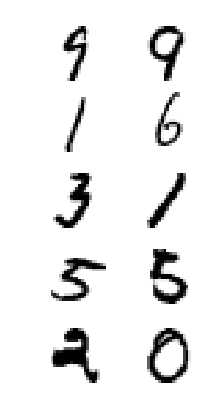

In [174]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [175]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [176]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [177]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.69103277
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047246
4 Train loss: 0.4060757
5 Train loss: 0.38308156
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.3390794
8 Train loss: 0.3210671
9 Train loss: 0.31792685
10 Train loss: 0.24494292
10 Test accuracy: 0.8881
11 Train loss: 0.2929235
12 Train loss: 0.23225449
13 Train loss: 0.23180929
14 Train loss: 0.19877923
15 Train loss: 0.20065464
15 Test accuracy: 0.9203
16 Train loss: 0.19700499
17 Train loss: 0.18893136
18 Train loss: 0.19965452
19 Train loss: 0.24071647
20 Train loss: 0.18882024
20 Test accuracy: 0.9367
21 Train loss: 0.12419197
22 Train loss: 0.14013417
23 Train loss: 0.120789476
24 Train loss: 0.15721135
25 Train loss: 0.11507861
25 Test accuracy: 0.948
26 Train loss: 0.13891116
27 Train loss: 0.1526081
28 Train loss: 0.123436704
29 Train loss: 0.11543139
30 Train loss: 0.1140282
30 Test accuracy: 0.9507
31 Train loss: 0.11897083
32 Train loss

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [178]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [179]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9455
10 Test accuracy: 0.9634
20 Test accuracy: 0.9659
30 Test accuracy: 0.9656
40 Test accuracy: 0.9655
50 Test accuracy: 0.9656
60 Test accuracy: 0.9655
70 Test accuracy: 0.9656
80 Test accuracy: 0.9654
90 Test accuracy: 0.9654


Well, 96.5% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [180]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [181]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9299
30 Test accuracy: 0.935
40 Test accuracy: 0.942
50 Test accuracy: 0.9435
60 Test accuracy: 0.9442
70 Test accuracy: 0.9447
80 Test accuracy: 0.9448
90 Test accuracy: 0.945
100 Test accuracy: 0.945
110 Test accuracy: 0.9458
120 Test accuracy: 0.9456
130 Test accuracy: 0.9458
140 Test accuracy: 0.9458


Only 94.6% accuracy... So transfer learning helped us reduce the error rate from 5.4% to 3.5% (that's over 35% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work, but when it does it can make a big difference. So try it out!